In [1]:
#### 

import pyspark
from pyspark.sql import DataFrame, SparkSession
import pyspark.sql.functions as F
from pyspark.sql import Window

from psutil import virtual_memory
from pyspark import SparkFiles
from pyspark.conf import SparkConf
from pyspark.sql import DataFrame, SparkSession
from pyspark.sql.functions import col


def detect_spark_memory_limit():
    """Spark does not automatically use all available memory on a machine. When working on large datasets, this may
    cause Java heap space errors, even though there is plenty of RAM available. To fix this, we detect the total amount
    of physical memory and allow Spark to use (almost) all of it."""
    mem_gib = virtual_memory().total >> 30
    return int(mem_gib * 0.9)


spark_mem_limit = detect_spark_memory_limit()
spark_conf = (
    SparkConf()
    .set("spark.driver.memory", f"{spark_mem_limit}g")
    .set("spark.executor.memory", f"{spark_mem_limit}g")
    .set("spark.driver.maxResultSize", "0")
    .set("spark.debug.maxToStringFields", "2000000000")
    .set("spark.sql.execution.arrow.maxRecordsPerBatch", "500000")
    ###.set("spark.executor.heartbeatInterval", "3600s")
    .set(
        "spark.sql.execution.arrow.pyspark.enabled", "true"
    )  ## esto lo pongo por esto: https://stackoverflow.com/questions/69973790/pyspark-spark-sparkexception-job-aborted-due-to-stage-failure-task-0-in-stage
    .set("spark.ui.showConsoleProgress", "false")
)

spark = (
    SparkSession.builder.config(conf=spark_conf)
    .master("local[*]")
    .config("spark.driver.bindAddress", "127.0.0.1")
    .config("spark.driver.host","localhost") ### Run locally 
    .getOrCreate()
)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/24 10:54:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/02/24 10:54:38 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
#1# Make a list of variant of interest (Sequence ontology terms) to subset data of interest. 

### Bear in mind that SO works with ontology structure as: SO:XXXXXX, but databases has the SO as: SO_XXXXXX

var_filter_lof = [
    ### High impact variants https://www.ensembl.org/info/genome/variation/prediction/predicted_data.html
    "SO_0001589",## frameshit_variant
    "SO_0001587",## stop_gained
    "SO_0001574",## splice_acceptor_variant
    "SO_0001575",## splice_donor_variant
    "SO_0002012",## start_lost
    "SO_0001578",## stop_lost
    "SO_0001893",## transcript_ablation
    # "SO:0001889", ## transcript_amplification ## the Only HIGH impact that increase protein.
]

gof=['SO_0002053']
lof=['SO_0002054']


In [3]:
## https://stackoverflow.com/questions/45629781/drop-if-all-entries-in-a-spark-dataframes-specific-column-is-null
## drop columns with all values = Null

def drop_fully_null_columns(df, but_keep_these=[]):
    """Drops DataFrame columns that are fully null
    (i.e. the maximum value is null)

    Arguments:
        df {spark DataFrame} -- spark dataframe
        but_keep_these {list} -- list of columns to keep without checking for nulls

    Returns:
        spark DataFrame -- dataframe with fully null columns removed
    """

    # skip checking some columns
    cols_to_check = [col for col in df.columns if col not in but_keep_these]
    if len(cols_to_check) > 0:
        # drop columns for which the max is None
        rows_with_data = df.select(*cols_to_check).groupby().agg(*[F.max(c).alias(c) for c in cols_to_check]).take(1)[0]
        cols_to_drop = [c for c, const in rows_with_data.asDict().items() if const == None]
        new_df = df.drop(*cols_to_drop)

        return new_df
    else:
        return df

In [4]:
otgenetics_evidence_path2="/Users/juanr/Desktop/Target_Engine/DownloadFebruary_Release23.02/evidence/sourceId=ot_genetics_portal"
otgenetics2=spark.read.parquet(otgenetics_evidence_path2)
prueba=drop_fully_null_columns(otgenetics2, but_keep_these=['targetId'])
otgenetics2.filter(F.col('variantFunctionalConsequenceFromQtlId').isNotNull()).count()
otgenetics2.filter(F.col('variantFunctionalConsequenceId').isin(var_filter_lof)).count()
(otgenetics2
.filter(F.col('variantFunctionalConsequenceFromQtlId').isNotNull())
.groupBy('targetId','diseaseId')
.agg(F.collect_set('beta'),F.collect_set('oddsRatio'),F.collect_set('variantFunctionalConsequenceFromQtlId'),F.collect_set('variantFunctionalConsequenceId'))
).toPandas().to_csv('cologwas.csv')

23/02/20 14:40:11 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [4]:
## Building Sequence Ontology 
so_path="/Users/juanr/Desktop/Target_Engine/data_download/sequenceOntology_20221118.csv"
so_ontology=spark.read.csv(so_path, header=True)
building=(so_ontology
.select(F.col('Accession'), F.col('Parents'))
.withColumn('Parentalind',
    F.split(F.col('Parents'), ","))
.withColumn('Parentalind', F.explode_outer('Parentalind'))
.groupBy('Parentalind')
.agg(F.collect_list(F.col('Accession')).alias('childrens'))
.join(so_ontology, F.col('Parentalind')==so_ontology.Accession, 'right')
)


### Load evidence datasources downloaded in January 2023: 

otgenetics_evidence_path="/Users/juanr/Desktop/Target_Engine/DownloadFebruary_Release23.02/evidence/sourceId=ot_genetics_portal"
otgenetics=spark.read.parquet(otgenetics_evidence_path)
gene_burden_path="/Users/juanr/Desktop/Target_Engine/DownloadFebruary_Release23.02/evidence/sourceId=gene_burden"
gene_burden=spark.read.parquet(gene_burden_path)
eva_path="/Users/juanr/Desktop/Target_Engine/DownloadFebruary_Release23.02/evidence/sourceId=eva"
eva_germline=spark.read.parquet(eva_path)
eva_somatic_path="/Users/juanr/Desktop/Target_Engine/DownloadFebruary_Release23.02/evidence/sourceId=eva_somatic"
eva_somatic=spark.read.parquet(eva_somatic_path)
gel_path="/Users/juanr/Desktop/Target_Engine/DownloadFebruary_Release23.02/evidence/sourceId=genomics_england"
gel=spark.read.parquet(gel_path)
g2p_path="/Users/juanr/Desktop/Target_Engine/DownloadFebruary_Release23.02/evidence/sourceId=gene2phenotype"
g2p=spark.read.parquet(g2p_path)
uniprot_path="/Users/juanr/Desktop/Target_Engine/DownloadFebruary_Release23.02/evidence/sourceId=uniprot_literature"
uniprot=spark.read.parquet(uniprot_path)
uniprotvar_path="/Users/juanr/Desktop/Target_Engine/DownloadFebruary_Release23.02/evidence/sourceId=uniprot_variants"
uniprotvar=spark.read.parquet(uniprotvar_path)
orphanet_path="/Users/juanr/Desktop/Target_Engine/DownloadFebruary_Release23.02/evidence/sourceId=orphanet"
orphanet=spark.read.parquet(orphanet_path)
clingen_path="/Users/juanr/Desktop/Target_Engine/DownloadFebruary_Release23.02/evidence/sourceId=clingen"
clingen=spark.read.parquet(clingen_path)
cgc_path="/Users/juanr/Desktop/Target_Engine/DownloadFebruary_Release23.02/evidence/sourceId=cancer_gene_census"
cgc=spark.read.parquet(cgc_path)
intogen_path="/Users/juanr/Desktop/Target_Engine/DownloadFebruary_Release23.02/evidence/sourceId=intogen"
intogen=spark.read.parquet(intogen_path)
impc_path="/Users/juanr/Desktop/Target_Engine/DownloadFebruary_Release23.02/evidence/sourceId=impc"
impc=spark.read.parquet(impc_path)
chembl_evidences="/Users/juanr/Desktop/Target_Engine/DownloadFebruary_Release23.02/evidence/sourceId=chembl/"
chembl=spark.read.parquet(chembl_evidences)


## others
target_path="/Users/juanr/Desktop/Target_Engine/DownloadFebruary_Release23.02/targets/"
target=spark.read.parquet(target_path)
disease_path="/Users/juanr/Desktop/Target_Engine/DownloadFebruary_Release23.02/diseases/"
diseases=spark.read.parquet(disease_path)
dis_name=diseases.select('id','name')
indication_path="/Users/juanr/Desktop/Target_Engine/DownloadFebruary_Release23.02/indication/"
indication=spark.read.parquet(indication_path)
## drug_path="/Users/juanr/Desktop/Target_Engine/downloadedEvidencesJanuary/molecule/"
## drug=spark.read.parquet(drug_path)
mecact_path="/Users/juanr/Desktop/Target_Engine/DownloadFebruary_Release23.02/mechanismOfAction/"
mecact=spark.read.parquet(mecact_path)

#### GENE BURDEN

### We manually annotated those studies using LoF or PTV variants

burden_lof_path="/Users/juanr/Desktop/Target_Engine/Conteo_estudios_geneBurden_20230117.csv"
burden_lof=spark.read.csv(burden_lof_path, header=True)
burden_lof=burden_lof.withColumnRenamed('statisticalMethodOverview','stMethod')

#### Para gene burden la funcion no tiene que hacer un filtrado de variantes

### EVA/ClinVar 

##- Manually annotate which are the clinicalSignificances meaningfull: pathogenic, risk factor, protective

clinSign_germline_path="/Users/juanr/Desktop/Target_Engine/eva_clinSig_20230117.csv"
clinSign_somatic_path="/Users/juanr/Desktop/Target_Engine/eva_somatic_clinSig_20230117.csv"

clinSign_germline=spark.read.csv(clinSign_germline_path, header=True)
clinSign_germline=clinSign_germline.withColumnRenamed('clinicalSignificances','significances')
clinSign_somatic=spark.read.csv(clinSign_somatic_path, header=True)
clinSign_somatic=clinSign_somatic.withColumnRenamed('clinicalSignificances','significances')

##-  Transform array of clinicalSignificances into Strings to check them.

eva_somatic_toAsses=(eva_somatic
.withColumn('clinicalSignificances',F.concat_ws(",",F.col("clinicalSignificances"))))

eva_germline_toAsses=(eva_germline
.withColumn('clinicalSignificances',F.concat_ws(",",F.col("clinicalSignificances"))))


## annotate TSG/oncogene/bivalent using 'hallmarks.attributes'

oncotsg_list = ['TSG','oncogene','Oncogene','oncogene','oncogene,TSG','TSG,oncogene','fusion,oncogene','oncogene,fusion']

oncolabel=(target
.select('id','approvedSymbol',F.explode_outer(F.col('hallmarks.attributes')))
.select('id','approvedSymbol','col.description')
.filter(F.col('description').isin(oncotsg_list))
.groupBy('id','approvedSymbol')
.agg(F.collect_set('description').alias('description'))
.withColumn('description_splited',
    F.concat_ws(",", F.col('description')))
.withColumn('TSorOncogene', 
    F.when(
        (F.col('description_splited').rlike('ncogene') &
        F.col('description_splited').rlike('TSG'))
        , F.lit('bivalent'))
    .when(
        F.col('description_splited').rlike('ncogene(\s|$)')
        , F.lit('oncogene'))
    .when(
        F.col('description_splited').rlike('TSG(\s|$)')
        , F.lit('TSG'))       
    .otherwise(F.lit('noEvaluable')))
.withColumnRenamed('id','target_id')

)

#### rlike('('+Keywords+')(\s|$)'



### Hacer el join del actionType con el chembl para sacar los mecanismos de accion. 
inhibitors = [
'RNAI INHIBITOR',
'NEGATIVE MODULATOR',
'NEGATIVE ALLOSTERIC MODULATOR',
'ANTAGONIST',
'ANTISENSE INHIBITOR',
'BLOCKER',
'INHIBITOR',
'DEGRADER',
'INVERSE AGONIST',
'ALLOSTERIC ANTAGONIST']

activators=[
'PARTIAL AGONIST',
'ACTIVATOR',
'POSITIVE ALLOSTERIC MODULATOR',
'POSITIVE MODULATOR',
'AGONIST',
'SEQUESTERING AGENT']

columnas= ['activator','inhibitor']
both=activators+inhibitors

actiontype2=(mecact
.select('chemblIds','actionType','mechanismOfAction','targets')
.select(F.explode_outer('chemblIds').alias('drugId2'),'actionType','mechanismOfAction','targets')
.select(F.explode_outer('targets').alias('targetId2'), 'drugId2','actionType','mechanismOfAction')
.dropDuplicates())


chembl1=chembl.select('targetId','drugId','diseaseId','clinicalPhase','diseaseFromSourceId')
chembl2=(chembl1
.join(actiontype2,
    (actiontype2.drugId2==F.col('drugId')) & 
    (actiontype2.targetId2==F.col('targetId')),
 'left')
.drop('targetId2','drugId2')
###.dropDuplicates()
.withColumn('twoCategories_new',
    F.when(F.col('actionType').isin(inhibitors), F.lit('inhibitor'))
    .when(F.col('actionType').isin(activators), F.lit('activator'))
    .otherwise(F.lit('noEvaluable'))))

chembl3=(chembl2
.filter(F.col('twoCategories_new')!='noEvaluable')
.groupBy('targetId','diseaseId')
.pivot('twoCategories_new')
.agg(F.count('targetId')))

chembl4=(chembl3
.select(
    'targetId',
    'diseaseId',
    ##'clinicalPhase',
    *(F.col(c).cast("int").alias(c) for c in columnas))
.withColumn('coherency',
    F.when(
        (
        (F.col('activator').isNotNull()) &
        (F.col('inhibitor').isNotNull())
        ),
            F.when(
                (F.col('activator'))-(F.col('inhibitor'))!=(F.col('activator'))
                ,F.lit('dispar'))
    )
))

In [8]:
chembl_clean=drop_fully_null_columns(chembl, but_keep_these=['targetId'])

23/02/03 10:36:53 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
### Join all datasets

dfs=[otgenetics,gene_burden,eva_germline,eva_somatic,g2p,orphanet,cgc,intogen,impc,chembl]

all = dfs[0]
for df in dfs[1:]:
    all = all.unionByName(df, allowMissingColumns=True)
all.count()

4741517

In [6]:
#### 20230203 ### 
prueba_assessment=(all
.withColumn("beta",F.col("beta").cast('float')) ## from ot genetics & gene burden
.withColumn("OddsRatio",F.col("OddsRatio").cast('float')) ## from ot genetics & gene burden
.withColumn('clinicalSignificances',F.concat_ws(",",F.col("clinicalSignificances"))) ### from eva
.withColumn('exploded',F.explode_outer(F.col('mutatedSamples'))) ### para cgc e intogen
.withColumn('variantConsequence',F.col('exploded.functionalConsequenceId'))### para cgc e intogen
### .withColumn('numberSamplesSameMutationType',F.col('exploded.numberSamplesWithMutationType'))### para cgc e intogen
.withColumn("mutatedSamplesVariantInfo", F.coalesce(F.col('mutatedSamples.functionalConsequenceId'), F.array()))### para cgc e intogen

.join(oncolabel, 
oncolabel.target_id==F.col('targetId'), 'left')### para cgc 
.join(burden_lof, 
burden_lof.stMethod == F.col('statisticalMethodOverview'), 'left') ### para gene burden
.join(actiontype2, ## para chembl
    (actiontype2.drugId2==F.col('drugId')) & 
    (actiontype2.targetId2==F.col('targetId')),
 'left')
##.drop('targetId2','drugId2')
###.dropDuplicates()

.withColumn('Assessment',

#### Ot_genetics Portal ### updated to include the coloc+gwas analysis 
        F.when(F.col('datasourceId')=='ot_genetics_portal',

                F.when(  ### label 14 evidences that are contradictory
                        (                       
                        (F.col('variantFunctionalConsequenceFromQtlId')=='SO_0002315') &
                        (F.col('variantFunctionalConsequenceId').isin(var_filter_lof)) 
                        )
                        ,
                        F.lit('dispar'))
                ### evidences with gwas+coloc increased expression without +var_lof
                .when(  
                        (
                        (F.col('beta').isNull()) &
                        (F.col('variantFunctionalConsequenceFromQtlId')=='SO_0002315') &
                        (F.col('variantFunctionalConsequenceId').isin(var_filter_lof) == False)
                        ),
                                F.when((F.col('OddsRatio') >1), F.lit('GoF_risk'))
                                 .when((F.col('OddsRatio') <1) , F.lit('GoF_protect'))                 
                        )
                .when(
                        (
                        (F.col('oddsRatio').isNull()) &
                        (F.col('variantFunctionalConsequenceFromQtlId')=='SO_0002315') &
                        (F.col('variantFunctionalConsequenceId').isin(var_filter_lof) == False)
                        ),
                                F.when((F.col('beta') <0), F.lit('GoF_protect'))
                                .when((F.col('beta') >0), F.lit('GoF_risk'))
                        ) 


                ### evidences with coherent Gwas-coloc + var_lof
                .when(  
                        (
                        (F.col('beta').isNull()) &
                        (F.col('variantFunctionalConsequenceFromQtlId')=='SO_0002316') &
                        (F.col('variantFunctionalConsequenceId').isin(var_filter_lof))
                        ),
                                F.when((F.col('OddsRatio') >1), F.lit('LoF_risk'))
                                 .when((F.col('OddsRatio') <1) , F.lit('LoF_protect'))                 
                        )
                .when(
                        (
                        (F.col('oddsRatio').isNull()) &
                        (F.col('variantFunctionalConsequenceFromQtlId')=='SO_0002316') &
                        (F.col('variantFunctionalConsequenceId').isin(var_filter_lof))
                        ),
                                F.when((F.col('beta') <0), F.lit('LoF_protect'))
                                .when((F.col('beta') >0), F.lit('LoF_risk'))
                        ) 
                ### evidences with colo+Gwas data but not variants
                .when(  
                        (
                        (F.col('beta').isNull()) &
                        (F.col('variantFunctionalConsequenceFromQtlId')=='SO_0002316') &
                        (F.col('variantFunctionalConsequenceId').isin(var_filter_lof) == False)
                        ),
                                F.when((F.col('OddsRatio') >1), F.lit('LoF_risk'))
                                 .when((F.col('OddsRatio') <1) , F.lit('LoF_protect'))                 
                        )
                .when(
                        (
                        (F.col('oddsRatio').isNull()) &
                        (F.col('variantFunctionalConsequenceFromQtlId')=='SO_0002316') &
                        (F.col('variantFunctionalConsequenceId').isin(var_filter_lof) == False)
                        ),
                                F.when((F.col('beta') <0), F.lit('LoF_protect'))
                                .when((F.col('beta') >0), F.lit('LoF_risk'))
                        ) 
                ### evidences with coherent non/inconclusive gwas+coloc + var_lof
                .when(  
                        (
                        (F.col('beta').isNull()) &
                                (
                                (F.col('variantFunctionalConsequenceFromQtlId')=='SO_0002314') |
                                (F.col('variantFunctionalConsequenceFromQtlId').isNull())
                                ) &
                        (F.col('variantFunctionalConsequenceId').isin(var_filter_lof))
                        ),
                                F.when((F.col('OddsRatio') >1), F.lit('LoF_risk'))
                                 .when((F.col('OddsRatio') <1) , F.lit('LoF_protect'))                 
                        )
                .when(  
                        (
                        (F.col('oddsRatio').isNull()) &
                                (
                                (F.col('variantFunctionalConsequenceFromQtlId')=='SO_0002314') |
                                (F.col('variantFunctionalConsequenceFromQtlId').isNull())
                                ) &
                        (F.col('variantFunctionalConsequenceId').isin(var_filter_lof))
                        ),
                                F.when((F.col('beta') <0), F.lit('LoF_protect'))
                                .when((F.col('beta') >0), F.lit('LoF_risk'))
                        ) 
                
                .otherwise(F.lit('noEvaluable')))  ### son tambien no data las que tiene riesgo pero no tienen LoF

#### Gene burden                            
        .when(F.col('datasourceId')=='gene_burden',
        ### .filter(F.col('variantType').isin(var_filter))
                F.when(
                        (
                        (F.col('whatToDo')=='get')&
                        (F.col('beta').isNull()) &  
                        (F.col('OddsRatio') > 1)
                        ), 
                        F.lit('LoF_risk')
                        )
                .when(
                        (
                        (F.col('whatToDo')=='get')&
                        (F.col('beta').isNull()) & 
                        (F.col('OddsRatio') <1) 
                        ),
                        F.lit('LoF_protect')
                )
                .when(
                        (
                        (F.col('whatToDo')=='get')&
                        (F.col('OddsRatio').isNull()) & 
                        (F.col('beta') >0)
                        ), 
                        F.lit('LoF_risk')
                )
                .when(
                        (
                        (F.col('whatToDo')=='get')&
                        (F.col('OddsRatio').isNull()) & 
                        (F.col('beta') <0) 
                        ),
                        F.lit('LoF_protect')
                )
                .otherwise(F.lit('noEvaluable')) ### son tambien no data las que tiene riesgo pero no se ensayan LoF o PT 
                        )
#### Eva_germline                        
        .when(F.col('datasourceId')=='eva',              
        #### .filter(F.col('variantFunctionalConsequenceId').isin(var_filter_lof))
                F.when(
                        (
                        ## (F.col('clinicalSignificances')!='likely pathogenic') &  
                        (F.col('variantFunctionalConsequenceId').isin(var_filter_lof)) &
                        F.col('clinicalSignificances').rlike('(pathogenic)$')
                        ),
                        F.lit('LoF_risk'))
                .when(
                        (
                        F.col('clinicalSignificances').contains('protective')&  
                        F.col('variantFunctionalConsequenceId').isin(var_filter_lof)),
                        F.lit('LoF_protect'))
                .otherwise(F.lit('noEvaluable')) ### Son todas aquellas que tenen info pero no son patogenicas/protective  + LoF
                        )
        #### Eva_somatic  
        .when(F.col('datasourceId')=='eva_somatic',              
        #### .filter(F.col('variantFunctionalConsequenceId').isin(var_filter_lof))
                F.when(
                        (
                        ##(F.col('clinicalSignificances')!='likely pathogenic') &  
                        (F.col('variantFunctionalConsequenceId').isin(var_filter_lof)) &
                        F.col('clinicalSignificances').rlike('(pathogenic)$')
                        ),
                        F.lit('LoF_risk'))
                .when(
                        (
                        F.col('clinicalSignificances').contains('protective')&  
                        F.col('variantFunctionalConsequenceId').isin(var_filter_lof)),
                        F.lit('LoF_protect'))
                .otherwise(F.lit('noEvaluable')) ### Son todas aquellas que tenen info pero no son patogenicas/protective  + LoF
                        )
#### G2P                     
        .when(F.col('datasourceId')=='gene2phenotype',  
                F.when(
                        F.col('variantFunctionalConsequenceId')=='SO_0002317', F.lit('LoF_risk')
                        ) ### absent gene product
                .when(
                        F.col('variantFunctionalConsequenceId')=='SO_0002315', F.lit('GoF_risk')
                        ) ### increased gene product level
                .otherwise(F.lit('noEvaluable')))
#### Orphanet 
        .when(F.col('datasourceId')=='orphanet',  
                F.when(
                        F.col('variantFunctionalConsequenceId')=='SO_0002054', F.lit('LoF_risk')
                        ) ### Loss of Function Variant
                .when(
                        F.col('variantFunctionalConsequenceId')=='SO_0002053', F.lit('GoF_risk')
                        ) ### Gain_of_Function Variant
                .otherwise(F.lit('noEvaluable')))
 #### CGC               
        .when(F.col('datasourceId')=='cancer_gene_census',          
                F.when(
                        F.col('TSorOncogene')=='oncogene', F.lit('GoF_risk')
                )
                .when(
                        F.col('TSorOncogene')=='TSG', F.lit('LoF_risk')
                        )
                .when(
                        F.col('TSorOncogene')=='bivalent', F.lit('bivalent_risk'))

                .otherwise(
                        F.when(
                                F.arrays_overlap(
                                F.col('mutatedSamples.functionalConsequenceId'),
                                F.array([F.lit(i) for i in (var_filter_lof)])
                                ), F.lit('LoF_risk')
                                )
                        .otherwise(F.lit('noEvaluable'))
                        )
                ) #### Aqui asumimos que todo lo que esta incluido da riesgo, pero solo podemos dar LoF porque ya no tienen dato de TSG/oncogen
#### intogen
        .when(F.col('datasourceId')=='intogen',     
                F.when(
                        F.arrays_overlap(
                                F.col('mutatedSamples.functionalConsequenceId'),
                                F.array([F.lit(i) for i in (gof)])
                                ), F.lit('GoF_risk'))
                .when(
                        F.arrays_overlap(
                                F.col('mutatedSamples.functionalConsequenceId'),
                                F.array([F.lit(i) for i in (lof)])
                                ), F.lit('LoF_risk'))

                .otherwise(F.lit('noEvaluable'))
        )
#### impc        
        .when(F.col('datasourceId')=='impc', 
                F.when(
                        F.col('diseaseId').isNotNull(), F.lit('KO_risk')
                        )
                .otherwise(F.lit('noEvaluable')))
### chembl        
        .when(F.col('datasourceId')=='chembl',
                F.when(
                        F.col('actionType').isin(inhibitors), F.lit('LoF_protect')
                        )
                .when(
                        F.col('actionType').isin(activators), F.lit('GoF_protect')
                )
                .otherwise(F.lit('noEvaluable'))
                )
)

### Homogenizar para contar todos los datos juntos:
.withColumn('homogenized',
    F.when(F.col('Assessment')=='KO_risk', F.lit('LoF_risk'))
    .otherwise(F.col('Assessment')))
.withColumn('tendency',
    F.when(F.col('homogenized').contains('risk'), F.lit('Risk'))
    .when(F.col('homogenized').contains('protect'), F.lit('Protect'))
    .otherwise(F.lit('noEvaluable')))
.withColumn('variation',
    F.when(F.col('homogenized').contains('LoF'), F.lit('LoF'))
    .when(F.col('homogenized').contains('GoF'), F.lit('GoF'))
    .otherwise(F.lit('noEvaluable')))
)

In [7]:
### 1###  Number of assessment per category of Assessment
(prueba_assessment
##.filter((F.col('Assessment')).isin(terms)==False )
.groupBy('Assessment','tendency','variation')
.agg(F.count('targetId').alias('counts'))
).show()

+-------------+-----------+-----------+-------+
|   Assessment|   tendency|  variation| counts|
+-------------+-----------+-----------+-------+
|  noEvaluable|noEvaluable|noEvaluable|2623752|
|     GoF_risk|       Risk|        GoF|  78680|
|  LoF_protect|    Protect|        LoF| 558312|
|       dispar|noEvaluable|noEvaluable|     21|
|         null|noEvaluable|noEvaluable|     34|
|  GoF_protect|    Protect|        GoF| 137373|
|     LoF_risk|       Risk|        LoF| 347761|
|bivalent_risk|       Risk|noEvaluable|  15274|
|      KO_risk|       Risk|        LoF|1047024|
+-------------+-----------+-----------+-------+



In [8]:
### PIE 
### 1###  Number of assessment per category of Assessment
unopie=(prueba_assessment
##.filter((F.col('Assessment')).isin(terms)==False )
.groupBy('Assessment','tendency','variation')
.agg(F.count('targetId').alias('counts'))
)
### unopie.toPandas().to_csv('unopie.csv')

In [9]:
### 2###  Number of assessment per category of homogenized
(prueba_assessment
##.filter((F.col('Assessment')).isin(terms)==False )
.groupBy('homogenized','tendency','variation')
.agg(F.count('targetId'))
).show()

+-------------+-----------+-----------+---------------+
|  homogenized|   tendency|  variation|count(targetId)|
+-------------+-----------+-----------+---------------+
|  noEvaluable|noEvaluable|noEvaluable|        2623752|
|     GoF_risk|       Risk|        GoF|          78680|
|  LoF_protect|    Protect|        LoF|         558312|
|       dispar|noEvaluable|noEvaluable|             21|
|         null|noEvaluable|noEvaluable|             34|
|  GoF_protect|    Protect|        GoF|         137373|
|     LoF_risk|       Risk|        LoF|        1394785|
|bivalent_risk|       Risk|noEvaluable|          15274|
+-------------+-----------+-----------+---------------+



In [10]:
### 3 ###  Conteo evidences by datasourceId unicas agrupando por datasource
terms=['noEvaluable','bivalent_risk','null','dispar']

(prueba_assessment
.filter((F.col('Assessment')).isin(terms)==False )
.groupBy('datasourceId')
.pivot('homogenized')
.agg(F.count('targetId').alias('N_assessed'))
).show()
##).toPandas().to_csv('datasource.csv')

+------------------+-----------+--------+-----------+--------+
|      datasourceId|GoF_protect|GoF_risk|LoF_protect|LoF_risk|
+------------------+-----------+--------+-----------+--------+
|       gene_burden|       null|    null|       6259|   11386|
|            chembl|      85165|    null|     498966|    null|
|           intogen|       null|    1080|       null|    1826|
|          orphanet|       null|     194|       null|    1136|
|cancer_gene_census|       null|   23563|       null|   61859|
|               eva|       null|    null|          8|  213867|
|    gene2phenotype|       null|       7|       null|    2009|
|       eva_somatic|       null|    null|       null|    1423|
|ot_genetics_portal|      52208|   53836|      53079|   54255|
|              impc|       null|    null|       null| 1047024|
+------------------+-----------+--------+-----------+--------+



In [13]:
(prueba_assessment
.filter(
    (F.col('Assessment').isin(terms)==False) &
    (F.col('datasourceId')=='ot_genetics_portal')& 
    (F.col('homogenized')=='LoF_risk'))
.groupBy('targetId','diseaseId').agg(F.count('targetId'))).count()

34768

In [11]:
### 3 bis ### conteo parejas target-disease por datasource

terms=['noEvaluable','bivalent_risk','null','dispar']

(prueba_assessment
.filter((F.col('Assessment')).isin(terms)==False )
.groupBy('targetId','diseaseId','datasourceId')
.pivot('homogenized')
.agg(F.count('targetId').alias('N_assessed'))
.groupBy('datasourceId')
.agg(F.count('GoF_protect'),
F.count('LoF_protect'),
F.count('GoF_risk'),
F.count('LoF_risk'))

).toPandas().to_csv('tardis_datasource2.csv')

In [12]:
(prueba_assessment
.filter((F.col('homogenized')).isin(terms)==False)
.groupBy('homogenized','targetid','diseaseId')
.agg(F.count('targetId'))).count()

807799

In [13]:
### 4###  Conteo TargetId and diseaseId agrupando homogenized, targetId y diseaseId
terms=['noEvaluable','bivalent_risk','null','dispar']

(prueba_assessment
.filter((F.col('homogenized')).isin(terms)==False)
.groupBy('homogenized','targetid','diseaseId')
.agg(F.count('targetId'))
.groupBy('homogenized')
.agg(F.count('targetId'),F.count('diseaseId'))
).show()
##).toPandas().to_csv('pruebesita.csv')

+-----------+---------------+----------------+
|homogenized|count(targetId)|count(diseaseId)|
+-----------+---------------+----------------+
|LoF_protect|          92289|           92289|
|   LoF_risk|         621036|          621036|
|GoF_protect|          45963|           45963|
|   GoF_risk|          48511|           48511|
+-----------+---------------+----------------+



In [14]:
### 5#### Conteo targetId unicas agrupando por variation & tendency
terms=['noEvaluable','bivalent_risk','null','dispar']

(prueba_assessment
.filter((F.col('homogenized')).isin(terms)==False)
.groupBy('tendency')
.pivot('variation')
.agg(F.countDistinct('targetId'))
).show()
##).toPandas().to_csv('pruebesita.csv')

+--------+----+-----+
|tendency| GoF|  LoF|
+--------+----+-----+
| Protect|9124| 9770|
|    Risk|9192|14847|
+--------+----+-----+



In [15]:
### 6#### Conteo diseaseId unicas agrupando por variation & tendency
terms=['noEvaluable','bivalent_risk','null','dispar']

(prueba_assessment
.filter((F.col('homogenized')).isin(terms)==False)
.groupBy('tendency')
.pivot('variation')
.agg(F.countDistinct('diseaseId'))
).show()

+--------+----+----+
|tendency| GoF| LoF|
+--------+----+----+
| Protect|2135|2731|
|    Risk|1831|9414|
+--------+----+----+



In [16]:
### 7#### Numero de combinaciones target-diseases agrupadas en Protect/Risk & GoF/LoF
terms=['noEvaluable','bivalent_risk','null','dispar']

uno=(prueba_assessment
.filter((F.col('homogenized')).isin(terms)==False)
.groupBy('targetId','diseaseId','tendency')
.pivot('variation')
.agg(
    F.countDistinct('targetId').alias('contar'),
    )
.groupBy('tendency')
.agg(F.count('GoF'),
    F.count('LoF')
    )
).show()

+--------+----------+----------+
|tendency|count(GoF)|count(LoF)|
+--------+----------+----------+
| Protect|     45963|     92289|
|    Risk|     48511|    621036|
+--------+----------+----------+



In [70]:
#### CONTRADICTIONS INTRADATASOURCES #### 

In [17]:
#### checking contradictions intra datasources 03.02.2023 #### 

terms=['noEvaluable','bivalent_risk','null','dispar']


coherency_toAssess=(prueba_assessment
.filter((F.col('Assessment')).isin(terms)==False)
.groupBy('targetId','diseaseId','datasourceId')
.pivot('homogenized')
.agg(F.count('targetId')))

columns=[
 'GoF_risk',
 'LoF_protect',
 'LoF_risk',
 'GoF_protect']

coherency_assessed=(coherency_toAssess
.select(
    F.col('targetId').alias('targetId3'),
    F.col('datasourceId').alias('datasourceId3'),
    F.col('diseaseId').alias('diseaseId3'),
    *(F.col(c).cast("int").alias(c) for c in columns))

.withColumn('coherency',
    F.when(
        (
        (F.col('GoF_risk').isNotNull()) &
        (F.col('LoF_risk').isNotNull())
        ),
            F.when(
                (F.col('GoF_risk'))-(F.col('LoF_risk'))!=(F.col('GoF_risk'))
                ,F.lit('dispar'))
        )
    .when(
        (
        (F.col('LoF_protect').isNotNull()) &
        (F.col('LoF_risk').isNotNull())
        ),
            F.when(
                (F.col('LoF_protect'))-(F.col('LoF_risk'))!=(F.col('LoF_protect'))
                ,F.lit('dispar'))
        )   
    .when(
        (
        (F.col('GoF_protect').isNotNull()) &
        (F.col('GoF_risk').isNotNull())
        ),
            F.when(
                (F.col('GoF_protect'))-(F.col('GoF_risk'))!=(F.col('GoF_protect'))
                ,F.lit('dispar'))
        )   
    .when(
        (
        (F.col('GoF_protect').isNotNull()) &
        (F.col('LoF_protect').isNotNull())
        ),
            F.when(
                (F.col('GoF_protect'))-(F.col('LoF_protect'))!=(F.col('GoF_protect'))
                ,F.lit('dispar'))
        )      
        
        ))

In [18]:
coherency_assessed.filter(F.col('coherency')=='dispar').groupBy('datasourceId3').agg(F.count('targetId3')).show()

+------------------+----------------+
|     datasourceId3|count(targetId3)|
+------------------+----------------+
|       gene_burden|              59|
|            chembl|             973|
|ot_genetics_portal|           11037|
|               eva|               1|
+------------------+----------------+



In [19]:
#### Build dataset for checking intradatasource disparities 

columnstoassess=prueba_assessment.drop('targetId','diseaseId','datasourceId').columns
terms=['noEvaluable','bivalent_risk','null','dispar']
### Make the incoherencies dataset: join disease name, approved symbol and collect how many evidences are supporting every column

intradatasource_disparities=(coherency_assessed
.filter(F.col('coherency')=='dispar')
.groupBy('datasourceId3','targetId3','diseaseId3')
.agg(F.count('targetId3').alias('targetI'))
.withColumnRenamed('targetId3','targetIdU')
.withColumnRenamed('datasourceId3','datasourceI')
.withColumnRenamed('diseaseId3','diseaseI')

.join((prueba_assessment.filter(F.col('Assessment').isin(terms)==False)), 
    (F.col('targetIdU')==prueba_assessment.targetId)&
    (F.col('datasourceI')==prueba_assessment.datasourceId) &
    (F.col('diseaseI')==prueba_assessment.diseaseId),'left')
.join(diseases.select('id','name',), F.col('diseaseId')==diseases.id,'left')
.groupBy('targetId','diseaseI','name','datasourceI')
.agg(F.collect_list('clinicalSignificances').alias('clinicalSignificances'),
    F.collect_list('beta').alias('betaValues'),
    F.collect_list('OddsRatio').alias('oddsRatio'),
    F.collect_list('variantFunctionalConsequenceId').alias('varFunctConsId'),
    F.collect_list('drugId').alias('drugId'),
    F.collect_set('actionType').alias('actionTypeDif'),
    F.collect_list('diseaseFromSource'))
.withColumnRenamed('targetId','targetiddd')
.withColumnRenamed('name','diseaseName')
.join(coherency_assessed, 
    (F.col('targetIddd')==coherency_assessed.targetId3) &
    (F.col('datasourceI')==coherency_assessed.datasourceId3) &
    (F.col('diseaseI')==coherency_assessed.diseaseId3)
)
### anadir el approved symbol:
.join(target.select('id','approvedSymbol'), F.col('targetiddd')==target.id, 'left')
)

In [ ]:
### dataset de contradictions!! working!

intradatasource_disparities.toPandas().to_csv('contradictions3.csv')

/opt/anaconda3/envs/python/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [20]:
### some numbers: 

all_targetTrait=prueba_assessment.count()
targetTraitWObivalent_noEvaluable=(prueba_assessment.filter((F.col('Assessment')).isin(terms)==False)).count()
one=(prueba_assessment
.filter(
    (F.col('Assessment').isin(terms)==False))
.groupBy('targetId','diseaseId')
.pivot('homogenized')
.agg(F.count('targetId'))).count()


two=(prueba_assessment
.filter((F.col('Assessment')).isin(terms)==False)
.groupBy('targetId','diseaseId','datasourceId')
.pivot('homogenized')
.agg(F.count('targetId'))).count()

print('target-trait pairs from evidences asssssed: ' + str(int(all_targetTrait)))
print('target-trait pairs from evidences with assessment dif from noEvaluable/bivalent: ' + str(int(targetTraitWObivalent_noEvaluable)))
print(one, two)
print(two-one)

target-trait pairs from evidences asssssed: 4808231
target-trait pairs from evidences with assessment dif from noEvaluable/bivalent: 2169150
783826 793235
9409


In [21]:
#### For now we should remove the not resolved contradictions :

contradictIntra=(coherency_assessed
.filter(F.col('coherency')=='dispar')
#.select('targetId3','diseaseId3','datasourceId3','coherency')
.groupBy('targetId3','diseaseId3')
.agg(
    F.count('targetId3').alias('targetId'),
    F.collect_set('datasourceId3').alias('datasourceId'))
.withColumn('size', 
    F.size('datasourceId').alias('size'))
.sort(F.col('size').desc())
.withColumn('filterOut',F.lit('out')))

### Make the join with the dataset containing information for the asessments to tag the pairs for removing them

terms=['noEvaluable','bivalent_risk']
toprocess=(prueba_assessment
.filter(
    (F.col('Assessment').isin(terms)==False))
.groupBy('targetId','diseaseId')
.pivot('homogenized')
.agg(F.count('targetId'))
.join(contradictIntra.select('targetId3','diseaseId3','filterOut'),
    (F.col('targetId')==contradictIntra.targetId3) & 
    (F.col('diseaseId')==contradictIntra.diseaseId3)
    ,'left')
.withColumn('filterOut',
    F.when(F.col('filterOut')=='out', F.lit(F.col('filterOut')))
    .otherwise(F.lit('keep'))))


In [22]:
cols =  ['cancer_gene_census',
 'chembl',
 'eva',
 'eva_somatic',
 'gene2phenotype',
 'gene_burden',
 'impc',
 'intogen',
 'orphanet',
 'ot_genetics_portal']

In [23]:
##### testing 

terms=['noEvaluable','bivalent_risk','null','dispar']

test=(prueba_assessment
.filter(
    (F.col('Assessment').isin(terms)==False))
.groupBy('targetId','diseaseId','homogenized','datasourceId')
.pivot('homogenized')
.agg(F.count('targetId'))
.join(contradictIntra.select('targetId3','diseaseId3','filterOut'),
    (F.col('targetId')==contradictIntra.targetId3) & 
    (F.col('diseaseId')==contradictIntra.diseaseId3)
    ,'left')
.withColumn('filterOut',
    F.when(F.col('filterOut')=='out', F.lit(F.col('filterOut')))
    .otherwise(F.lit('keep')))
.filter(F.col('filterOut')=='keep')
.drop('targetId3','diseaseId3','filterOut')
)


In [ ]:
#### COHERENCY INTERDATASET #####

In [24]:
(prueba_assessment
.filter(
    (F.col('Assessment').isin(terms)==False))
.groupBy('targetId','diseaseId')
.agg(F.count('targetId'))).count()

783826

In [25]:
### Include the calculation of overlapping
terms=['noEvaluable','bivalent_risk','null','dispar']
#### reminder of 'toprocess': 
toprocess=(prueba_assessment
.filter(
    (F.col('Assessment').isin(terms)==False))
.groupBy('targetId','diseaseId')
.pivot('homogenized')
.agg(F.count('targetId'))
.join(contradictIntra.select('targetId3','diseaseId3','filterOut'),
    (F.col('targetId')==contradictIntra.targetId3) & 
    (F.col('diseaseId')==contradictIntra.diseaseId3)
    ,'left')
.withColumn('filterOut',
    F.when(F.col('filterOut')=='out', F.lit(F.col('filterOut')))
    .otherwise(F.lit('keep'))))
#####


columns=[
 'GoF_risk',
 'LoF_protect',
 'LoF_risk',
 'GoF_protect']

coherencyInter_assessed_wOut=(toprocess
##.filter(F.col('filterOut')!='out')
.select(
    F.col('targetId'),#.alias('targetId3'),
    F.col('diseaseId'),#.alias('diseaseId3'),
    F.col('filterOut'),
    *(F.col(c).cast("int").alias(c) for c in columns))

.withColumn('coherency',
    F.when(
        (
        (F.col('GoF_risk').isNotNull()) &
        (F.col('LoF_risk').isNotNull())
        ),
            F.when(
                (F.col('GoF_risk'))-(F.col('LoF_risk'))!=(F.col('GoF_risk'))
                ,F.lit('dispar'))
        )
    .when(
        (
        (F.col('LoF_protect').isNotNull()) &
        (F.col('LoF_risk').isNotNull())
        ),
            F.when(
                (F.col('LoF_protect'))-(F.col('LoF_risk'))!=(F.col('LoF_protect'))
                ,F.lit('dispar'))
        )   
    .when(
        (
        (F.col('GoF_protect').isNotNull()) &
        (F.col('GoF_risk').isNotNull())
        ),
            F.when(
                (F.col('GoF_protect'))-(F.col('GoF_risk'))!=(F.col('GoF_protect'))
                ,F.lit('dispar'))
        )   
    .when(
        (
        (F.col('GoF_protect').isNotNull()) &
        (F.col('LoF_protect').isNotNull())
        ),
            F.when(
                (F.col('GoF_protect'))-(F.col('LoF_protect'))!=(F.col('GoF_protect'))
                ,F.lit('dispar'))
        )      
    .when(
        (
        (F.col('GoF_protect').isNotNull()) &
        (F.col('LoF_risk').isNotNull())
        ),
            F.when(
                (F.col('GoF_protect'))-(F.col('LoF_risk'))!=(F.col('GoF_protect'))
                ,F.lit('coherent'))
    )      
    .when(
        (
        (F.col('LoF_protect').isNotNull()) &
        (F.col('GoF_risk').isNotNull())
        ),
            F.when(
                (F.col('LoF_protect'))-(F.col('GoF_risk'))!=(F.col('LoF_protect'))
                ,F.lit('coherent'))
        )   
    .otherwise(F.lit('take')))
)

In [ ]:

countPairsEvidences=(coherencyInter_assessed_wOut
.filter(
    (F.col('coherency')=='take')))
#####countPairsEvidences.count()
## 762208

In [26]:
### Build the dataset for Disparities inter datasource: 


terms=['noEvaluable','bivalent_risk','null','dispar']

### Make the incoherencies dataset: join disease name, approved symbol and collect how many evidences are supporting every column

interdatasource=(coherencyInter_assessed_wOut
.filter(F.col('coherency')=='dispar')
.groupBy('targetId','diseaseId')
.agg(F.count('targetId').alias('targetI'))
.withColumnRenamed('targetId','targetIdU')
.withColumnRenamed('diseaseId','diseaseI')

.join((prueba_assessment.filter(F.col('Assessment').isin(terms)==False)), 
    (F.col('targetIdU')==prueba_assessment.targetId)&
###    (F.col('datasourceI')==prueba_assessment.datasourceId) &
    (F.col('diseaseI')==prueba_assessment.diseaseId),'left')
.join(diseases.select('id','name',), F.col('diseaseId')==diseases.id,'left')
.groupBy('targetId','diseaseI','name')
.agg(F.collect_list('clinicalSignificances').alias('clinicalSignificances'),
    F.collect_list('beta').alias('betaValues'),
    F.collect_list('OddsRatio').alias('oddsRatio'),
    F.collect_list('variantFunctionalConsequenceId').alias('varFunctConsId'),
    F.collect_list('drugId').alias('drugId'),
    F.collect_set('actionType').alias('actionTypeDif'),
    F.collect_set('datasourceId'),
    F.collect_list('diseaseFromSource'))
.withColumnRenamed('targetId','targetiddd')
.withColumnRenamed('name','diseaseName')
.join(coherencyInter_assessed_wOut, 
    (F.col('targetIddd')==coherencyInter_assessed_wOut.targetId) &
##    (F.col('datasourceI')==coherency_assessed.datasourceId3) &
    (F.col('diseaseI')==coherencyInter_assessed_wOut.diseaseId)
)
### anadir el approved symbol:
.join(target.select('id','approvedSymbol'), F.col('targetiddd')==target.id, 'left')
)

##interdatasource.count()
### 13.548 counts

In [27]:
### las columnas con null no nos valen para las operaciones, necesitamos cambiarlas por 0: 

##interdatasource.fillna(value=0, subset=["GoF_risk","LoF_protect","LoF_risk","GoF_protect",'totalEvidences'])

interdatasourcePercentage=(interdatasource

.withColumn('minoritaryPercentage',
    F.when(
            F.col('LoF_protect')>= F.col('LoF_risk'), F.lit((F.col('LoF_risk')/(F.col('LoF_risk')+F.col('LoF_protect')))*100))
    .when(
            F.col('LoF_protect') < F.col('LoF_risk'), F.lit((F.col('LoF_protect')/(F.col('LoF_risk')+F.col('LoF_protect')))*100))

    .when(
            F.col('GoF_protect') < F.col('GoF_risk'), F.lit((F.col('GoF_protect')/(F.col('GoF_protect')+F.col('GoF_risk')))*100))
    .when(
            F.col('GoF_protect') >= F.col('GoF_risk'), F.lit((F.col('GoF_risk')/(F.col('GoF_protect')+F.col('GoF_risk')))*100))
            
    .when(
            F.col('GoF_risk') < F.col('LoF_risk'), F.lit((F.col('GoF_risk')/(F.col('GoF_risk')+F.col('LoF_risk')))*100))
    .when(
            F.col('GoF_risk') >= F.col('LoF_risk'), F.lit((F.col('LoF_risk')/(F.col('GoF_risk')+F.col('LoF_risk')))*100))    

    .when(
            F.col('GoF_protect') < F.col('LoF_protect'), F.lit((F.col('GoF_protect')/(F.col('GoF_protect')+F.col('LoF_protect')))*100))
    .when(
            F.col('GoF_protect') >= F.col('LoF_protect'), F.lit((F.col('LoF_protect')/(F.col('GoF_protect')+F.col('LoF_protect')))*100))   
    
    )
.fillna(value=0, subset=["GoF_risk","LoF_protect","LoF_risk","GoF_protect"])
.withColumn('totalEvidences',
        F.expr("GoF_risk + LoF_protect + LoF_risk + GoF_protect")
))

###.toPandas().to_csv('interdatasourcetest_TODAY.csv')


In [35]:
interdatasourcePercentage.printSchema()

root
 |-- targetiddd: string (nullable = true)
 |-- diseaseI: string (nullable = true)
 |-- diseaseName: string (nullable = true)
 |-- clinicalSignificances: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- betaValues: array (nullable = false)
 |    |-- element: float (containsNull = false)
 |-- oddsRatio: array (nullable = false)
 |    |-- element: float (containsNull = false)
 |-- varFunctConsId: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- drugId: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- actionTypeDif: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- collect_set(datasourceId): array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- collect_list(diseaseFromSource): array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- targetId: string (nullable = true)
 |-- diseaseId: string (nullable = true)
 |-- filterOut

In [43]:
## Recoger los datos de diseaseName
interdatasourcePercentage.groupBy('diseaseId','diseaseName').agg(F.count('targetiddd').alias('counts')).orderBy(F.col('counts').desc()).show()

+-----------+--------------------+------+
|  diseaseId|         diseaseName|counts|
+-----------+--------------------+------+
|EFO_0004526|mean corpuscular ...|   508|
|EFO_0004339|         body height|   424|
|EFO_0004309|      platelet count|   406|
|EFO_0007986|  reticulocyte count|   388|
|EFO_0004995|      lean body mass|   369|
|EFO_0004584|mean platelet volume|   368|
|EFO_0004528|mean corpuscular ...|   335|
|EFO_0004696|sex hormone-bindi...|   310|
|EFO_0004980|appendicular lean...|   270|
|EFO_0004587|    lymphocyte count|   268|
|EFO_0004842|    eosinophil count|   253|
|EFO_0004833|    neutrophil count|   249|
|EFO_0005192|red blood cell di...|   245|
|EFO_0004305|   erythrocyte count|   240|
|EFO_0009270|heel bone mineral...|   235|
|EFO_0005409|       fat body mass|   231|
|EFO_0004308|     leukocyte count|   220|
|EFO_0005091|      monocyte count|   213|
|EFO_0004509|hemoglobin measur...|   210|
|EFO_0010700|reticulocyte meas...|   181|
+-----------+--------------------+

In [57]:
### contar dispares
#coherencyInter_assessed_wOut.filter(F.col('coherency')=='dispar').count()
### dispares = 13.584

### contar takes
# coherencyInter_assessed_wOut.filter(F.col('coherency')=='take').count()
### 762.208

762208

In [81]:
uno.printSchema()()

root
 |-- diseaseId: string (nullable = true)
 |-- coherent: long (nullable = true)
 |-- dispar: long (nullable = true)
 |-- take: long (nullable = true)
 |-- percentageTrue: double (nullable = true)
 |-- percentageContradic: double (nullable = true)



TypeError: 'NoneType' object is not callable

In [72]:
#### sacar el numero de eventos 
terms=['noEvaluable','bivalent_risk','null','dispar']

toprocess_datasource=(prueba_assessment
.filter(
    (F.col('Assessment').isin(terms)==False))
.groupBy(
    ##'targetId',
    'diseaseId')
.pivot('homogenized')
.agg(F.collect_set('diseaseFromSource'))
).show()
#####

+-----------+--------------------+--------------------+--------------------+--------------------+
|  diseaseId|         GoF_protect|            GoF_risk|         LoF_protect|            LoF_risk|
+-----------+--------------------+--------------------+--------------------+--------------------+
|  DOID_7551|                  []|                  []|         [gonorrhea]|                  []|
|EFO_0000174|[Ewing's Sarcoma,...|   [Ewing's sarcoma]|[EWINGS SARCOMA, ...|[Ewing Sarcoma, E...|
|EFO_0000191|[Extranodal Margi...|                  []|[Antibiotics-unre...|[Malt Lymphoma, L...|
|EFO_0000198|[Anemia in Myelod...|                  []|[Myelodysplastic ...|[41202#D46#D46 My...|
|EFO_0000199|[Squamous Cell Ca...|                  []|[Squamous Cell Ca...|                  []|
|EFO_0000233|[Adenosquamous Ce...|                  []|[Adenosquamous Ce...|                  []|
|EFO_0000274|[Dermatitis, Atop...|["Atopic  dermati...|[Dermatitis, Atop...|[Dermatitis, atop...|
|EFO_0000348|       

In [28]:

### make percentage of diseases
uno=(coherencyInter_assessed_wOut
.groupBy('diseaseId')
.pivot('coherency')
.agg(F.count('targetId'))

.withColumn('percentageTrue',
    F.lit(F.col('take')/762208*100))
.withColumn('percentageContradic',
    F.lit(F.col('dispar')/13584*100))
.withColumn('suspicious',
    F.when(F.col('percentageContradic')>F.col('percentageTrue'),F.lit('suspicious'))
    .when(F.col('percentageContradic')<=F.col('percentageTrue'),F.lit('nonSuspicious')))
.withColumn('foldChange',
    F.when(F.col('suspicious')=='suspicious', F.lit(F.col('percentageContradic')/F.col('percentageTrue')))
))
###.toPandas().to_csv('percentages.csv')


In [96]:
uno.join(diseases.select('id','name'), diseases.id==F.col('diseaseId')).toPandas().to_csv('percentages3.csv')

/opt/anaconda3/envs/python/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [362]:
#### 28.02.2023
### count the number of unique target id involved
pruebe=(coherencyInter_assessed_wOut
.groupBy('diseaseId') 
.pivot('coherency')
.agg(F.countDistinct('targetId'))

.withColumn('percentageContradict',
    F.lit(F.col('dispar')/(F.col('take')+F.col('dispar')+F.col('coherent'))*100))
)

### falta hacer el join con las contradicciones para mostrar solo contradict 


In [356]:
pruebe.show()

+---------------+--------+------+----+--------------------+
|      diseaseId|coherent|dispar|take|percentageContradict|
+---------------+--------+------+----+--------------------+
|  MONDO_0009148|    null|  null|  38|                null|
| Orphanet_85182|    null|  null|  20|                null|
|  MONDO_0016485|    null|  null|  38|                null|
|  MONDO_0015028|    null|  null|  11|                null|
|  Orphanet_1259|    null|  null|  65|                null|
| Orphanet_98261|    null|  null| 213|                null|
|    EFO_0004254|       1|     1|  27|   93.10344827586206|
|  MONDO_0012980|    null|  null|  20|                null|
|  MONDO_0021193|    null|  null|  20|                null|
|    EFO_1000179|       2|  null|  34|                null|
|  Orphanet_1766|    null|  null| 239|                null|
|   Orphanet_590|    null|  null| 122|                null|
|  MONDO_0007216|    null|  null|  91|                null|
|  MONDO_0015270|    null|  null|  27|  

In [46]:
interdatasourcePercentage.groupBy('targetiddd','approvedSymbol').agg(F.count('targetiddd').alias('counts')).orderBy(F.col('counts').desc()).show()

+---------------+--------------+------+
|     targetiddd|approvedSymbol|counts|
+---------------+--------------+------+
|ENSG00000177084|          POLE|    59|
|ENSG00000112038|         OPRM1|    55|
|ENSG00000149295|          DRD2|    51|
|ENSG00000169252|         ADRB2|    47|
|ENSG00000119772|        DNMT3A|    46|
|ENSG00000062822|         POLD1|    44|
|ENSG00000043591|         ADRB1|    42|
|ENSG00000150594|        ADRA2A|    40|
|ENSG00000184160|        ADRA2C|    39|
|ENSG00000274286|        ADRA2B|    39|
|ENSG00000170214|        ADRA1B|    38|
|ENSG00000120907|        ADRA1A|    36|
|ENSG00000171873|        ADRA1D|    34|
|ENSG00000119535|         CSF3R|    33|
|ENSG00000082556|         OPRK1|    32|
|ENSG00000122025|          FLT3|    31|
|ENSG00000113721|        PDGFRB|    30|
|ENSG00000118432|          CNR1|    30|
|ENSG00000113580|         NR3C1|    29|
|ENSG00000145675|        PIK3R1|    27|
+---------------+--------------+------+
only showing top 20 rows



In [47]:
interdatasourcePercentage.groupBy('diseaseName','approvedSymbol').agg(F.count('targetiddd').alias('counts')).orderBy(F.col('counts').desc()).show()

+--------------------+--------------+------+
|         diseaseName|approvedSymbol|counts|
+--------------------+--------------+------+
|                null|          TLR7|     2|
|                null|          ESR1|     2|
|eosinophil percen...|         TRNT1|     1|
|mean corpuscular ...|          NPC1|     1|
|      lean body mass|        TBXAS1|     1|
|   erythrocyte count|        SLC4A8|     1|
|      monocyte count|        ZNF366|     1|
|      lean body mass|         ACBD4|     1|
|     body mass index|          PHF2|     1|
|testosterone meas...|      BAIAP2L1|     1|
|      vital capacity|          CMIP|     1|
|systolic blood pr...|      IRAK1BP1|     1|
|granulocyte perce...|          CDK6|     1|
|testosterone meas...|         OVOL1|     1|
|Immature Reticulo...|          HEY2|     1|
|heel bone mineral...|         WNT2B|     1|
|    lymphocyte count|         TTC19|     1|
|testosterone meas...|      HSD17B13|     1|
|  reticulocyte count|        TMEM91|     1|
|     leuk

In [29]:
#### Filter by 'take' and study the distribution of evidences

countPairsEvidences=(coherencyInter_assessed_wOut
.filter(
    (F.col('coherency')=='take'))
.fillna(value=0, subset=["GoF_risk","LoF_protect","LoF_risk","GoF_protect"])
.withColumn('totalEvidences',
        F.expr("GoF_risk + LoF_protect + LoF_risk + GoF_protect"))
.withColumn('totalEvidences_woLR',
        F.expr("GoF_risk + LoF_protect + GoF_protect")
))
### countPairsEvidences2=countPairsEvidences.toPandas()


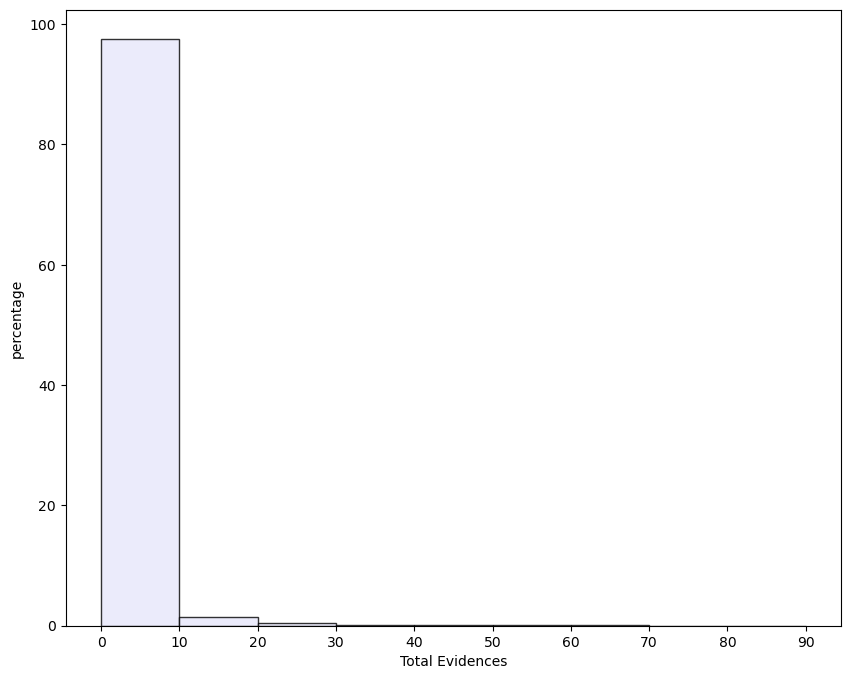

In [77]:
import numpy as np 
import matplotlib.pyplot as plt
var = 'Total Evidences'
p = countPairsEvidences2['totalEvidences']
bins = np.arange(0, 100, 10.0)

plt.figure(figsize=(10,8))
# the histogram of the data
plt.hist(p, bins, alpha=0.8, histtype='bar', color='lavender',
         ec='black',weights=np.zeros_like(p) + 100. / p.size)

plt.xlabel(var)
plt.ylabel('percentage')
plt.xticks(bins)
plt.show()

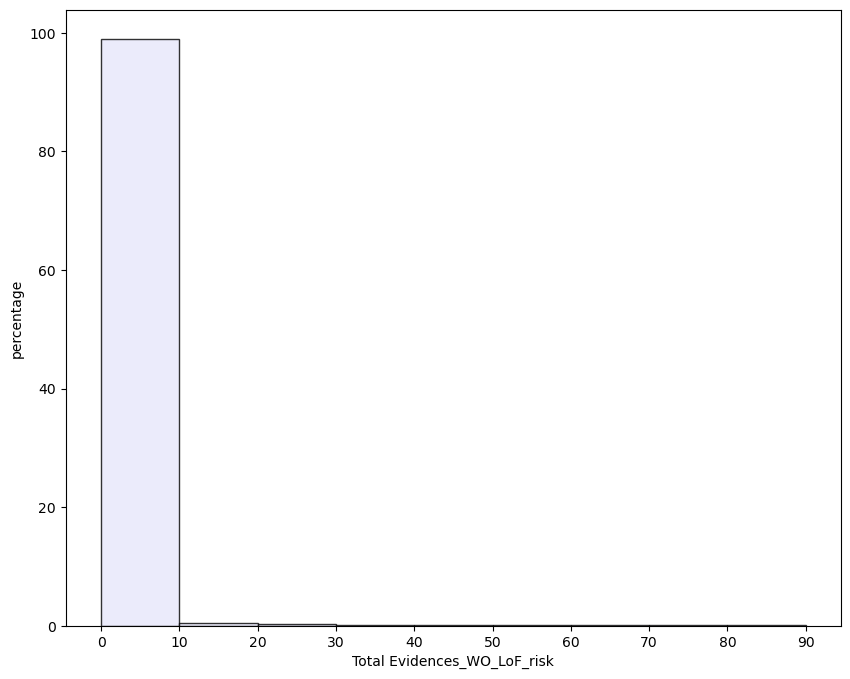

In [ ]:
var = 'Total Evidences_WO_LoF_risk'
p = countPairsEvidences2['totalEvidences_woLR']
bins = np.arange(0, 100, 10.0)

plt.figure(figsize=(10,8))
# the histogram of the data
plt.hist(p, bins, alpha=0.8, histtype='bar', color='lavender',
         ec='black',weights=np.zeros_like(p) + 100. / p.size)

plt.xlabel(var)
plt.ylabel('percentage')
plt.xticks(bins)
plt.show()

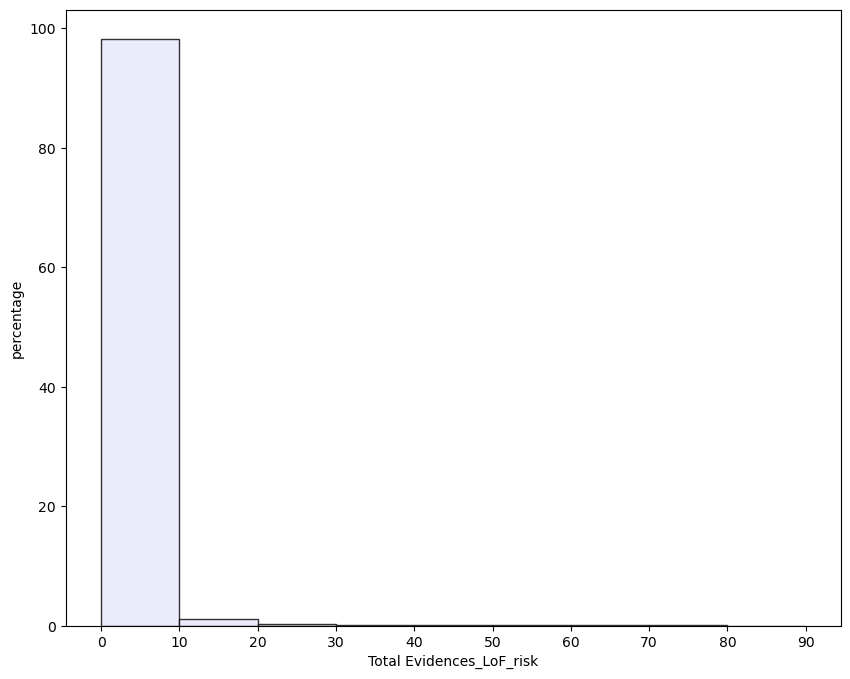

In [ ]:
var = 'Total Evidences_LoF_risk'
p = countPairsEvidences2['LoF_risk']
bins = np.arange(0, 100, 10.0)

plt.figure(figsize=(10,8))
# the histogram of the data
plt.hist(p, bins, alpha=0.8, histtype='bar', color='lavender',
         ec='black',weights=np.zeros_like(p) + 100. / p.size)

plt.xlabel(var)
plt.ylabel('percentage')
plt.xticks(bins)
plt.show()

In [ ]:

countPairsEvidences2.quantile([.25, .5, .75])


/var/folders/21/__kt0v8x593748hpg_k1sx200000gp/T/ipykernel_73088/556046060.py:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  countPairsEvidences2.quantile([.25, .5, .75])


,GoF_risk,LoF_protect,LoF_risk,GoF_protect,totalEvidences,totalEvidences_woLR
0.25,0.0,0.0,1.0,0.0,1.0,0.0
0.50,0.0,0.0,1.0,0.0,1.0,0.0
0.75,0.0,0.0,2.0,0.0,2.0,0.0


In [ ]:
interdatasourcePercentage.toPandas().to_csv('interdatasourcePercentage2.csv')

/opt/anaconda3/envs/python/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [ ]:
interdatasourcePercentage.select("GoF_risk","LoF_protect","LoF_risk","GoF_protect","minoritaryPercentage",'totalEvidences').show()

+--------+-----------+--------+-----------+--------------------+--------------+
|GoF_risk|LoF_protect|LoF_risk|GoF_protect|minoritaryPercentage|totalEvidences|
+--------+-----------+--------+-----------+--------------------+--------------+
|       2|          0|       1|          0|   33.33333333333333|             3|
|       1|          0|       1|          1|                50.0|             3|
|       1|          0|       1|          0|                50.0|             2|
|       0|          2|       0|          3|                40.0|             5|
|       1|          0|       2|          0|   33.33333333333333|             3|
|       0|          3|       4|          0|  42.857142857142854|             7|
|       0|          6|       1|          2|  14.285714285714285|             9|
|       0|          3|       1|          3|                25.0|             7|
|       0|          3|       0|          2|                40.0|             5|
|       0|          2|       1|         

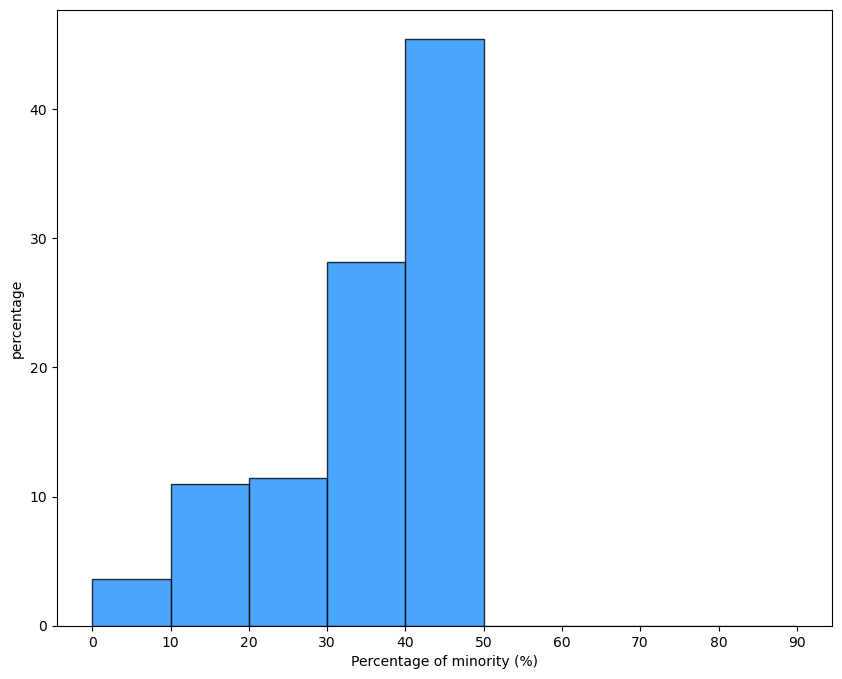

In [88]:
import numpy as np
import matplotlib.pyplot as plt
x0=-1
var = 'Percentage of minority (%)'
x = data['minoritaryPercentage']
bins = np.arange(0, 100 + x0, 10.0)

plt.figure(figsize=(10,8))
# the histogram of the data

plt.hist(x+x0, bins, alpha=0.8, histtype='bar', color='dodgerblue',
         ec='black',weights=np.zeros_like(x) + 100. / x.size)

#plt.hist(x, bins, alpha=0.8, histtype='bar', color='dodgerblue',
#         ec='black',weights=np.zeros_like(x) + 100. / x.size)

plt.xlabel(var)
plt.ylabel('percentage')
plt.xticks(bins)
plt.show()


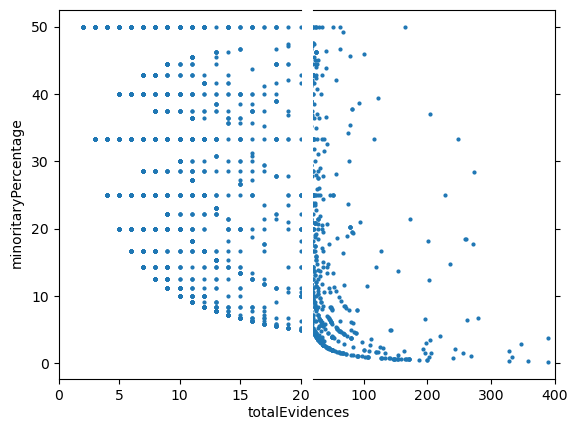

In [ ]:
x=data['totalEvidences']
y=data['minoritaryPercentage']
fig,(ax,ax2) = plt.subplots(1,2,sharey=True, facecolor='w')

ax.scatter(x,y,s=4)
ax2.scatter(x,y,s=4)

ax.set_xlim(0,20)
ax2.set_xlim(20,400)

ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax.yaxis.tick_left()
##ax.tick_params(labeltop='off') # don't put tick labels at the top
ax2.yaxis.tick_right()

# Make the spacing between the two axes a bit smaller
plt.subplots_adjust(wspace=0.05)

fig.text(0.5, 0.04, 'totalEvidences', ha='center', va='center')
fig.text(0.06, 0.5, 'minoritaryPercentage', ha='center', va='center', rotation='vertical')
plt.show()



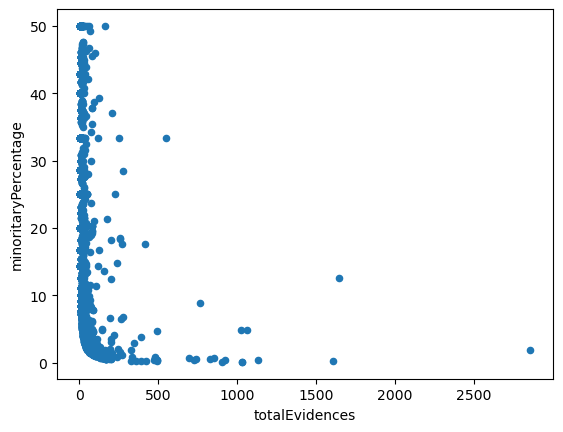

In [86]:
fig = data.plot.scatter(x='totalEvidences', y='minoritaryPercentage')
#fig.update_layout(template="plotly_dark")

In [ ]:
interdatasourcePercentage.groupBy('diseaseId','diseaseName').agg(F.count('targetId'))

In [29]:
coherencyInter_assessed_wOut.count()

783373

In [30]:
interdatasourcePercentage.count()

AttributeError: 'NoneType' object has no attribute 'count'

In [ ]:
coherencyInter_assessed_wOut.groupBy('coherency','filterOut').agg(F.count('targetId')).show()

toprocess_matrix2=(prueba_assessment
.filter(
    (F.col('Assessment').isin(terms)==False))
.groupBy('targetId','diseaseId')
.pivot('datasourceId')
.agg(F.count('targetId')))

+---------+---------+---------------+
|coherency|filterOut|count(targetId)|
+---------+---------+---------------+
|   dispar|      out|          12062|
|   dispar|     keep|           1522|
|     take|     keep|         762208|
| coherent|     keep|           7581|
+---------+---------+---------------+



In [ ]:
### https://stackoverflow.com/questions/69455085/create-item-item-interaction-matrix-in-pyspark

### Stack: create item-item interaction matrix in pyspark 
### 


In [30]:

### make the matrix of coincidences between datasources:
from pyspark.sql.functions import monotonically_increasing_id 


terms=['noEvaluable','bivalent_risk','null','dispar']

tdds=(prueba_assessment ### order target-traits pairs by datasource
.filter(
    (F.col('Assessment').isin(terms)==False))
.groupBy('targetId','diseaseId','datasourceId')
.agg(F.count('targetId'))
.select(F.col('targetId').alias('targetIddd'),
    F.col('diseaseId').alias('diseaseIdddd'),
    F.col('datasourceId')))

 ### multiply every target-trait by every datasource they appear on. 
 # Add an unique ID to identify and count distinctly

analysis=(prueba_assessment
.filter(
    (F.col('Assessment').isin(terms)==False))
.groupBy('targetId','diseaseId')
.agg(F.count('targetId'))
.withColumn('nr',monotonically_increasing_id())
.join(tdds, (F.col('targetId')==tdds.targetIddd) & (F.col('diseaseId')==tdds.diseaseIdddd),'left')
)
analysisdo=analysis.select('targetId','diseaseId','nr','datasourceId')

df_collect = (analysisdo
## user_id = nr
## item_id = datasourceId
        .select("nr", "datasourceId")
        .groupBy("datasourceId")
        .agg(F.collect_set("nr").alias("nrs")))
### Step 2. Cross join df_collect with itself to get all item-item combinations

df_crossjoin = (df_collect
                    .join(df_collect
                            .withColumnRenamed("datasourceId", "datasourceId_y")
                            .withColumnRenamed("nrs", "nrs_y")))
### Step 2. Find user union and intersection and the count

df_ui = (df_crossjoin
                 .withColumn("nrs_union", 
                         F.size((F.array_union("nrs", "nrs_y"))))
                 .withColumn("nrs_intersect", 
                             F.size(F.array_intersect("nrs", "nrs_y"))))
    
### Step 3. Pivot to get item-item matrix

df_matrix_union = (df_ui
                   .groupBy("datasourceId")
                   .pivot("datasourceId_y")
                   .agg(F.first("nrs_union"))
                   .orderBy("datasourceId"))

df_matrix_intrsct = (df_ui
                   .groupBy("datasourceId")
                   .pivot("datasourceId_y")
                   .agg(F.first("nrs_intersect"))
                   .orderBy("datasourceId"))

In [31]:
df_matrix_intrsct.show()

+------------------+------------------+------+-----+-----------+--------------+-----------+------+-------+--------+------------------+
|      datasourceId|cancer_gene_census|chembl|  eva|eva_somatic|gene2phenotype|gene_burden|  impc|intogen|orphanet|ot_genetics_portal|
+------------------+------------------+------+-----+-----------+--------------+-----------+------+-------+--------+------------------+
|cancer_gene_census|             40201|  1418|  103|         67|             8|         63|   351|    668|       2|                35|
|            chembl|              1418| 68915|   88|         20|             3|         34|   709|    151|      11|               188|
|               eva|               103|    88|13041|        139|          1276|        107|  2155|     23|     736|                54|
|       eva_somatic|                67|    20|  139|        379|            24|         18|    70|     35|      10|                 2|
|    gene2phenotype|                 8|     3| 1276|   

In [32]:
toprocess=(prueba_assessment
.filter(
    (F.col('Assessment').isin(terms)==False))
.groupBy('targetId','diseaseId')
.pivot('homogenized')
.agg(F.count('targetId'))
.join(contradictIntra.select('targetId3','diseaseId3','filterOut'),
    (F.col('targetId')==contradictIntra.targetId3) & 
    (F.col('diseaseId')==contradictIntra.diseaseId3)
    ,'left')
.withColumn('filterOut',
    F.when(F.col('filterOut')=='out', F.lit(F.col('filterOut')))
    .otherwise(F.lit('keep')))
)


In [33]:
### Matrix of contradictions per datasource and intradatasource 
###
######
## to construct the matrix of coincidences between datasources we need to get: coherent and dispar. 

## 1) Get pairs target-diseases with label dispar/coherent
toget=['dispar','coherent']
pairs_analysis=(coherencyInter_assessed_wOut
.filter(F.col('coherency').isin(toget))
.withColumnRenamed('targetId','targetId2')
.withColumnRenamed('diseaseId','diseaseId2')
)
testeado=toprocess.join(pairs_analysis, (pairs_analysis.targetId2==F.col('targetId')) & (pairs_analysis.diseaseId2==F.col('diseaseId')), 'right')

#######

toprocess=(prueba_assessment
.filter(
    (F.col('Assessment').isin(terms)==False))
.groupBy('targetId','diseaseId')
.pivot('homogenized')
.agg(F.count('targetId'))
.join(contradictIntra.select('targetId3','diseaseId3','filterOut'),
    (F.col('targetId')==contradictIntra.targetId3) & 
    (F.col('diseaseId')==contradictIntra.diseaseId3)
    ,'left')
.withColumn('filterOut2',
    F.when(F.col('filterOut')=='out', F.lit(F.col('filterOut')))
    .otherwise(F.lit('keep')))
.drop('filterOut')

)

pairs_analysis=(coherencyInter_assessed_wOut
.filter(F.col('coherency').isin(toget))
.withColumnRenamed('targetId','targetId2')
.withColumnRenamed('diseaseId','diseaseId2')
)
testeado=toprocess.join(pairs_analysis, (pairs_analysis.targetId2==F.col('targetId')) & (pairs_analysis.diseaseId2==F.col('diseaseId')), 'right')

allcontradict_coherent=(testeado
.filter( 
    (F.col('coherency')=='dispar') & (F.col('filterOut')=='out') | 
    (F.col('coherency')=='dispar') & (F.col('filterOut')=='keep') | 
    (F.col('coherency')=='coherent') & (F.col('filterOut')=='keep'))
.select('targetId','diseaseId')
.withColumn('nr',monotonically_increasing_id())
.join(tdds, (F.col('targetId')==tdds.targetIddd) & (F.col('diseaseId')==tdds.diseaseIdddd),'left')
.select('targetId','diseaseId','nr','datasourceId'))


#### make the pipeline 



df_collect = (allcontradict_coherent
## user_id = nr
## item_id = datasourceId
        .select("nr", "datasourceId")
        .groupBy("datasourceId")
        .agg(F.collect_set("nr").alias("nrs")))
### Step 2. Cross join df_collect with itself to get all item-item combinations

df_crossjoin = (df_collect
                    .join(df_collect
                            .withColumnRenamed("datasourceId", "datasourceId_y")
                            .withColumnRenamed("nrs", "nrs_y")))
### Step 2. Find user union and intersection and the count

df_ui = (df_crossjoin
                 .withColumn("nrs_union", 
                         F.size((F.array_union("nrs", "nrs_y"))))
                 .withColumn("nrs_intersect", 
                             F.size(F.array_intersect("nrs", "nrs_y"))))
    
### Step 3. Pivot to get item-item matrix

df_matrix_union = (df_ui
                   .groupBy("datasourceId")
                   .pivot("datasourceId_y")
                   .agg(F.first("nrs_union"))
                   .orderBy("datasourceId"))

df_matrix_intrsct = (df_ui
                   .groupBy("datasourceId")
                   .pivot("datasourceId_y")
                   .agg(F.first("nrs_intersect"))
                   .orderBy("datasourceId"))

In [34]:
### Matrix of contradictions per datasource and intradatasource <<removing COHERENT>>

allcontradict_WOcoherent=(testeado
.filter( 
    (F.col('coherency')=='dispar') & (F.col('filterOut')=='out') | 
    (F.col('coherency')=='dispar') & (F.col('filterOut')=='keep')
    ## | (F.col('coherency')=='coherent') & (F.col('filterOut')=='keep')
    )
.select('targetId','diseaseId')
.withColumn('nr',monotonically_increasing_id())
.join(tdds, (F.col('targetId')==tdds.targetIddd) & (F.col('diseaseId')==tdds.diseaseIdddd),'left')
.select('targetId','diseaseId','nr','datasourceId'))


#### make the pipeline 

df_collect = (allcontradict_WOcoherent
## user_id = nr
## item_id = datasourceId
        .select("nr", "datasourceId")
        .groupBy("datasourceId")
        .agg(F.collect_set("nr").alias("nrs")))
### Step 2. Cross join df_collect with itself to get all item-item combinations

df_crossjoin = (df_collect
                    .join(df_collect
                            .withColumnRenamed("datasourceId", "datasourceId_y")
                            .withColumnRenamed("nrs", "nrs_y")))
### Step 2. Find user union and intersection and the count

df_ui = (df_crossjoin
                 .withColumn("nrs_union", 
                         F.size((F.array_union("nrs", "nrs_y"))))
                 .withColumn("nrs_intersect", 
                             F.size(F.array_intersect("nrs", "nrs_y"))))
    
### Step 3. Pivot to get item-item matrix

df_matrix_union = (df_ui
                   .groupBy("datasourceId")
                   .pivot("datasourceId_y")
                   .agg(F.first("nrs_union"))
                   .orderBy("datasourceId"))

df_matrix_intrsct_alldispar = (df_ui
                   .groupBy("datasourceId")
                   .pivot("datasourceId_y")
                   .agg(F.first("nrs_intersect"))
                   .orderBy("datasourceId"))

In [35]:
### Matrix of ONLY <contradictions per datasource>> and intradatasource <<removing COHERENT and INTRAdatasource. 

allcontradict_WOcoherentWOintradata=(testeado
.filter( 
    (F.col('coherency')=='dispar') & (F.col('filterOut')=='keep') 
    ## | (F.col('coherency')=='dispar') & (F.col('filterOut')=='keep')
    ## | (F.col('coherency')=='coherent') & (F.col('filterOut')=='keep')
    )
.select('targetId','diseaseId')
.withColumn('nr',monotonically_increasing_id())
.join(tdds, (F.col('targetId')==tdds.targetIddd) & (F.col('diseaseId')==tdds.diseaseIdddd),'left')
.select('targetId','diseaseId','nr','datasourceId'))


#### make the pipeline 



df_collect = (allcontradict_WOcoherentWOintradata
## user_id = nr
## item_id = datasourceId
        .select("nr", "datasourceId")
        .groupBy("datasourceId")
        .agg(F.collect_set("nr").alias("nrs")))
### Step 2. Cross join df_collect with itself to get all item-item combinations

df_crossjoin = (df_collect
                    .join(df_collect
                            .withColumnRenamed("datasourceId", "datasourceId_y")
                            .withColumnRenamed("nrs", "nrs_y")))
### Step 2. Find user union and intersection and the count

df_ui = (df_crossjoin
                 .withColumn("nrs_union", 
                         F.size((F.array_union("nrs", "nrs_y"))))
                 .withColumn("nrs_intersect", 
                             F.size(F.array_intersect("nrs", "nrs_y"))))
    
### Step 3. Pivot to get item-item matrix

df_matrix_union = (df_ui
                   .groupBy("datasourceId")
                   .pivot("datasourceId_y")
                   .agg(F.first("nrs_union"))
                   .orderBy("datasourceId"))

df_matrix_intrsct_alldispar_WOintradata = (df_ui
                   .groupBy("datasourceId")
                   .pivot("datasourceId_y")
                   .agg(F.first("nrs_intersect"))
                   .orderBy("datasourceId"))

In [85]:
df_matrix_intrsct_alldispar_WOintradata.toPandas().to_csv('onlyinterdatasource.csv')

In [37]:
testeado.count()

21164

In [38]:
testeado.groupBy('coherency').agg(F.count('targetId')).show()

+---------+---------------+
|coherency|count(targetId)|
+---------+---------------+
|   dispar|          13571|
| coherent|           7593|
+---------+---------------+



In [ ]:
testeado.toPandas().to_csv('testeado.csv')

/opt/anaconda3/envs/python/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [39]:
testeado.groupBy('targetId','diseaseId','filterOut','coherency').agg(F.count('targetId')).groupBy('filterOut','coherency').agg(F.count('targetId')).show()

+---------+---------+---------------+
|filterOut|coherency|count(targetId)|
+---------+---------+---------------+
|     keep|   dispar|           1509|
|      out|   dispar|          12062|
|     keep| coherent|           7593|
+---------+---------+---------------+



In [ ]:
### coincidences matrix for contradictions intra-datasources

import numpy as np
import pyspark.sql.functions as f


cols =  [
 'chembl',
 'eva',
 'gene_burden',
 'ot_genetics_portal']
intra = np.array([
  [contrad_intra.agg(F.count(F.col(x) * F.col(y))).first()[0] if x != y else contrad_intra.agg(F.count(F.col(x))).first()[0] for y in cols] 
  for x in cols
])
intra_datasource_contrad = pd.DataFrame(intra, cols)
intra_datasource_contrad.to_csv('intra_datasource.csv')

terms=['noEvaluable','bivalent_risk']
filtered=(prueba_assessment
.filter(
    (F.col('Assessment').isin(terms)==False)))
df2=filtered.groupBy('targetId','diseaseId').pivot('datasourceId').agg(F.count('targetId').alias('count'))
### este es el bueno!!!! 
import numpy as np
import pyspark.sql.functions as f

cols =  ['cancer_gene_census',
 'chembl',
 'eva',
 'eva_somatic',
 'gene2phenotype',
 'gene_burden',
 'impc',
 'intogen',
 'orphanet',
 'ot_genetics_portal']
res2 = np.array([
  [df2.agg(f.count(f.col(x) * f.col(y))).first()[0] if x != y else df2.agg(f.count(f.col(x))).first()[0] for y in cols] 
  for x in cols
])
res2_ver = pd.DataFrame(res2, cols)
res2_ver.head

## convert from string to array
convert=['chemblIds','targets']
## transform from multiple string to one 
## transform=['adverse_effects_coloc_h4','outcome_trait']

demon=(df2.select(
    # Exploding p-value text:
        *[F.explode_outer(col).alias(col) if col in convert else col for col in df2.columns]
))


In [ ]:
#### Question from David: Which is the percentage of LoF/GoF protection that already have ChEMBL evidence

## 

In [124]:
terms2=['LoF_protect','GoF_protect']


chembl=prueba_assessment.filter( (F.col('datasourceId')=='chembl') & (F.col('Assessment').isin(terms2)))
rest=prueba_assessment.filter( (F.col('datasourceId')!='chembl') & (F.col('Assessment').isin(terms2)))
##& (F.col('Assessment').rlike('protect'))) 

chembl2=chembl.groupBy('targetId','diseaseId').pivot('Assessment').agg(F.count('targetId')).select(F.col('targetId').alias('targetIdC'),F.col('diseaseId').alias('diseaseIdC'),F.col('GoF_protect').alias('gof_chembl'),F.col('LoF_protect').alias('lof_chembl'))
rest2=rest.groupBy('targetId','diseaseId').pivot('Assessment').agg(F.count('targetId')).select(F.col('targetId').alias('targetIdR'),F.col('diseaseId').alias('diseaseIdR'),F.col('GoF_protect').alias('gof_rest'),F.col('LoF_protect').alias('lof_rest'))

crossed=rest2.join(chembl2, (chembl2.targetIdC==F.col('targetIdR')) & (chembl2.diseaseIdC==F.col('diseaseIdR')),'left')

In [129]:
crossed.filter(F.col('targetIdC')!='null').count()

106

In [90]:
restarget=rest.select('targetId')
chembltarget=chembl.select('targetId')

In [44]:
cross=rest_pairs.join(chembl_pairs, (chembl_pairs.targetIdC==F.col('targetIdR')) & (chembl_pairs.diseaseIdC ==F.col('diseaseIdR')), 'left')

In [45]:
cross.groupBy('targetIdR','targetIdC','diseaseIdC','diseaseIdR').agg(F.count('targetIdC'),F.count('targetIdR')).count()

64261

In [52]:
terms=['noEvaluable','bivalent_risk','null','dispar']
columns=[
 ##'GoF_risk',
 'LoF_protect',
 ##'LoF_risk',
 'GoF_protect']

restPairs=(rest
.filter( 
    ##(F.col('Assessment')).isin(terms)==False)
    F.col('Assessment').isin(columns))
.groupBy('targetId','diseaseId')
.pivot('homogenized')
.agg(F.count('targetId'))
.withColumnRenamed('targetId','targetIdR').withColumnRenamed('diseaseId','diseaseIdR'))

chemblPairs=(chembl
.filter( 
    ##(F.col('Assessment')).isin(terms)==False)
    F.col('Assessment').isin(columns))
.groupBy('targetId','diseaseId')
.pivot('homogenized')
.agg(F.count('targetId'))
.withColumnRenamed('targetId','targetIdC').withColumnRenamed('diseaseId','diseaseIdC'))


In [51]:
chemblPairs.count()
cross=restPairs.join(chemblPairs, (F.col('targetIdR')==chemblPairs.targetIdC) & (F.col('diseaseIdR')==chemblPairs.diseaseIdC),'left')

cross2=(cross
.groupBy('targetIdR','diseaseIdR')
.agg(F.count('targetIdR').alias('targetIdRs'),F.count('targetIdC').alias('targetIdCs'))
.withColumn('coincidences',
    F.when(F.col('targetIdCs')==0, F.lit('No'))
    .when(F.col('targetIdCs')==1,F.lit('Yes'))
)
.filter(F.col('coincidences')=='Yes')
.select(F.col('targetIdR').alias('targetIdRc'),F.col('diseaseIdR').alias('diseaseIdRc'))
)

cross3=(cross2
.join(chemblPairs, (chemblPairs.targetIdC==F.col('targetIdRc')) & (chemblPairs.diseaseIdC==F.col('diseaseIdRc')),'left')
.withColumnRenamed('GoF_protect','GoF_protect_chembl')
.withColumnRenamed('LoF_protect','LoF_protect_chembl')
.join(restPairs, (restPairs.targetIdR==F.col('targetIdRc')) & (restPairs.diseaseIdR==F.col('diseaseIdRc')), 'left')
.withColumnRenamed('GoF_protect','GoF_protect_rest')
.withColumnRenamed('LoF_protect','LoF_protect_rest')
)
cross4=cross3.withColumn('assessed_',
F.when(
        (F.col('GoF_protect_chembl').isNull()) &
        (F.col('GoF_protect_rest').isNull()), F.lit('sameDirec'))
.when(
        (F.col('LoF_protect_chembl').isNull()) &
        (F.col('LoF_protect_rest').isNull()), F.lit('sameDirec'))
.otherwise(F.lit('difDirec'))
)

68915

In [89]:
cross4.groupBy('assessed_').agg(F.count('assessed_')).show()

+---------+----------------+
|assessed_|count(assessed_)|
+---------+----------------+
| difDirec|              39|
|sameDirec|              67|
+---------+----------------+



In [109]:
restarget=rest.select('targetId')
chembltarget=chembl.select('targetId').withColumnRenamed('targetId','targetIdCtest')

check_targets=restarget.join(chembltarget,chembltarget.targetIdCtest==F.col('targetId'),'left').dropDuplicates()
check_targets.withColumn('coincidence', F.when(F.col('targetIdCtest') == F.col('targetId'), F.lit('yes')).otherwise(F.lit('No'))).groupBy('coincidence').agg(F.count('coincidence')).show()

+-----------+------------------+
|coincidence|count(coincidence)|
+-----------+------------------+
|         No|             17598|
|        yes|              1438|
+-----------+------------------+



In [108]:
restrait=rest.select('diseaseId')
chembltrait=chembl.select('diseaseId').withColumnRenamed('diseaseId','diseaseIdCtest')

check_traits=restrait.join(chembltrait,chembltrait.diseaseIdCtest==F.col('diseaseId'), 'left').dropDuplicates()

(check_traits
.withColumn('coincidence', 
    F.when(F.col('diseaseIdCtest') == F.col('diseaseId'), F.lit('yes'))
    .otherwise(F.lit('No')))
.groupBy('coincidence')
.agg(F.count('coincidence'))).show()

+-----------+------------------+
|coincidence|count(coincidence)|
+-----------+------------------+
|         No|             10565|
|        yes|              1829|
+-----------+------------------+



In [112]:
### filter by the ones having assessments: 
terms=['noEvaluable','bivalent_risk','null','dispar']
terms2=['LoF_protect','GoF_protect']
restarget_filt=rest.filter(F.col('Assessment').isin(terms2)).select('targetId')
chembltarget_filt=chembl.filter(F.col('Assessment').isin(terms2)).select('targetId').withColumnRenamed('targetId','targetIdCtest')

check_targets_filt=restarget_filt.join(chembltarget_filt,chembltarget_filt.targetIdCtest==F.col('targetId'),'left').dropDuplicates()
check_targets_filt.withColumn('coincidence', F.when(F.col('targetIdCtest') == F.col('targetId'), F.lit('yes')).otherwise(F.lit('No'))).groupBy('coincidence').agg(F.count('coincidence')).show()

+-----------+------------------+
|coincidence|count(coincidence)|
+-----------+------------------+
|         No|             10831|
|        yes|               928|
+-----------+------------------+



In [114]:
### filter by the ones having assessments: 
terms=['noEvaluable','bivalent_risk','null','dispar']
terms2=['LoF_protect','GoF_protect']
restrait_filt=rest.filter(F.col('Assessment').isin(terms2)).select('diseaseId')
chembltrait_filt=chembl.filter(F.col('Assessment').isin(terms2)).select('diseaseId').withColumnRenamed('diseaseId','diseaseIdCtest')

check_traits_filt=restrait_filt.join(chembltrait_filt,chembltrait_filt.diseaseIdCtest==F.col('diseaseId'), 'left').dropDuplicates()

(check_traits_filt
.withColumn('coincidence', 
    F.when(F.col('diseaseIdCtest') == F.col('diseaseId'), F.lit('yes'))
    .otherwise(F.lit('No')))
.groupBy('coincidence')
.agg(F.count('coincidence'))).show()

+-----------+------------------+
|coincidence|count(coincidence)|
+-----------+------------------+
|         No|               551|
|        yes|               314|
+-----------+------------------+



In [137]:
testing=prueba_assessment.filter(F.col('Assessment').isin(terms2)).groupBy('targetId','diseaseId').pivot('datasourceId').agg(F.count('targetId'))
testing.show()

+---------------+-------------+------+----+-----------+------------------+
|       targetId|    diseaseId|chembl| eva|gene_burden|ot_genetics_portal|
+---------------+-------------+------+----+-----------+------------------+
|ENSG00000100347|  EFO_0004530|  null|null|       null|                 2|
|ENSG00000183549|  EFO_0004995|  null|null|       null|                 6|
|ENSG00000122545|  EFO_0007989|  null|null|       null|                 1|
|ENSG00000205423|  EFO_0005409|  null|null|       null|                 1|
|ENSG00000165355|  EFO_0004309|  null|null|       null|                 2|
|ENSG00000178209|  EFO_0004995|  null|null|       null|                 4|
|ENSG00000139641|  EFO_0004338|  null|null|       null|                 2|
|ENSG00000121210|  EFO_0004584|  null|null|       null|                 3|
|ENSG00000110243|  EFO_0020064|  null|null|       null|                 1|
|ENSG00000138246|  EFO_0004528|  null|null|       null|                 4|
|ENSG00000143630|  EFO_00

In [143]:
testing.filter( 
    (F.col('chembl').isNotNull()) &
    ((F.col('eva').isNotNull()) | (F.col('gene_burden').isNotNull()) | (F.col('ot_genetics_portal').isNotNull()))).count()

106

In [ ]:

coherency_assessed=(coherency_toAssess
.select(
    F.col('targetId').alias('targetId3'),
    F.col('datasourceId').alias('datasourceId3'),
    F.col('diseaseId').alias('diseaseId3'),
    *(F.col(c).cast("int").alias(c) for c in columns))

.withColumn('coherency',
    F.when(
        (
        (F.col('GoF_risk').isNotNull()) &
        (F.col('LoF_risk').isNotNull())
        ),
            F.when(
                (F.col('GoF_risk'))-(F.col('LoF_risk'))!=(F.col('GoF_risk'))
                ,F.lit('dispar'))
        )
    .when(
        (
        (F.col('LoF_protect').isNotNull()) &
        (F.col('LoF_risk').isNotNull())
        ),
            F.when(
                (F.col('LoF_protect'))-(F.col('LoF_risk'))!=(F.col('LoF_protect'))
                ,F.lit('dispar'))
        )   
    .when(
        (
        (F.col('GoF_protect').isNotNull()) &
        (F.col('GoF_risk').isNotNull())
        ),
            F.when(
                (F.col('GoF_protect'))-(F.col('GoF_risk'))!=(F.col('GoF_protect'))
                ,F.lit('dispar'))
        )   
    .when(
        (
        (F.col('GoF_protect').isNotNull()) &
        (F.col('LoF_protect').isNotNull())
        ),
            F.when(
                (F.col('GoF_protect'))-(F.col('LoF_protect'))!=(F.col('GoF_protect'))
                ,F.lit('dispar'))
        )      
        
        ))

In [ ]:
### Incluir los datos de diseaseFromSource en el analisis de las contradicciones 
### 
### 
### 

In [40]:
### make percentage of diseases
uno=(coherencyInter_assessed_wOut
.groupBy('diseaseId')
.pivot('coherency')
.agg(F.count('targetId'))

.withColumn('percentageTrue',
    F.lit(F.col('take')/762208*100))
.withColumn('percentageContradic',
    F.lit(F.col('dispar')/13584*100))
.withColumn('suspicious',
    F.when(F.col('percentageContradic')>F.col('percentageTrue'),F.lit('suspicious'))
    .when(F.col('percentageContradic')<=F.col('percentageTrue'),F.lit('nonSuspicious')))
.withColumn('foldChange',
    F.when(F.col('suspicious')=='suspicious', F.lit(F.col('percentageContradic')/F.col('percentageTrue')))
))
###.toPandas().to_csv('percentages.csv')


In [61]:
### calculate again 'coherencyInter_assessed_wOut' incluyendo los diseaseFromSource 

### 

### Include the calculation of overlapping
terms=['noEvaluable','bivalent_risk','null','dispar']
#### reminder of 'toprocess': 
toprocess_contrad=(prueba_assessment
.filter(
    (F.col('Assessment').isin(terms)==False))
.groupBy(
    'targetId',
    'diseaseId',
    ### 'diseaseFromSource'
    ##'datasourceId'
    )
.pivot('homogenized')
.agg(F.count('targetId'))
.join(contradictIntra.select('targetId3','diseaseId3','filterOut'),
    (F.col('targetId')==contradictIntra.targetId3) & 
    (F.col('diseaseId')==contradictIntra.diseaseId3)
    ,'left')
.withColumn('filterOut',
    F.when(F.col('filterOut')=='out', F.lit(F.col('filterOut')))
    .otherwise(F.lit('keep'))))
##### 

columns=[
 'GoF_risk',
 'LoF_protect',
 'LoF_risk',
 'GoF_protect']

coherencyInter_assessed_wOut_contrad=(toprocess_contrad
##.filter(F.col('filterOut')!='out')
.select(
    F.col('targetId'),#.alias('targetId3'),
    F.col('diseaseId'),
    ### F.col('diseaseFromSourceId'),
    ###F.col('diseaseFromSource'),
    ### F.col('datasourceId'),
    F.col('filterOut'),
    *(F.col(c).cast("int").alias(c) for c in columns))

.withColumn('coherency',
    F.when(
        (
        (F.col('GoF_risk').isNotNull()) &
        (F.col('LoF_risk').isNotNull())
        ),
            F.when(
                (F.col('GoF_risk'))-(F.col('LoF_risk'))!=(F.col('GoF_risk'))
                ,F.lit('dispar'))
        )
    .when(
        (
        (F.col('LoF_protect').isNotNull()) &
        (F.col('LoF_risk').isNotNull())
        ),
            F.when(
                (F.col('LoF_protect'))-(F.col('LoF_risk'))!=(F.col('LoF_protect'))
                ,F.lit('dispar'))
        )   
    .when(
        (
        (F.col('GoF_protect').isNotNull()) &
        (F.col('GoF_risk').isNotNull())
        ),
            F.when(
                (F.col('GoF_protect'))-(F.col('GoF_risk'))!=(F.col('GoF_protect'))
                ,F.lit('dispar'))
        )   
    .when(
        (
        (F.col('GoF_protect').isNotNull()) &
        (F.col('LoF_protect').isNotNull())
        ),
            F.when(
                (F.col('GoF_protect'))-(F.col('LoF_protect'))!=(F.col('GoF_protect'))
                ,F.lit('dispar'))
        )      
    .when(
        (
        (F.col('GoF_protect').isNotNull()) &
        (F.col('LoF_risk').isNotNull())
        ),
            F.when(
                (F.col('GoF_protect'))-(F.col('LoF_risk'))!=(F.col('GoF_protect'))
                ,F.lit('coherent'))
    )      
    .when(
        (
        (F.col('LoF_protect').isNotNull()) &
        (F.col('GoF_risk').isNotNull())
        ),
            F.when(
                (F.col('LoF_protect'))-(F.col('GoF_risk'))!=(F.col('LoF_protect'))
                ,F.lit('coherent'))
        )   
    .otherwise(F.lit('take')))
)


### add disease name 
coherencyInter_assessed_wOut_contrad2=(coherencyInter_assessed_wOut_contrad
.join(diseases
    .select('id','name'), diseases.id==F.col('diseaseId'),'left'))


### continue here: 22.02.2023
### define columns for the next steps
columnsX=['targetId', 'diseaseId',  'diseaseFromSource', 'filterOut','coherency', 'id', 'name']


probando=coherencyInter_assessed_wOut_contrad2.select(*(F.col(c).alias(c) for c in columnsX), F.struct('GoF_risk', 'LoF_protect', 'LoF_risk', 'GoF_protect').alias('values'))


## The next is to make the struct for collect_set of disease from source para saber de donde viene cada uno. O deberia hacerlo mas granular?? 
## Find the percentage of assessments for every target-disease pairs that are contradictory and split them by ‘diseaseFromSource’ -


AnalysisException: Column 'diseaseFromSource' does not exist. Did you mean one of the following? [diseaseId, filterOut, GoF_protect, LoF_protect, coherency, name, targetId, GoF_risk, LoF_risk, id];
'Project [targetId#72 AS targetId#2154227, diseaseId#148 AS diseaseId#2154228, 'diseaseFromSource AS diseaseFromSource#2154229, filterOut#2154175 AS filterOut#2154230, coherency#2154196 AS coherency#2154231, id#2367 AS id#2154232, name#2371 AS name#2154233, struct(GoF_risk, GoF_risk#2154185, LoF_protect, LoF_protect#2154186, LoF_risk, LoF_risk#2154187, GoF_protect, GoF_protect#2154188) AS values#2154234]
+- Join LeftOuter, (id#2367 = diseaseId#148)
   :- Project [targetId#72, diseaseId#148, filterOut#2154175, GoF_risk#2154185, LoF_protect#2154186, LoF_risk#2154187, GoF_protect#2154188, CASE WHEN (isnotnull(GoF_risk#2154185) AND isnotnull(LoF_risk#2154187)) THEN CASE WHEN NOT ((GoF_risk#2154185 - LoF_risk#2154187) = GoF_risk#2154185) THEN dispar END WHEN (isnotnull(LoF_protect#2154186) AND isnotnull(LoF_risk#2154187)) THEN CASE WHEN NOT ((LoF_protect#2154186 - LoF_risk#2154187) = LoF_protect#2154186) THEN dispar END WHEN (isnotnull(GoF_protect#2154188) AND isnotnull(GoF_risk#2154185)) THEN CASE WHEN NOT ((GoF_protect#2154188 - GoF_risk#2154185) = GoF_protect#2154188) THEN dispar END WHEN (isnotnull(GoF_protect#2154188) AND isnotnull(LoF_protect#2154186)) THEN CASE WHEN NOT ((GoF_protect#2154188 - LoF_protect#2154186) = GoF_protect#2154188) THEN dispar END WHEN (isnotnull(GoF_protect#2154188) AND isnotnull(LoF_risk#2154187)) THEN CASE WHEN NOT ((GoF_protect#2154188 - LoF_risk#2154187) = GoF_protect#2154188) THEN coherent END WHEN (isnotnull(LoF_protect#2154186) AND isnotnull(GoF_risk#2154185)) THEN CASE WHEN NOT ((LoF_protect#2154186 - GoF_risk#2154185) = LoF_protect#2154186) THEN coherent END ELSE take END AS coherency#2154196]
   :  +- Project [targetId#72, diseaseId#148, filterOut#2154175, cast(GoF_risk#2153286L as int) AS GoF_risk#2154185, cast(LoF_protect#2153287L as int) AS LoF_protect#2154186, cast(LoF_risk#2153288L as int) AS LoF_risk#2154187, cast(GoF_protect#2153285L as int) AS GoF_protect#2154188]
   :     +- Project [targetId#72, diseaseId#148, GoF_protect#2153285L, GoF_risk#2153286L, LoF_protect#2153287L, LoF_risk#2153288L, targetId3#361219, diseaseId3#361221, CASE WHEN (filterOut#515263 = out) THEN filterOut#515263 ELSE keep END AS filterOut#2154175]
   :        +- Join LeftOuter, ((targetId#72 = targetId3#361219) AND (diseaseId#148 = diseaseId3#361221))
   :           :- Project [targetId#72, diseaseId#148, __pivot_count(targetId) AS `count(targetId)`#2153284[0] AS GoF_protect#2153285L, __pivot_count(targetId) AS `count(targetId)`#2153284[1] AS GoF_risk#2153286L, __pivot_count(targetId) AS `count(targetId)`#2153284[2] AS LoF_protect#2153287L, __pivot_count(targetId) AS `count(targetId)`#2153284[3] AS LoF_risk#2153288L]
   :           :  +- Aggregate [targetId#72, diseaseId#148], [targetId#72, diseaseId#148, pivotfirst(homogenized#5572, count(targetId)#2153274L, GoF_protect, GoF_risk, LoF_protect, LoF_risk, 0, 0) AS __pivot_count(targetId) AS `count(targetId)`#2153284]
   :           :     +- Aggregate [targetId#72, diseaseId#148, homogenized#5572], [targetId#72, diseaseId#148, homogenized#5572, count(targetId#72) AS count(targetId)#2153274L]
   :           :        +- Filter (Assessment#5471 IN (noEvaluable,bivalent_risk,null,dispar) = false)
   :           :           +- Project [datasourceId#71, targetId#72, alleleOrigins#73, allelicRequirements#74, ancestry#75, ancestryId#76, beta#4424, betaConfidenceIntervalLower#78, betaConfidenceIntervalUpper#79, biologicalModelAllelicComposition#80, biologicalModelGeneticBackground#81, biologicalModelId#82, biomarkerName#83, biomarkers#84, biosamplesFromSource#85, clinicalPhase#86L, clinicalSignificances#4586, clinicalStatus#88, cohortDescription#89, cohortId#90, cohortPhenotypes#91, cohortShortName#92, confidence#93, contrast#94, ... 76 more fields]
   :           :              +- Project [datasourceId#71, targetId#72, alleleOrigins#73, allelicRequirements#74, ancestry#75, ancestryId#76, beta#4424, betaConfidenceIntervalLower#78, betaConfidenceIntervalUpper#79, biologicalModelAllelicComposition#80, biologicalModelGeneticBackground#81, biologicalModelId#82, biomarkerName#83, biomarkers#84, biosamplesFromSource#85, clinicalPhase#86L, clinicalSignificances#4586, clinicalStatus#88, cohortDescription#89, cohortId#90, cohortPhenotypes#91, cohortShortName#92, confidence#93, contrast#94, ... 75 more fields]
   :           :                 +- Project [datasourceId#71, targetId#72, alleleOrigins#73, allelicRequirements#74, ancestry#75, ancestryId#76, beta#4424, betaConfidenceIntervalLower#78, betaConfidenceIntervalUpper#79, biologicalModelAllelicComposition#80, biologicalModelGeneticBackground#81, biologicalModelId#82, biomarkerName#83, biomarkers#84, biosamplesFromSource#85, clinicalPhase#86L, clinicalSignificances#4586, clinicalStatus#88, cohortDescription#89, cohortId#90, cohortPhenotypes#91, cohortShortName#92, confidence#93, contrast#94, ... 74 more fields]
   :           :                    +- Project [datasourceId#71, targetId#72, alleleOrigins#73, allelicRequirements#74, ancestry#75, ancestryId#76, beta#4424, betaConfidenceIntervalLower#78, betaConfidenceIntervalUpper#79, biologicalModelAllelicComposition#80, biologicalModelGeneticBackground#81, biologicalModelId#82, biomarkerName#83, biomarkers#84, biosamplesFromSource#85, clinicalPhase#86L, clinicalSignificances#4586, clinicalStatus#88, cohortDescription#89, cohortId#90, cohortPhenotypes#91, cohortShortName#92, confidence#93, contrast#94, ... 73 more fields]
   :           :                       +- Join LeftOuter, ((drugId2#2720 = drugId#103) AND (targetId2#2726 = targetId#72))
   :           :                          :- Join LeftOuter, (stMethod#2447 = statisticalMethodOverview#125)
   :           :                          :  :- Join LeftOuter, (target_id#2708 = targetId#72)
   :           :                          :  :  :- Project [datasourceId#71, targetId#72, alleleOrigins#73, allelicRequirements#74, ancestry#75, ancestryId#76, beta#4424, betaConfidenceIntervalLower#78, betaConfidenceIntervalUpper#79, biologicalModelAllelicComposition#80, biologicalModelGeneticBackground#81, biologicalModelId#82, biomarkerName#83, biomarkers#84, biosamplesFromSource#85, clinicalPhase#86L, clinicalSignificances#4586, clinicalStatus#88, cohortDescription#89, cohortId#90, cohortPhenotypes#91, cohortShortName#92, confidence#93, contrast#94, ... 59 more fields]
   :           :                          :  :  :  +- Project [datasourceId#71, targetId#72, alleleOrigins#73, allelicRequirements#74, ancestry#75, ancestryId#76, beta#4424, betaConfidenceIntervalLower#78, betaConfidenceIntervalUpper#79, biologicalModelAllelicComposition#80, biologicalModelGeneticBackground#81, biologicalModelId#82, biomarkerName#83, biomarkers#84, biosamplesFromSource#85, clinicalPhase#86L, clinicalSignificances#4586, clinicalStatus#88, cohortDescription#89, cohortId#90, cohortPhenotypes#91, cohortShortName#92, confidence#93, contrast#94, ... 58 more fields]
   :           :                          :  :  :     +- Project [datasourceId#71, targetId#72, alleleOrigins#73, allelicRequirements#74, ancestry#75, ancestryId#76, beta#4424, betaConfidenceIntervalLower#78, betaConfidenceIntervalUpper#79, biologicalModelAllelicComposition#80, biologicalModelGeneticBackground#81, biologicalModelId#82, biomarkerName#83, biomarkers#84, biosamplesFromSource#85, clinicalPhase#86L, clinicalSignificances#4586, clinicalStatus#88, cohortDescription#89, cohortId#90, cohortPhenotypes#91, cohortShortName#92, confidence#93, contrast#94, ... 57 more fields]
   :           :                          :  :  :        +- Generate explode(mutatedSamples#108), true, [exploded#4668]
   :           :                          :  :  :           +- Project [datasourceId#71, targetId#72, alleleOrigins#73, allelicRequirements#74, ancestry#75, ancestryId#76, beta#4424, betaConfidenceIntervalLower#78, betaConfidenceIntervalUpper#79, biologicalModelAllelicComposition#80, biologicalModelGeneticBackground#81, biologicalModelId#82, biomarkerName#83, biomarkers#84, biosamplesFromSource#85, clinicalPhase#86L, concat_ws(,, clinicalSignificances#87) AS clinicalSignificances#4586, clinicalStatus#88, cohortDescription#89, cohortId#90, cohortPhenotypes#91, cohortShortName#92, confidence#93, contrast#94, ... 56 more fields]
   :           :                          :  :  :              +- Project [datasourceId#71, targetId#72, alleleOrigins#73, allelicRequirements#74, ancestry#75, ancestryId#76, beta#4424, betaConfidenceIntervalLower#78, betaConfidenceIntervalUpper#79, biologicalModelAllelicComposition#80, biologicalModelGeneticBackground#81, biologicalModelId#82, biomarkerName#83, biomarkers#84, biosamplesFromSource#85, clinicalPhase#86L, clinicalSignificances#87, clinicalStatus#88, cohortDescription#89, cohortId#90, cohortPhenotypes#91, cohortShortName#92, confidence#93, contrast#94, ... 56 more fields]
   :           :                          :  :  :                 +- Project [datasourceId#71, targetId#72, alleleOrigins#73, allelicRequirements#74, ancestry#75, ancestryId#76, cast(beta#77 as float) AS beta#4424, betaConfidenceIntervalLower#78, betaConfidenceIntervalUpper#79, biologicalModelAllelicComposition#80, biologicalModelGeneticBackground#81, biologicalModelId#82, biomarkerName#83, biomarkers#84, biosamplesFromSource#85, clinicalPhase#86L, clinicalSignificances#87, clinicalStatus#88, cohortDescription#89, cohortId#90, cohortPhenotypes#91, cohortShortName#92, confidence#93, contrast#94, ... 56 more fields]
   :           :                          :  :  :                    +- Union false, false
   :           :                          :  :  :                       :- Relation [datasourceId#71,targetId#72,alleleOrigins#73,allelicRequirements#74,ancestry#75,ancestryId#76,beta#77,betaConfidenceIntervalLower#78,betaConfidenceIntervalUpper#79,biologicalModelAllelicComposition#80,biologicalModelGeneticBackground#81,biologicalModelId#82,biomarkerName#83,biomarkers#84,biosamplesFromSource#85,clinicalPhase#86L,clinicalSignificances#87,clinicalStatus#88,cohortDescription#89,cohortId#90,cohortPhenotypes#91,cohortShortName#92,confidence#93,contrast#94,... 56 more fields] parquet
   :           :                          :  :  :                       :- Project [datasourceId#231, targetId#232, alleleOrigins#233, allelicRequirements#234, ancestry#235, ancestryId#236, beta#237, betaConfidenceIntervalLower#238, betaConfidenceIntervalUpper#239, biologicalModelAllelicComposition#240, biologicalModelGeneticBackground#241, biologicalModelId#242, biomarkerName#243, biomarkers#244, biosamplesFromSource#245, clinicalPhase#246L, clinicalSignificances#247, clinicalStatus#248, cohortDescription#249, cohortId#250, cohortPhenotypes#251, cohortShortName#252, confidence#253, contrast#254, ... 56 more fields]
   :           :                          :  :  :                       :  +- Relation [datasourceId#231,targetId#232,alleleOrigins#233,allelicRequirements#234,ancestry#235,ancestryId#236,beta#237,betaConfidenceIntervalLower#238,betaConfidenceIntervalUpper#239,biologicalModelAllelicComposition#240,biologicalModelGeneticBackground#241,biologicalModelId#242,biomarkerName#243,biomarkers#244,biosamplesFromSource#245,clinicalPhase#246L,clinicalSignificances#247,clinicalStatus#248,cohortDescription#249,cohortId#250,cohortPhenotypes#251,cohortShortName#252,confidence#253,contrast#254,... 56 more fields] parquet
   :           :                          :  :  :                       :- Project [datasourceId#391, targetId#392, alleleOrigins#393, allelicRequirements#394, ancestry#395, ancestryId#396, beta#397, betaConfidenceIntervalLower#398, betaConfidenceIntervalUpper#399, biologicalModelAllelicComposition#400, biologicalModelGeneticBackground#401, biologicalModelId#402, biomarkerName#403, biomarkers#404, biosamplesFromSource#405, clinicalPhase#406L, clinicalSignificances#407, clinicalStatus#408, cohortDescription#409, cohortId#410, cohortPhenotypes#411, cohortShortName#412, confidence#413, contrast#414, ... 56 more fields]
   :           :                          :  :  :                       :  +- Relation [datasourceId#391,targetId#392,alleleOrigins#393,allelicRequirements#394,ancestry#395,ancestryId#396,beta#397,betaConfidenceIntervalLower#398,betaConfidenceIntervalUpper#399,biologicalModelAllelicComposition#400,biologicalModelGeneticBackground#401,biologicalModelId#402,biomarkerName#403,biomarkers#404,biosamplesFromSource#405,clinicalPhase#406L,clinicalSignificances#407,clinicalStatus#408,cohortDescription#409,cohortId#410,cohortPhenotypes#411,cohortShortName#412,confidence#413,contrast#414,... 56 more fields] parquet
   :           :                          :  :  :                       :- Project [datasourceId#551, targetId#552, alleleOrigins#553, allelicRequirements#554, ancestry#555, ancestryId#556, beta#557, betaConfidenceIntervalLower#558, betaConfidenceIntervalUpper#559, biologicalModelAllelicComposition#560, biologicalModelGeneticBackground#561, biologicalModelId#562, biomarkerName#563, biomarkers#564, biosamplesFromSource#565, clinicalPhase#566L, clinicalSignificances#567, clinicalStatus#568, cohortDescription#569, cohortId#570, cohortPhenotypes#571, cohortShortName#572, confidence#573, contrast#574, ... 56 more fields]
   :           :                          :  :  :                       :  +- Relation [datasourceId#551,targetId#552,alleleOrigins#553,allelicRequirements#554,ancestry#555,ancestryId#556,beta#557,betaConfidenceIntervalLower#558,betaConfidenceIntervalUpper#559,biologicalModelAllelicComposition#560,biologicalModelGeneticBackground#561,biologicalModelId#562,biomarkerName#563,biomarkers#564,biosamplesFromSource#565,clinicalPhase#566L,clinicalSignificances#567,clinicalStatus#568,cohortDescription#569,cohortId#570,cohortPhenotypes#571,cohortShortName#572,confidence#573,contrast#574,... 56 more fields] parquet
   :           :                          :  :  :                       :- Project [datasourceId#871, targetId#872, alleleOrigins#873, allelicRequirements#874, ancestry#875, ancestryId#876, beta#877, betaConfidenceIntervalLower#878, betaConfidenceIntervalUpper#879, biologicalModelAllelicComposition#880, biologicalModelGeneticBackground#881, biologicalModelId#882, biomarkerName#883, biomarkers#884, biosamplesFromSource#885, clinicalPhase#886L, clinicalSignificances#887, clinicalStatus#888, cohortDescription#889, cohortId#890, cohortPhenotypes#891, cohortShortName#892, confidence#893, contrast#894, ... 56 more fields]
   :           :                          :  :  :                       :  +- Relation [datasourceId#871,targetId#872,alleleOrigins#873,allelicRequirements#874,ancestry#875,ancestryId#876,beta#877,betaConfidenceIntervalLower#878,betaConfidenceIntervalUpper#879,biologicalModelAllelicComposition#880,biologicalModelGeneticBackground#881,biologicalModelId#882,biomarkerName#883,biomarkers#884,biosamplesFromSource#885,clinicalPhase#886L,clinicalSignificances#887,clinicalStatus#888,cohortDescription#889,cohortId#890,cohortPhenotypes#891,cohortShortName#892,confidence#893,contrast#894,... 56 more fields] parquet
   :           :                          :  :  :                       :- Project [datasourceId#1351, targetId#1352, alleleOrigins#1353, allelicRequirements#1354, ancestry#1355, ancestryId#1356, beta#1357, betaConfidenceIntervalLower#1358, betaConfidenceIntervalUpper#1359, biologicalModelAllelicComposition#1360, biologicalModelGeneticBackground#1361, biologicalModelId#1362, biomarkerName#1363, biomarkers#1364, biosamplesFromSource#1365, clinicalPhase#1366L, clinicalSignificances#1367, clinicalStatus#1368, cohortDescription#1369, cohortId#1370, cohortPhenotypes#1371, cohortShortName#1372, confidence#1373, contrast#1374, ... 56 more fields]
   :           :                          :  :  :                       :  +- Relation [datasourceId#1351,targetId#1352,alleleOrigins#1353,allelicRequirements#1354,ancestry#1355,ancestryId#1356,beta#1357,betaConfidenceIntervalLower#1358,betaConfidenceIntervalUpper#1359,biologicalModelAllelicComposition#1360,biologicalModelGeneticBackground#1361,biologicalModelId#1362,biomarkerName#1363,biomarkers#1364,biosamplesFromSource#1365,clinicalPhase#1366L,clinicalSignificances#1367,clinicalStatus#1368,cohortDescription#1369,cohortId#1370,cohortPhenotypes#1371,cohortShortName#1372,confidence#1373,contrast#1374,... 56 more fields] parquet
   :           :                          :  :  :                       :- Project [datasourceId#1671, targetId#1672, alleleOrigins#1673, allelicRequirements#1674, ancestry#1675, ancestryId#1676, beta#1677, betaConfidenceIntervalLower#1678, betaConfidenceIntervalUpper#1679, biologicalModelAllelicComposition#1680, biologicalModelGeneticBackground#1681, biologicalModelId#1682, biomarkerName#1683, biomarkers#1684, biosamplesFromSource#1685, clinicalPhase#1686L, clinicalSignificances#1687, clinicalStatus#1688, cohortDescription#1689, cohortId#1690, cohortPhenotypes#1691, cohortShortName#1692, confidence#1693, contrast#1694, ... 56 more fields]
   :           :                          :  :  :                       :  +- Relation [datasourceId#1671,targetId#1672,alleleOrigins#1673,allelicRequirements#1674,ancestry#1675,ancestryId#1676,beta#1677,betaConfidenceIntervalLower#1678,betaConfidenceIntervalUpper#1679,biologicalModelAllelicComposition#1680,biologicalModelGeneticBackground#1681,biologicalModelId#1682,biomarkerName#1683,biomarkers#1684,biosamplesFromSource#1685,clinicalPhase#1686L,clinicalSignificances#1687,clinicalStatus#1688,cohortDescription#1689,cohortId#1690,cohortPhenotypes#1691,cohortShortName#1692,confidence#1693,contrast#1694,... 56 more fields] parquet
   :           :                          :  :  :                       :- Project [datasourceId#1831, targetId#1832, alleleOrigins#1833, allelicRequirements#1834, ancestry#1835, ancestryId#1836, beta#1837, betaConfidenceIntervalLower#1838, betaConfidenceIntervalUpper#1839, biologicalModelAllelicComposition#1840, biologicalModelGeneticBackground#1841, biologicalModelId#1842, biomarkerName#1843, biomarkers#1844, biosamplesFromSource#1845, clinicalPhase#1846L, clinicalSignificances#1847, clinicalStatus#1848, cohortDescription#1849, cohortId#1850, cohortPhenotypes#1851, cohortShortName#1852, confidence#1853, contrast#1854, ... 56 more fields]
   :           :                          :  :  :                       :  +- Relation [datasourceId#1831,targetId#1832,alleleOrigins#1833,allelicRequirements#1834,ancestry#1835,ancestryId#1836,beta#1837,betaConfidenceIntervalLower#1838,betaConfidenceIntervalUpper#1839,biologicalModelAllelicComposition#1840,biologicalModelGeneticBackground#1841,biologicalModelId#1842,biomarkerName#1843,biomarkers#1844,biosamplesFromSource#1845,clinicalPhase#1846L,clinicalSignificances#1847,clinicalStatus#1848,cohortDescription#1849,cohortId#1850,cohortPhenotypes#1851,cohortShortName#1852,confidence#1853,contrast#1854,... 56 more fields] parquet
   :           :                          :  :  :                       :- Project [datasourceId#1991, targetId#1992, alleleOrigins#1993, allelicRequirements#1994, ancestry#1995, ancestryId#1996, beta#1997, betaConfidenceIntervalLower#1998, betaConfidenceIntervalUpper#1999, biologicalModelAllelicComposition#2000, biologicalModelGeneticBackground#2001, biologicalModelId#2002, biomarkerName#2003, biomarkers#2004, biosamplesFromSource#2005, clinicalPhase#2006L, clinicalSignificances#2007, clinicalStatus#2008, cohortDescription#2009, cohortId#2010, cohortPhenotypes#2011, cohortShortName#2012, confidence#2013, contrast#2014, ... 56 more fields]
   :           :                          :  :  :                       :  +- Relation [datasourceId#1991,targetId#1992,alleleOrigins#1993,allelicRequirements#1994,ancestry#1995,ancestryId#1996,beta#1997,betaConfidenceIntervalLower#1998,betaConfidenceIntervalUpper#1999,biologicalModelAllelicComposition#2000,biologicalModelGeneticBackground#2001,biologicalModelId#2002,biomarkerName#2003,biomarkers#2004,biosamplesFromSource#2005,clinicalPhase#2006L,clinicalSignificances#2007,clinicalStatus#2008,cohortDescription#2009,cohortId#2010,cohortPhenotypes#2011,cohortShortName#2012,confidence#2013,contrast#2014,... 56 more fields] parquet
   :           :                          :  :  :                       +- Project [datasourceId#2151, targetId#2152, alleleOrigins#2153, allelicRequirements#2154, ancestry#2155, ancestryId#2156, beta#2157, betaConfidenceIntervalLower#2158, betaConfidenceIntervalUpper#2159, biologicalModelAllelicComposition#2160, biologicalModelGeneticBackground#2161, biologicalModelId#2162, biomarkerName#2163, biomarkers#2164, biosamplesFromSource#2165, clinicalPhase#2166L, clinicalSignificances#2167, clinicalStatus#2168, cohortDescription#2169, cohortId#2170, cohortPhenotypes#2171, cohortShortName#2172, confidence#2173, contrast#2174, ... 56 more fields]
   :           :                          :  :  :                          +- Relation [datasourceId#2151,targetId#2152,alleleOrigins#2153,allelicRequirements#2154,ancestry#2155,ancestryId#2156,beta#2157,betaConfidenceIntervalLower#2158,betaConfidenceIntervalUpper#2159,biologicalModelAllelicComposition#2160,biologicalModelGeneticBackground#2161,biologicalModelId#2162,biomarkerName#2163,biomarkers#2164,biosamplesFromSource#2165,clinicalPhase#2166L,clinicalSignificances#2167,clinicalStatus#2168,cohortDescription#2169,cohortId#2170,cohortPhenotypes#2171,cohortShortName#2172,confidence#2173,contrast#2174,... 56 more fields] parquet
   :           :                          :  :  +- Project [id#2311 AS target_id#2708, approvedSymbol#2312, description#2693, description_splited#2697, TSorOncogene#2702]
   :           :                          :  :     +- Project [id#2311, approvedSymbol#2312, description#2693, description_splited#2697, CASE WHEN (RLIKE(description_splited#2697, ncogene) AND RLIKE(description_splited#2697, TSG)) THEN bivalent WHEN RLIKE(description_splited#2697, ncogene(\s|$)) THEN oncogene WHEN RLIKE(description_splited#2697, TSG(\s|$)) THEN TSG ELSE noEvaluable END AS TSorOncogene#2702]
   :           :                          :  :        +- Project [id#2311, approvedSymbol#2312, description#2693, concat_ws(,, description#2693) AS description_splited#2697]
   :           :                          :  :           +- Aggregate [id#2311, approvedSymbol#2312], [id#2311, approvedSymbol#2312, collect_set(description#2685, 0, 0) AS description#2693]
   :           :                          :  :              +- Filter description#2685 IN (TSG,oncogene,Oncogene,oncogene,oncogene,TSG,TSG,oncogene,fusion,oncogene,oncogene,fusion)
   :           :                          :  :                 +- Project [id#2311, approvedSymbol#2312, col#2680.description AS description#2685]
   :           :                          :  :                    +- Project [id#2311, approvedSymbol#2312, col#2680]
   :           :                          :  :                       +- Generate explode(hallmarks#2321.attributes), true, [col#2680]
   :           :                          :  :                          +- Relation [id#2311,approvedSymbol#2312,biotype#2313,transcriptIds#2314,canonicalTranscript#2315,canonicalExons#2316,genomicLocation#2317,alternativeGenes#2318,approvedName#2319,go#2320,hallmarks#2321,synonyms#2322,symbolSynonyms#2323,nameSynonyms#2324,functionDescriptions#2325,subcellularLocations#2326,targetClass#2327,obsoleteSymbols#2328,obsoleteNames#2329,constraint#2330,tep#2331,proteinIds#2332,dbXrefs#2333,chemicalProbes#2334,... 4 more fields] parquet
   :           :                          :  +- Project [statisticalMethodOverview#2439 AS stMethod#2447, counts#2440, comment#2441, whatToDo#2442]
   :           :                          :     +- Relation [statisticalMethodOverview#2439,counts#2440,comment#2441,whatToDo#2442] csv
   :           :                          +- Deduplicate [targetId2#2726, drugId2#2720, actionType#2408, mechanismOfAction#2409]
   :           :                             +- Project [targetId2#2726, drugId2#2720, actionType#2408, mechanismOfAction#2409]
   :           :                                +- Generate explode(targets#2413), true, [targetId2#2726]
   :           :                                   +- Project [drugId2#2720, actionType#2408, mechanismOfAction#2409, targets#2413]
   :           :                                      +- Generate explode(chemblIds#2410), true, [drugId2#2720]
   :           :                                         +- Project [chemblIds#2410, actionType#2408, mechanismOfAction#2409, targets#2413]
   :           :                                            +- Relation [actionType#2408,mechanismOfAction#2409,chemblIds#2410,targetName#2411,targetType#2412,targets#2413,references#2414] parquet
   :           +- Project [targetId3#361219, diseaseId3#361221, filterOut#515263]
   :              +- Project [targetId3#361219, diseaseId3#361221, targetId#515249L, datasourceId#515251, size#515257, out AS filterOut#515263]
   :                 +- Sort [size#515257 DESC NULLS LAST], true
   :                    +- Project [targetId3#361219, diseaseId3#361221, targetId#515249L, datasourceId#515251, size(datasourceId#515251, true) AS size#515257]
   :                       +- Aggregate [targetId3#361219, diseaseId3#361221], [targetId3#361219, diseaseId3#361221, count(targetId3#361219) AS targetId#515249L, collect_set(datasourceId3#361220, 0, 0) AS datasourceId#515251]
   :                          +- Filter (coherency#361233 = dispar)
   :                             +- Project [targetId3#361219, datasourceId3#361220, diseaseId3#361221, GoF_risk#361222, LoF_protect#361223, LoF_risk#361224, GoF_protect#361225, CASE WHEN (isnotnull(GoF_risk#361222) AND isnotnull(LoF_risk#361224)) THEN CASE WHEN NOT ((GoF_risk#361222 - LoF_risk#361224) = GoF_risk#361222) THEN dispar END WHEN (isnotnull(LoF_protect#361223) AND isnotnull(LoF_risk#361224)) THEN CASE WHEN NOT ((LoF_protect#361223 - LoF_risk#361224) = LoF_protect#361223) THEN dispar END WHEN (isnotnull(GoF_protect#361225) AND isnotnull(GoF_risk#361222)) THEN CASE WHEN NOT ((GoF_protect#361225 - GoF_risk#361222) = GoF_protect#361225) THEN dispar END WHEN (isnotnull(GoF_protect#361225) AND isnotnull(LoF_protect#361223)) THEN CASE WHEN NOT ((GoF_protect#361225 - LoF_protect#361223) = GoF_protect#361225) THEN dispar END END AS coherency#361233]
   :                                +- Project [targetId#2153307 AS targetId3#361219, datasourceId#2153306 AS datasourceId3#361220, diseaseId#2153383 AS diseaseId3#361221, cast(GoF_risk#361201L as int) AS GoF_risk#361222, cast(LoF_protect#361202L as int) AS LoF_protect#361223, cast(LoF_risk#361203L as int) AS LoF_risk#361224, cast(GoF_protect#361200L as int) AS GoF_protect#361225]
   :                                   +- Project [targetId#2153307, diseaseId#2153383, datasourceId#2153306, __pivot_count(targetId) AS `count(targetId)`#361199[0] AS GoF_protect#361200L, __pivot_count(targetId) AS `count(targetId)`#361199[1] AS GoF_risk#361201L, __pivot_count(targetId) AS `count(targetId)`#361199[2] AS LoF_protect#361202L, __pivot_count(targetId) AS `count(targetId)`#361199[3] AS LoF_risk#361203L]
   :                                      +- Aggregate [targetId#2153307, diseaseId#2153383, datasourceId#2153306], [targetId#2153307, diseaseId#2153383, datasourceId#2153306, pivotfirst(homogenized#5572, count(targetId)#361189L, GoF_protect, GoF_risk, LoF_protect, LoF_risk, 0, 0) AS __pivot_count(targetId) AS `count(targetId)`#361199]
   :                                         +- Aggregate [targetId#2153307, diseaseId#2153383, datasourceId#2153306, homogenized#5572], [targetId#2153307, diseaseId#2153383, datasourceId#2153306, homogenized#5572, count(targetId#2153307) AS count(targetId)#361189L]
   :                                            +- Filter (Assessment#5471 IN (noEvaluable,bivalent_risk,null,dispar) = false)
   :                                               +- Project [datasourceId#2153306, targetId#2153307, alleleOrigins#2153308, allelicRequirements#2153309, ancestry#2153310, ancestryId#2153311, beta#4424, betaConfidenceIntervalLower#2153313, betaConfidenceIntervalUpper#2153314, biologicalModelAllelicComposition#2153315, biologicalModelGeneticBackground#2153316, biologicalModelId#2153317, biomarkerName#2153318, biomarkers#2153319, biosamplesFromSource#2153320, clinicalPhase#2153321L, clinicalSignificances#4586, clinicalStatus#2153323, cohortDescription#2153324, cohortId#2153325, cohortPhenotypes#2153326, cohortShortName#2153327, confidence#2153328, contrast#2153329, ... 76 more fields]
   :                                                  +- Project [datasourceId#2153306, targetId#2153307, alleleOrigins#2153308, allelicRequirements#2153309, ancestry#2153310, ancestryId#2153311, beta#4424, betaConfidenceIntervalLower#2153313, betaConfidenceIntervalUpper#2153314, biologicalModelAllelicComposition#2153315, biologicalModelGeneticBackground#2153316, biologicalModelId#2153317, biomarkerName#2153318, biomarkers#2153319, biosamplesFromSource#2153320, clinicalPhase#2153321L, clinicalSignificances#4586, clinicalStatus#2153323, cohortDescription#2153324, cohortId#2153325, cohortPhenotypes#2153326, cohortShortName#2153327, confidence#2153328, contrast#2153329, ... 75 more fields]
   :                                                     +- Project [datasourceId#2153306, targetId#2153307, alleleOrigins#2153308, allelicRequirements#2153309, ancestry#2153310, ancestryId#2153311, beta#4424, betaConfidenceIntervalLower#2153313, betaConfidenceIntervalUpper#2153314, biologicalModelAllelicComposition#2153315, biologicalModelGeneticBackground#2153316, biologicalModelId#2153317, biomarkerName#2153318, biomarkers#2153319, biosamplesFromSource#2153320, clinicalPhase#2153321L, clinicalSignificances#4586, clinicalStatus#2153323, cohortDescription#2153324, cohortId#2153325, cohortPhenotypes#2153326, cohortShortName#2153327, confidence#2153328, contrast#2153329, ... 74 more fields]
   :                                                        +- Project [datasourceId#2153306, targetId#2153307, alleleOrigins#2153308, allelicRequirements#2153309, ancestry#2153310, ancestryId#2153311, beta#4424, betaConfidenceIntervalLower#2153313, betaConfidenceIntervalUpper#2153314, biologicalModelAllelicComposition#2153315, biologicalModelGeneticBackground#2153316, biologicalModelId#2153317, biomarkerName#2153318, biomarkers#2153319, biosamplesFromSource#2153320, clinicalPhase#2153321L, clinicalSignificances#4586, clinicalStatus#2153323, cohortDescription#2153324, cohortId#2153325, cohortPhenotypes#2153326, cohortShortName#2153327, confidence#2153328, contrast#2153329, ... 73 more fields]
   :                                                           +- Join LeftOuter, ((drugId2#2720 = drugId#2153338) AND (targetId2#2726 = targetId#2153307))
   :                                                              :- Join LeftOuter, (stMethod#2447 = statisticalMethodOverview#2153360)
   :                                                              :  :- Join LeftOuter, (target_id#2708 = targetId#2153307)
   :                                                              :  :  :- Project [datasourceId#2153306, targetId#2153307, alleleOrigins#2153308, allelicRequirements#2153309, ancestry#2153310, ancestryId#2153311, beta#4424, betaConfidenceIntervalLower#2153313, betaConfidenceIntervalUpper#2153314, biologicalModelAllelicComposition#2153315, biologicalModelGeneticBackground#2153316, biologicalModelId#2153317, biomarkerName#2153318, biomarkers#2153319, biosamplesFromSource#2153320, clinicalPhase#2153321L, clinicalSignificances#4586, clinicalStatus#2153323, cohortDescription#2153324, cohortId#2153325, cohortPhenotypes#2153326, cohortShortName#2153327, confidence#2153328, contrast#2153329, ... 59 more fields]
   :                                                              :  :  :  +- Project [datasourceId#2153306, targetId#2153307, alleleOrigins#2153308, allelicRequirements#2153309, ancestry#2153310, ancestryId#2153311, beta#4424, betaConfidenceIntervalLower#2153313, betaConfidenceIntervalUpper#2153314, biologicalModelAllelicComposition#2153315, biologicalModelGeneticBackground#2153316, biologicalModelId#2153317, biomarkerName#2153318, biomarkers#2153319, biosamplesFromSource#2153320, clinicalPhase#2153321L, clinicalSignificances#4586, clinicalStatus#2153323, cohortDescription#2153324, cohortId#2153325, cohortPhenotypes#2153326, cohortShortName#2153327, confidence#2153328, contrast#2153329, ... 58 more fields]
   :                                                              :  :  :     +- Project [datasourceId#2153306, targetId#2153307, alleleOrigins#2153308, allelicRequirements#2153309, ancestry#2153310, ancestryId#2153311, beta#4424, betaConfidenceIntervalLower#2153313, betaConfidenceIntervalUpper#2153314, biologicalModelAllelicComposition#2153315, biologicalModelGeneticBackground#2153316, biologicalModelId#2153317, biomarkerName#2153318, biomarkers#2153319, biosamplesFromSource#2153320, clinicalPhase#2153321L, clinicalSignificances#4586, clinicalStatus#2153323, cohortDescription#2153324, cohortId#2153325, cohortPhenotypes#2153326, cohortShortName#2153327, confidence#2153328, contrast#2153329, ... 57 more fields]
   :                                                              :  :  :        +- Generate explode(mutatedSamples#2153343), true, [exploded#4668]
   :                                                              :  :  :           +- Project [datasourceId#2153306, targetId#2153307, alleleOrigins#2153308, allelicRequirements#2153309, ancestry#2153310, ancestryId#2153311, beta#4424, betaConfidenceIntervalLower#2153313, betaConfidenceIntervalUpper#2153314, biologicalModelAllelicComposition#2153315, biologicalModelGeneticBackground#2153316, biologicalModelId#2153317, biomarkerName#2153318, biomarkers#2153319, biosamplesFromSource#2153320, clinicalPhase#2153321L, concat_ws(,, clinicalSignificances#2153322) AS clinicalSignificances#4586, clinicalStatus#2153323, cohortDescription#2153324, cohortId#2153325, cohortPhenotypes#2153326, cohortShortName#2153327, confidence#2153328, contrast#2153329, ... 56 more fields]
   :                                                              :  :  :              +- Project [datasourceId#2153306, targetId#2153307, alleleOrigins#2153308, allelicRequirements#2153309, ancestry#2153310, ancestryId#2153311, beta#4424, betaConfidenceIntervalLower#2153313, betaConfidenceIntervalUpper#2153314, biologicalModelAllelicComposition#2153315, biologicalModelGeneticBackground#2153316, biologicalModelId#2153317, biomarkerName#2153318, biomarkers#2153319, biosamplesFromSource#2153320, clinicalPhase#2153321L, clinicalSignificances#2153322, clinicalStatus#2153323, cohortDescription#2153324, cohortId#2153325, cohortPhenotypes#2153326, cohortShortName#2153327, confidence#2153328, contrast#2153329, ... 56 more fields]
   :                                                              :  :  :                 +- Project [datasourceId#2153306, targetId#2153307, alleleOrigins#2153308, allelicRequirements#2153309, ancestry#2153310, ancestryId#2153311, cast(beta#2153312 as float) AS beta#4424, betaConfidenceIntervalLower#2153313, betaConfidenceIntervalUpper#2153314, biologicalModelAllelicComposition#2153315, biologicalModelGeneticBackground#2153316, biologicalModelId#2153317, biomarkerName#2153318, biomarkers#2153319, biosamplesFromSource#2153320, clinicalPhase#2153321L, clinicalSignificances#2153322, clinicalStatus#2153323, cohortDescription#2153324, cohortId#2153325, cohortPhenotypes#2153326, cohortShortName#2153327, confidence#2153328, contrast#2153329, ... 56 more fields]
   :                                                              :  :  :                    +- Union false, false
   :                                                              :  :  :                       :- Relation [datasourceId#2153306,targetId#2153307,alleleOrigins#2153308,allelicRequirements#2153309,ancestry#2153310,ancestryId#2153311,beta#2153312,betaConfidenceIntervalLower#2153313,betaConfidenceIntervalUpper#2153314,biologicalModelAllelicComposition#2153315,biologicalModelGeneticBackground#2153316,biologicalModelId#2153317,biomarkerName#2153318,biomarkers#2153319,biosamplesFromSource#2153320,clinicalPhase#2153321L,clinicalSignificances#2153322,clinicalStatus#2153323,cohortDescription#2153324,cohortId#2153325,cohortPhenotypes#2153326,cohortShortName#2153327,confidence#2153328,contrast#2153329,... 56 more fields] parquet
   :                                                              :  :  :                       :- Project [datasourceId#2153386, targetId#2153387, alleleOrigins#2153388, allelicRequirements#2153389, ancestry#2153390, ancestryId#2153391, beta#2153392, betaConfidenceIntervalLower#2153393, betaConfidenceIntervalUpper#2153394, biologicalModelAllelicComposition#2153395, biologicalModelGeneticBackground#2153396, biologicalModelId#2153397, biomarkerName#2153398, biomarkers#2153399, biosamplesFromSource#2153400, clinicalPhase#2153401L, clinicalSignificances#2153402, clinicalStatus#2153403, cohortDescription#2153404, cohortId#2153405, cohortPhenotypes#2153406, cohortShortName#2153407, confidence#2153408, contrast#2153409, ... 56 more fields]
   :                                                              :  :  :                       :  +- Relation [datasourceId#2153386,targetId#2153387,alleleOrigins#2153388,allelicRequirements#2153389,ancestry#2153390,ancestryId#2153391,beta#2153392,betaConfidenceIntervalLower#2153393,betaConfidenceIntervalUpper#2153394,biologicalModelAllelicComposition#2153395,biologicalModelGeneticBackground#2153396,biologicalModelId#2153397,biomarkerName#2153398,biomarkers#2153399,biosamplesFromSource#2153400,clinicalPhase#2153401L,clinicalSignificances#2153402,clinicalStatus#2153403,cohortDescription#2153404,cohortId#2153405,cohortPhenotypes#2153406,cohortShortName#2153407,confidence#2153408,contrast#2153409,... 56 more fields] parquet
   :                                                              :  :  :                       :- Project [datasourceId#2153466, targetId#2153467, alleleOrigins#2153468, allelicRequirements#2153469, ancestry#2153470, ancestryId#2153471, beta#2153472, betaConfidenceIntervalLower#2153473, betaConfidenceIntervalUpper#2153474, biologicalModelAllelicComposition#2153475, biologicalModelGeneticBackground#2153476, biologicalModelId#2153477, biomarkerName#2153478, biomarkers#2153479, biosamplesFromSource#2153480, clinicalPhase#2153481L, clinicalSignificances#2153482, clinicalStatus#2153483, cohortDescription#2153484, cohortId#2153485, cohortPhenotypes#2153486, cohortShortName#2153487, confidence#2153488, contrast#2153489, ... 56 more fields]
   :                                                              :  :  :                       :  +- Relation [datasourceId#2153466,targetId#2153467,alleleOrigins#2153468,allelicRequirements#2153469,ancestry#2153470,ancestryId#2153471,beta#2153472,betaConfidenceIntervalLower#2153473,betaConfidenceIntervalUpper#2153474,biologicalModelAllelicComposition#2153475,biologicalModelGeneticBackground#2153476,biologicalModelId#2153477,biomarkerName#2153478,biomarkers#2153479,biosamplesFromSource#2153480,clinicalPhase#2153481L,clinicalSignificances#2153482,clinicalStatus#2153483,cohortDescription#2153484,cohortId#2153485,cohortPhenotypes#2153486,cohortShortName#2153487,confidence#2153488,contrast#2153489,... 56 more fields] parquet
   :                                                              :  :  :                       :- Project [datasourceId#2153546, targetId#2153547, alleleOrigins#2153548, allelicRequirements#2153549, ancestry#2153550, ancestryId#2153551, beta#2153552, betaConfidenceIntervalLower#2153553, betaConfidenceIntervalUpper#2153554, biologicalModelAllelicComposition#2153555, biologicalModelGeneticBackground#2153556, biologicalModelId#2153557, biomarkerName#2153558, biomarkers#2153559, biosamplesFromSource#2153560, clinicalPhase#2153561L, clinicalSignificances#2153562, clinicalStatus#2153563, cohortDescription#2153564, cohortId#2153565, cohortPhenotypes#2153566, cohortShortName#2153567, confidence#2153568, contrast#2153569, ... 56 more fields]
   :                                                              :  :  :                       :  +- Relation [datasourceId#2153546,targetId#2153547,alleleOrigins#2153548,allelicRequirements#2153549,ancestry#2153550,ancestryId#2153551,beta#2153552,betaConfidenceIntervalLower#2153553,betaConfidenceIntervalUpper#2153554,biologicalModelAllelicComposition#2153555,biologicalModelGeneticBackground#2153556,biologicalModelId#2153557,biomarkerName#2153558,biomarkers#2153559,biosamplesFromSource#2153560,clinicalPhase#2153561L,clinicalSignificances#2153562,clinicalStatus#2153563,cohortDescription#2153564,cohortId#2153565,cohortPhenotypes#2153566,cohortShortName#2153567,confidence#2153568,contrast#2153569,... 56 more fields] parquet
   :                                                              :  :  :                       :- Project [datasourceId#2153626, targetId#2153627, alleleOrigins#2153628, allelicRequirements#2153629, ancestry#2153630, ancestryId#2153631, beta#2153632, betaConfidenceIntervalLower#2153633, betaConfidenceIntervalUpper#2153634, biologicalModelAllelicComposition#2153635, biologicalModelGeneticBackground#2153636, biologicalModelId#2153637, biomarkerName#2153638, biomarkers#2153639, biosamplesFromSource#2153640, clinicalPhase#2153641L, clinicalSignificances#2153642, clinicalStatus#2153643, cohortDescription#2153644, cohortId#2153645, cohortPhenotypes#2153646, cohortShortName#2153647, confidence#2153648, contrast#2153649, ... 56 more fields]
   :                                                              :  :  :                       :  +- Relation [datasourceId#2153626,targetId#2153627,alleleOrigins#2153628,allelicRequirements#2153629,ancestry#2153630,ancestryId#2153631,beta#2153632,betaConfidenceIntervalLower#2153633,betaConfidenceIntervalUpper#2153634,biologicalModelAllelicComposition#2153635,biologicalModelGeneticBackground#2153636,biologicalModelId#2153637,biomarkerName#2153638,biomarkers#2153639,biosamplesFromSource#2153640,clinicalPhase#2153641L,clinicalSignificances#2153642,clinicalStatus#2153643,cohortDescription#2153644,cohortId#2153645,cohortPhenotypes#2153646,cohortShortName#2153647,confidence#2153648,contrast#2153649,... 56 more fields] parquet
   :                                                              :  :  :                       :- Project [datasourceId#2153706, targetId#2153707, alleleOrigins#2153708, allelicRequirements#2153709, ancestry#2153710, ancestryId#2153711, beta#2153712, betaConfidenceIntervalLower#2153713, betaConfidenceIntervalUpper#2153714, biologicalModelAllelicComposition#2153715, biologicalModelGeneticBackground#2153716, biologicalModelId#2153717, biomarkerName#2153718, biomarkers#2153719, biosamplesFromSource#2153720, clinicalPhase#2153721L, clinicalSignificances#2153722, clinicalStatus#2153723, cohortDescription#2153724, cohortId#2153725, cohortPhenotypes#2153726, cohortShortName#2153727, confidence#2153728, contrast#2153729, ... 56 more fields]
   :                                                              :  :  :                       :  +- Relation [datasourceId#2153706,targetId#2153707,alleleOrigins#2153708,allelicRequirements#2153709,ancestry#2153710,ancestryId#2153711,beta#2153712,betaConfidenceIntervalLower#2153713,betaConfidenceIntervalUpper#2153714,biologicalModelAllelicComposition#2153715,biologicalModelGeneticBackground#2153716,biologicalModelId#2153717,biomarkerName#2153718,biomarkers#2153719,biosamplesFromSource#2153720,clinicalPhase#2153721L,clinicalSignificances#2153722,clinicalStatus#2153723,cohortDescription#2153724,cohortId#2153725,cohortPhenotypes#2153726,cohortShortName#2153727,confidence#2153728,contrast#2153729,... 56 more fields] parquet
   :                                                              :  :  :                       :- Project [datasourceId#2153786, targetId#2153787, alleleOrigins#2153788, allelicRequirements#2153789, ancestry#2153790, ancestryId#2153791, beta#2153792, betaConfidenceIntervalLower#2153793, betaConfidenceIntervalUpper#2153794, biologicalModelAllelicComposition#2153795, biologicalModelGeneticBackground#2153796, biologicalModelId#2153797, biomarkerName#2153798, biomarkers#2153799, biosamplesFromSource#2153800, clinicalPhase#2153801L, clinicalSignificances#2153802, clinicalStatus#2153803, cohortDescription#2153804, cohortId#2153805, cohortPhenotypes#2153806, cohortShortName#2153807, confidence#2153808, contrast#2153809, ... 56 more fields]
   :                                                              :  :  :                       :  +- Relation [datasourceId#2153786,targetId#2153787,alleleOrigins#2153788,allelicRequirements#2153789,ancestry#2153790,ancestryId#2153791,beta#2153792,betaConfidenceIntervalLower#2153793,betaConfidenceIntervalUpper#2153794,biologicalModelAllelicComposition#2153795,biologicalModelGeneticBackground#2153796,biologicalModelId#2153797,biomarkerName#2153798,biomarkers#2153799,biosamplesFromSource#2153800,clinicalPhase#2153801L,clinicalSignificances#2153802,clinicalStatus#2153803,cohortDescription#2153804,cohortId#2153805,cohortPhenotypes#2153806,cohortShortName#2153807,confidence#2153808,contrast#2153809,... 56 more fields] parquet
   :                                                              :  :  :                       :- Project [datasourceId#2153866, targetId#2153867, alleleOrigins#2153868, allelicRequirements#2153869, ancestry#2153870, ancestryId#2153871, beta#2153872, betaConfidenceIntervalLower#2153873, betaConfidenceIntervalUpper#2153874, biologicalModelAllelicComposition#2153875, biologicalModelGeneticBackground#2153876, biologicalModelId#2153877, biomarkerName#2153878, biomarkers#2153879, biosamplesFromSource#2153880, clinicalPhase#2153881L, clinicalSignificances#2153882, clinicalStatus#2153883, cohortDescription#2153884, cohortId#2153885, cohortPhenotypes#2153886, cohortShortName#2153887, confidence#2153888, contrast#2153889, ... 56 more fields]
   :                                                              :  :  :                       :  +- Relation [datasourceId#2153866,targetId#2153867,alleleOrigins#2153868,allelicRequirements#2153869,ancestry#2153870,ancestryId#2153871,beta#2153872,betaConfidenceIntervalLower#2153873,betaConfidenceIntervalUpper#2153874,biologicalModelAllelicComposition#2153875,biologicalModelGeneticBackground#2153876,biologicalModelId#2153877,biomarkerName#2153878,biomarkers#2153879,biosamplesFromSource#2153880,clinicalPhase#2153881L,clinicalSignificances#2153882,clinicalStatus#2153883,cohortDescription#2153884,cohortId#2153885,cohortPhenotypes#2153886,cohortShortName#2153887,confidence#2153888,contrast#2153889,... 56 more fields] parquet
   :                                                              :  :  :                       :- Project [datasourceId#2153946, targetId#2153947, alleleOrigins#2153948, allelicRequirements#2153949, ancestry#2153950, ancestryId#2153951, beta#2153952, betaConfidenceIntervalLower#2153953, betaConfidenceIntervalUpper#2153954, biologicalModelAllelicComposition#2153955, biologicalModelGeneticBackground#2153956, biologicalModelId#2153957, biomarkerName#2153958, biomarkers#2153959, biosamplesFromSource#2153960, clinicalPhase#2153961L, clinicalSignificances#2153962, clinicalStatus#2153963, cohortDescription#2153964, cohortId#2153965, cohortPhenotypes#2153966, cohortShortName#2153967, confidence#2153968, contrast#2153969, ... 56 more fields]
   :                                                              :  :  :                       :  +- Relation [datasourceId#2153946,targetId#2153947,alleleOrigins#2153948,allelicRequirements#2153949,ancestry#2153950,ancestryId#2153951,beta#2153952,betaConfidenceIntervalLower#2153953,betaConfidenceIntervalUpper#2153954,biologicalModelAllelicComposition#2153955,biologicalModelGeneticBackground#2153956,biologicalModelId#2153957,biomarkerName#2153958,biomarkers#2153959,biosamplesFromSource#2153960,clinicalPhase#2153961L,clinicalSignificances#2153962,clinicalStatus#2153963,cohortDescription#2153964,cohortId#2153965,cohortPhenotypes#2153966,cohortShortName#2153967,confidence#2153968,contrast#2153969,... 56 more fields] parquet
   :                                                              :  :  :                       +- Project [datasourceId#2154026, targetId#2154027, alleleOrigins#2154028, allelicRequirements#2154029, ancestry#2154030, ancestryId#2154031, beta#2154032, betaConfidenceIntervalLower#2154033, betaConfidenceIntervalUpper#2154034, biologicalModelAllelicComposition#2154035, biologicalModelGeneticBackground#2154036, biologicalModelId#2154037, biomarkerName#2154038, biomarkers#2154039, biosamplesFromSource#2154040, clinicalPhase#2154041L, clinicalSignificances#2154042, clinicalStatus#2154043, cohortDescription#2154044, cohortId#2154045, cohortPhenotypes#2154046, cohortShortName#2154047, confidence#2154048, contrast#2154049, ... 56 more fields]
   :                                                              :  :  :                          +- Relation [datasourceId#2154026,targetId#2154027,alleleOrigins#2154028,allelicRequirements#2154029,ancestry#2154030,ancestryId#2154031,beta#2154032,betaConfidenceIntervalLower#2154033,betaConfidenceIntervalUpper#2154034,biologicalModelAllelicComposition#2154035,biologicalModelGeneticBackground#2154036,biologicalModelId#2154037,biomarkerName#2154038,biomarkers#2154039,biosamplesFromSource#2154040,clinicalPhase#2154041L,clinicalSignificances#2154042,clinicalStatus#2154043,cohortDescription#2154044,cohortId#2154045,cohortPhenotypes#2154046,cohortShortName#2154047,confidence#2154048,contrast#2154049,... 56 more fields] parquet
   :                                                              :  :  +- Project [id#2154106 AS target_id#2708, approvedSymbol#2154107, description#2693, description_splited#2697, TSorOncogene#2702]
   :                                                              :  :     +- Project [id#2154106, approvedSymbol#2154107, description#2693, description_splited#2697, CASE WHEN (RLIKE(description_splited#2697, ncogene) AND RLIKE(description_splited#2697, TSG)) THEN bivalent WHEN RLIKE(description_splited#2697, ncogene(\s|$)) THEN oncogene WHEN RLIKE(description_splited#2697, TSG(\s|$)) THEN TSG ELSE noEvaluable END AS TSorOncogene#2702]
   :                                                              :  :        +- Project [id#2154106, approvedSymbol#2154107, description#2693, concat_ws(,, description#2693) AS description_splited#2697]
   :                                                              :  :           +- Aggregate [id#2154106, approvedSymbol#2154107], [id#2154106, approvedSymbol#2154107, collect_set(description#2685, 0, 0) AS description#2693]
   :                                                              :  :              +- Filter description#2685 IN (TSG,oncogene,Oncogene,oncogene,oncogene,TSG,TSG,oncogene,fusion,oncogene,oncogene,fusion)
   :                                                              :  :                 +- Project [id#2154106, approvedSymbol#2154107, col#2680.description AS description#2685]
   :                                                              :  :                    +- Project [id#2154106, approvedSymbol#2154107, col#2680]
   :                                                              :  :                       +- Generate explode(hallmarks#2154116.attributes), true, [col#2680]
   :                                                              :  :                          +- Relation [id#2154106,approvedSymbol#2154107,biotype#2154108,transcriptIds#2154109,canonicalTranscript#2154110,canonicalExons#2154111,genomicLocation#2154112,alternativeGenes#2154113,approvedName#2154114,go#2154115,hallmarks#2154116,synonyms#2154117,symbolSynonyms#2154118,nameSynonyms#2154119,functionDescriptions#2154120,subcellularLocations#2154121,targetClass#2154122,obsoleteSymbols#2154123,obsoleteNames#2154124,constraint#2154125,tep#2154126,proteinIds#2154127,dbXrefs#2154128,chemicalProbes#2154129,... 4 more fields] parquet
   :                                                              :  +- Project [statisticalMethodOverview#2154134 AS stMethod#2447, counts#2154135, comment#2154136, whatToDo#2154137]
   :                                                              :     +- Relation [statisticalMethodOverview#2154134,counts#2154135,comment#2154136,whatToDo#2154137] csv
   :                                                              +- Deduplicate [targetId2#2726, drugId2#2720, actionType#2154138, mechanismOfAction#2154139]
   :                                                                 +- Project [targetId2#2726, drugId2#2720, actionType#2154138, mechanismOfAction#2154139]
   :                                                                    +- Generate explode(targets#2154143), true, [targetId2#2726]
   :                                                                       +- Project [drugId2#2720, actionType#2154138, mechanismOfAction#2154139, targets#2154143]
   :                                                                          +- Generate explode(chemblIds#2154140), true, [drugId2#2720]
   :                                                                             +- Project [chemblIds#2154140, actionType#2154138, mechanismOfAction#2154139, targets#2154143]
   :                                                                                +- Relation [actionType#2154138,mechanismOfAction#2154139,chemblIds#2154140,targetName#2154141,targetType#2154142,targets#2154143,references#2154144] parquet
   +- Project [id#2367, name#2371]
      +- Relation [id#2367,code#2368,dbXRefs#2369,description#2370,name#2371,directLocationIds#2372,obsoleteTerms#2373,parents#2374,synonyms#2375,ancestors#2376,descendants#2377,children#2378,therapeuticAreas#2379,indirectLocationIds#2380,ontology#2381] parquet


In [58]:
(probando
.groupBy('filterOut','coherency')
.agg(F.count('targetId'))
).show()

+---------+---------+---------------+
|filterOut|coherency|count(targetId)|
+---------+---------+---------------+
|      out|     take|          21599|
|     keep|   dispar|            303|
|      out| coherent|            516|
|      out|   dispar|           8602|
|     keep| coherent|           4166|
|     keep|     take|        1033068|
+---------+---------+---------------+



In [57]:
probando.filter( (F.col('coherency')=='dispar') & (F.col('filterOut')=='out')).count()

8602

In [115]:
### collect all the disease belonging to disparity
listado=uno.filter(F.col('percentageContradic')>0.45).select('diseaseId').rdd.map(lambda x: x[0]).collect()
print(listado)
### filter for disease belonging to 
explore_contra2=coherencyInter_assessed_wOut_contrad2.filter((F.col('coherency')=='dispar') & (F.col('diseaseId').isin(listado)))

In [127]:
explore_contra2.toPandas().to_csv('explore4.csv')

/opt/anaconda3/envs/python/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [112]:
explore_contra.show(truncate=False)

+---------------+-----------+-------------------+----------------------------------------------------+-----------+---------+--------+-----------+--------+-----------+---------+
|targetId       |diseaseId  |diseaseFromSourceId|diseaseFromSource                                   |diseaseId  |filterOut|GoF_risk|LoF_protect|LoF_risk|GoF_protect|coherency|
+---------------+-----------+-------------------+----------------------------------------------------+-----------+---------+--------+-----------+--------+-----------+---------+
|ENSG00000108370|EFO_0009270|null               |Heel bone mineral density                           |EFO_0009270|out      |null    |1          |null    |1          |dispar   |
|ENSG00000159110|EFO_0004842|null               |Eosinophil counts                                   |EFO_0004842|out      |null    |2          |null    |1          |dispar   |
|ENSG00000149177|EFO_0004526|null               |Mean corpuscular volume                             |EFO_0004526|o

In [59]:
toprocess_contrad=(prueba_assessment
.filter(
    (F.col('Assessment').isin(terms)==False))
.groupBy(
    'targetId',
    'diseaseId',
    ### 'diseaseFromSource',
    )
.pivot('homogenized')
.agg(F.count('targetId'))
.join(contradictIntra.select('targetId3','diseaseId3','filterOut'),
    (F.col('targetId')==contradictIntra.targetId3) & 
    (F.col('diseaseId')==contradictIntra.diseaseId3)
    ,'left')
.withColumn('filterOut',
    F.when(F.col('filterOut')=='out', F.lit(F.col('filterOut')))
    .otherwise(F.lit('keep'))))
##### 

columns=[
 'GoF_risk',
 'LoF_protect',
 'LoF_risk',
 'GoF_protect']

coherencyInter_assessed_wOut_contrad=(toprocess_contrad
##.filter(F.col('filterOut')!='out')
.select(
    F.col('targetId'),#.alias('targetId3'),
    F.col('diseaseId'),
    #F.col('diseaseFromSourceId'),
    #F.col('diseaseFromSource'),
    ### F.col('datasourceId'),
    F.col('filterOut'),
    *(F.col(c).cast("int").alias(c) for c in columns))

.withColumn('coherency',
    F.when(
        (
        (F.col('GoF_risk').isNotNull()) &
        (F.col('LoF_risk').isNotNull())
        ),
            F.when(
                (F.col('GoF_risk'))-(F.col('LoF_risk'))!=(F.col('GoF_risk'))
                ,F.lit('dispar'))
        )
    .when(
        (
        (F.col('LoF_protect').isNotNull()) &
        (F.col('LoF_risk').isNotNull())
        ),
            F.when(
                (F.col('LoF_protect'))-(F.col('LoF_risk'))!=(F.col('LoF_protect'))
                ,F.lit('dispar'))
        )   
    .when(
        (
        (F.col('GoF_protect').isNotNull()) &
        (F.col('GoF_risk').isNotNull())
        ),
            F.when(
                (F.col('GoF_protect'))-(F.col('GoF_risk'))!=(F.col('GoF_protect'))
                ,F.lit('dispar'))
        )   
    .when(
        (
        (F.col('GoF_protect').isNotNull()) &
        (F.col('LoF_protect').isNotNull())
        ),
            F.when(
                (F.col('GoF_protect'))-(F.col('LoF_protect'))!=(F.col('GoF_protect'))
                ,F.lit('dispar'))
        )      
    .when(
        (
        (F.col('GoF_protect').isNotNull()) &
        (F.col('LoF_risk').isNotNull())
        ),
            F.when(
                (F.col('GoF_protect'))-(F.col('LoF_risk'))!=(F.col('GoF_protect'))
                ,F.lit('coherent'))
    )      
    .when(
        (
        (F.col('LoF_protect').isNotNull()) &
        (F.col('GoF_risk').isNotNull())
        ),
            F.when(
                (F.col('LoF_protect'))-(F.col('GoF_risk'))!=(F.col('LoF_protect'))
                ,F.lit('coherent'))
        )   
    .otherwise(F.lit('take')))
)

In [73]:
contrad=(prueba_assessment
.filter(
    (F.col('Assessment').isin(terms)==False))
.groupBy(
    'targetId',
    'diseaseId',
    ## 'diseaseFromSource',
    )
.pivot('homogenized')
.agg(F.collect_set('diseaseFromSource'))
.select(
    F.col('targetId').alias('targetIDd'),
    F.col('diseaseId').alias('diseaseIDd'),
    F.col('GoF_protect').alias('GoF_protect_term'),
    F.col('GoF_risk').alias('GoF_risk_term'),
    F.col('LoF_protect').alias('LoF_protect_term'),
    F.col('LoF_risk').alias('LoF_risk_term')   
    )
)

In [74]:
explore_contra2 = coherencyInter_assessed_wOut_contrad.filter(
    (F.col("coherency") == "dispar")
).join(  ### & (F.col('diseaseId').isin(listado)))
    contrad,
    (contrad.targetIDd == F.col("targetId"))
    & (contrad.diseaseIDd == F.col("diseaseId")),
    "left",
)


In [300]:
#### continuar aqui el 27 de febrero 27.02.2023

### se recogen todas los disease terms y se cuentan los unicos

explore_contra3 = (explore_contra2
.withColumn(
    "uniqueTerms",
    F.size(
        F.array_distinct(
            F.flatten(
                F.array(
                    F.col("GoF_protect_term"),
                    F.col("GoF_risk_term"),
                    F.col("LoF_protect_term"),
                    F.col("LoF_risk_term"),
                )
            )
        )
    ),
)
.withColumn(
    "literalUniqueTerms",
        F.array_distinct(
            F.flatten(
                F.array(
                    F.col("GoF_protect_term"),
                    F.col("GoF_risk_term"),
                    F.col("LoF_protect_term"),
                    F.col("LoF_risk_term"),
                )
            )
        )
    )
.withColumn(
        "countDiferent",
        F.when(F.col("uniqueTerms") > 1, F.lit(1))
        .otherwise(F.lit(0))))



In [312]:
explore_contra3.show()

+---------------+-----------+---------+--------+-----------+--------+-----------+---------+---------------+-----------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+-------------+
|       targetId|  diseaseId|filterOut|GoF_risk|LoF_protect|LoF_risk|GoF_protect|coherency|      targetIDd| diseaseIDd|    GoF_protect_term|       GoF_risk_term|    LoF_protect_term|       LoF_risk_term|uniqueTerms|  literalUniqueTerms|countDiferent|
+---------------+-----------+---------+--------+-----------+--------+-----------+---------+---------------+-----------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+-------------+
|ENSG00000000971|EFO_0001365|      out|    null|          4|       6|          1|   dispar|ENSG00000000971|EFO_0001365|[Early age-relate...|                  []|[Age-related macu...|[Age related macu...|          7|[Early age-relate...|           

In [296]:
explore_contra3.select('literalUniqueTerms').filter(F.col('uniqueTerms')>1).show(10)

+--------------------+
|  literalUniqueTerms|
+--------------------+
|[Early age-relate...|
|[Trunk fat percen...|
|[Bioavailable tes...|
|[Eosinophill perc...|
|[Hemoglobin level...|
|[Heel bone minera...|
|[Reticulocyte fra...|
|[Mean platelet (t...|
|[Waldenstrom Macr...|
|[Leg fat mass (le...|
+--------------------+
only showing top 10 rows



In [320]:
explore_contra3.filter(F.col('uniqueTerms')==1).groupBy('diseaseId').agg(F.count('targetId')).count()

423

In [329]:
checkDiseasesMeasurement=explore_contra3.filter(F.col('uniqueTerms')>1).groupBy('diseaseId').agg(F.flatten(F.collect_set('literalUniqueTerms')).alias('uniqueTerms'),F.count('targetId').alias('nTargets'))

In [344]:
checkingDiseases=checkDiseasesMeasurement.join(diseases.select('id','name'),diseases.id==F.col('diseaseId'),'left').withColumn('size',F.size('uniqueTerms'))

In [345]:
checkingDiseases.toPandas().to_csv('checkingDiseases.csv')

In [358]:
pruebe.printSchema()

root
 |-- diseaseId: string (nullable = true)
 |-- coherent: long (nullable = true)
 |-- dispar: long (nullable = true)
 |-- take: long (nullable = true)
 |-- percentageContradict: double (nullable = true)



In [365]:
toshow=(checkingDiseases
.withColumnRenamed('diseaseId','diseaseIdD')
.join(pruebe, pruebe.diseaseId==F.col('diseaseIdD'), 'left'))

In [366]:
toshow.count()

678

In [367]:
toshow.toPandas().to_csv('toshow.csv')

/opt/anaconda3/envs/python/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [ ]:
checkingDiseases.join(pruebe)

In [333]:
checkDiseasesMeasurement.count()


### Falta sacar el numero de diseases que son measurements y quizas poner los diferentes terminos de las target-diseases con mas contradicciones? 
### 28.02.2023


678

In [348]:
checkingDiseases.filter(F.col('name').rlike('measure')).count()

75

In [ ]:
checkDiseasesMeasurement.filter(F.col('diseaseId')=='EFO_0010226').withColumn('size',F.size('uniqueTerms')).show(truncate=False)

In [310]:
### Extract which are the diferent terms from every disease with at least more than 1 diferent unique term 

explore_terms=(explore_contra3
.filter(F.col('uniqueTerms')>1).groupBy('diseaseId').agg(F.flatten(F.collect_set('literalUniqueTerms')).alias('terms'))
.withColumn('nrDifTerms', 
    F.size(F.col('terms')))
)

In [357]:
explore_terms.show()

+-----------+--------------------+----------+
|  diseaseId|               terms|nrDifTerms|
+-----------+--------------------+----------+
|EFO_0000094|[B-cell Adult Acu...|         5|
|EFO_0000095|[Chronic lymphobl...|        94|
|EFO_0000174|[EWINGS SARCOMA, ...|         4|
|EFO_0000178|[Advanced Gastric...|         3|
|EFO_0000181|[Head and Neck Sq...|        17|
|EFO_0000182|[Liver Neoplasms,...|        99|
|EFO_0000183|[Relapsed Hodgkin...|        88|
|EFO_0000191|[MALT Lymphoma, L...|         4|
|EFO_0000195|[Hypertension Wit...|        12|
|EFO_0000196|[Metastatic Prost...|        15|
|EFO_0000198|[41202#D46#D46 My...|        48|
|EFO_0000209|[Recurrent T Acut...|         6|
|EFO_0000211|[Peripheral T-cel...|         9|
|EFO_0000218|[Adult Pure Eryth...|        11|
|EFO_0000220|[Acute Lymphoblas...|       104|
|EFO_0000221|[Adult Acute Mono...|         2|
|EFO_0000222|[Treatment-naive ...|       255|
|EFO_0000223|[Adult Acute Myel...|         2|
|EFO_0000224|[Acute Promyelocy...|

In [311]:
explore_terms.toPandas().to_csv('exploringterms.csv')

In [172]:
explore_contra3.toPandas().to_csv('contarDiftermsDisease.csv')

/opt/anaconda3/envs/python/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [318]:
explore_contra4=explore_contra3.filter(F.col('countDiferent')>0).join(diseases.select('id','name'), diseases.id==F.col('diseaseId'),'left')

In [319]:
explore_contra4.count()

9401

In [273]:
explore5=(
    explore_contra3
        .groupBy("diseaseId")
        .agg(F.sum(F.col("countDiferent")).alias('countDiferent'), F.count('targetId').alias('total'))
    .withColumn('percentageContradictedPairs',
        F.when(F.col('countDiferent')!=0, F.lit(F.col('countDiferent')/F.col('total'))*100)
        .otherwise(F.lit('notApplicable'))
)##.show()
)

In [274]:
explore5.toPandas().to_csv('explore5.csv')

In [282]:
### now only count those with at least 2 diferent trait terms
toplot=explore5.filter(F.col('countDiferent')>0).withColumn('plotear',explore5.percentageContradictedPairs.cast('float'))

In [313]:
to_check_diseases=toplot.join(diseases.select('id','name'),diseases.id==F.col('diseaseId'),'left')

In [315]:
to_check_diseases.toPandas().to_csv('checkDiseases.csv')

In [286]:
data.to_csv('plteado.csv')

In [283]:
data=toplot.toPandas()

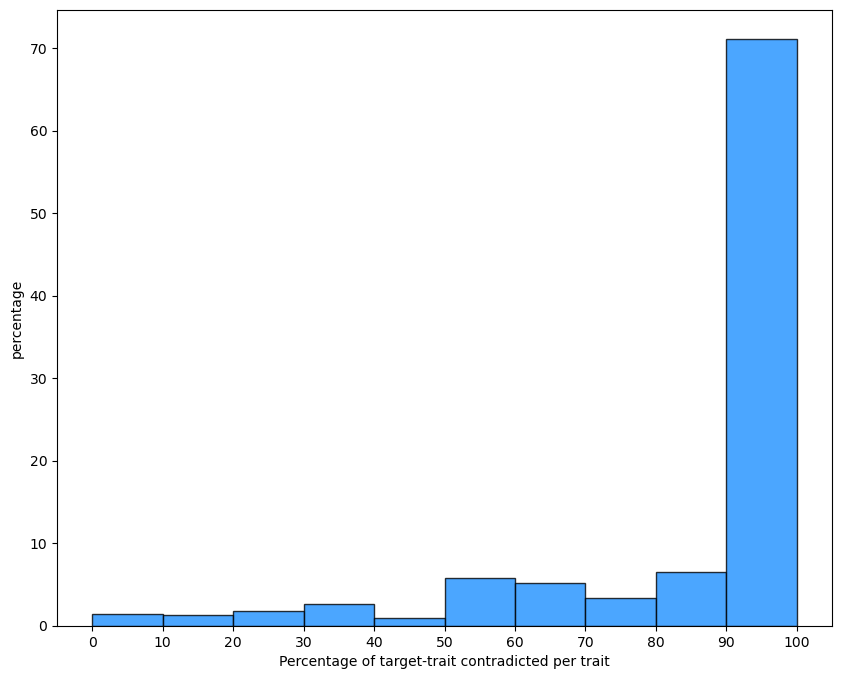

In [285]:
import numpy as np
import matplotlib.pyplot as plt
x0=-10

x = data['plotear']
bins = np.arange(0, 120+x0, 10.0)

plt.figure(figsize=(10,8))
# the histogram of the data

plt.hist(x, bins, alpha=0.8, histtype='bar', color='dodgerblue',
         ec='black',weights=np.zeros_like(x) + 100. / x.size)
var = 'Percentage of target-trait contradicted per trait'
plt.xlabel(var)
plt.ylabel('percentage')
plt.xticks(bins)
plt.show()

In [202]:
explore6=(explore5
.withColumn('total',explore5.total.cast('float'))
.withColumn('percentageContradictedPairs',explore5.percentageContradictedPairs.cast('float')))

In [216]:
data=explore6.toPandas()

In [204]:
data=explore6.filter(F.col('percentageContradictedPairs')!='notApplicable').toPandas()

In [176]:
explore5.toPandas().to_csv('manualvision.csv')

In [144]:
explore5.filter(F.col('countDiferent')==0).count()

200

In [146]:
explore5.filter(F.col('countDiferent')>0).count()

678

In [105]:
colus=['percentage','totalDiseasesTarget']

In [160]:
exploreDisease = (
    explore_contra3.groupBy("diseaseId")
    .agg(
        F.sum(F.when(F.col("uniqueTerms") == 1, F.lit(1)).otherwise(F.lit(0))).alias(
            "countsUniqueTerms"
        ),
        F.count("diseaseId").alias("totalDiseasesTarget"),
    )
    .withColumn("percentage", (F.col("countsUniqueTerms") / F.col("totalDiseasesTarget")) * 100)
    .orderBy(colus, ascending=False)
)


In [161]:
exploreDisease.show()

+-------------+-----------------+-------------------+----------+
|    diseaseId|countsUniqueTerms|totalDiseasesTarget|percentage|
+-------------+-----------------+-------------------+----------+
|  EFO_0005192|              245|                245|     100.0|
|  EFO_0007978|               48|                 48|     100.0|
|  EFO_0004614|               29|                 29|     100.0|
|  EFO_0007997|               14|                 14|     100.0|
|  EFO_0003958|                8|                  8|     100.0|
|  EFO_0009389|                8|                  8|     100.0|
|  EFO_0010972|                7|                  7|     100.0|
|MONDO_0001330|                7|                  7|     100.0|
|  EFO_1001884|                7|                  7|     100.0|
|  EFO_1000172|                6|                  6|     100.0|
|   HP_0003326|                5|                  5|     100.0|
|  EFO_0007996|                5|                  5|     100.0|
|  EFO_0009795|          

In [162]:
exploreDisease.toPandas().to_csv('percentage.csv')

In [156]:
exploreDisease.describe().show()

+-------+--------------+------------------+-------------------+------------------+
|summary|     diseaseId|            counts|totalDiseasesTarget|        percentage|
+-------+--------------+------------------+-------------------+------------------+
|  count|           878|               878|                878|               878|
|   mean|          null| 4.747152619589977| 15.456719817767654| 32.56767075091109|
| stddev|          null|23.665086887209803|  49.78134465041143|42.013098643825955|
|    min|   EFO_0000094|                 0|                  1|               0.0|
|    max|Orphanet_99880|               394|                508|             100.0|
+-------+--------------+------------------+-------------------+------------------+



In [122]:
exploreDisease.filter(F.col('counts')==1).count()

200

In [ ]:
#### From the 678 diseases, take the percentage of them that 

In [269]:

data = exploreDisease.select(F.col("percentage"), F.col("countsUniqueTerms")).toPandas()

In [272]:
exploreDisease.filter(F.col('countsUniqueTerms')!=0).count()

423

In [ ]:
data = exploreDisease.select(F.col("percentage"), F.col("countsUniqueTerms")).toPandas()

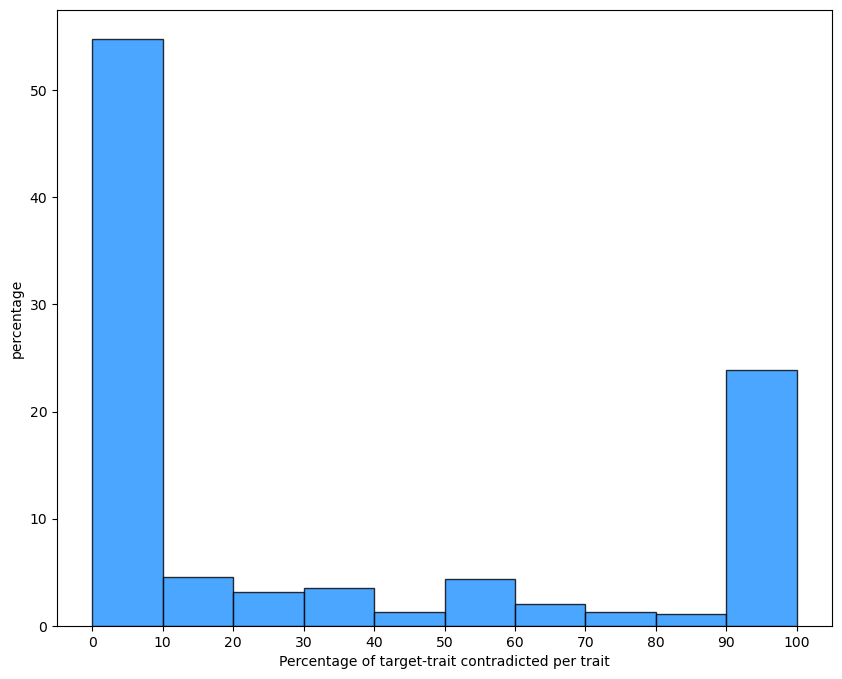

In [271]:
import numpy as np
import matplotlib.pyplot as plt
x0=-10

x = data['percentage']
bins = np.arange(0, 120+x0, 10.0)

plt.figure(figsize=(10,8))
# the histogram of the data

plt.hist(x, bins, alpha=0.8, histtype='bar', color='dodgerblue',
         ec='black',weights=np.zeros_like(x) + 100. / x.size)
var = 'Percentage of target-trait contradicted per trait'
plt.xlabel(var)
plt.ylabel('percentage')
plt.xticks(bins)
plt.show()

AttributeError: 'AxesSubplot' object has no attribute 'update_layout'

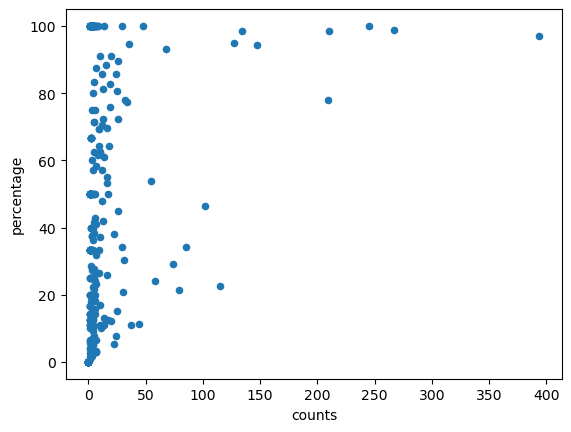

In [118]:
data = exploreDisease.select(F.col("percentage"), F.col("counts")).toPandas()
# Plot the bar chart using Matplotlib
fig=data.plot.scatter(x='counts', y='percentage')
fig.update_layout(template="plotly_dark")  


In [68]:
explore_contra2.toPandas().to_csv('explore_contra2_24feb.csv')

/opt/anaconda3/envs/python/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [165]:
drug.select('id','tradeNames').show()

+-------------+--------------------+
|           id|          tradeNames|
+-------------+--------------------+
|CHEMBL1173055|                  []|
|CHEMBL1200910|[Gantrisin, Gantr...|
|CHEMBL1201248|            [Nimbex]|
|CHEMBL1201468|[Amnestrogen, Est...|
|CHEMBL1201718|[Cumulase, Hylene...|
|CHEMBL1201772|            [Efient]|
|CHEMBL1234354|                  []|
|CHEMBL1408759|                  []|
|   CHEMBL1423|    [Orap, Pimozide]|
|CHEMBL1476500|                  []|
|   CHEMBL1515|[Favistan, Methim...|
|  CHEMBL15844|                  []|
|CHEMBL1591365|                  []|
|  CHEMBL16081|                  []|
|   CHEMBL1622|[Bio science, Fol...|
|CHEMBL1683544|           [Halaven]|
|   CHEMBL1729|[Alimix, Prepulsi...|
|CHEMBL1743065|                  []|
|CHEMBL1789941|            [Jakavi]|
|CHEMBL1823817|                  []|
+-------------+--------------------+
only showing top 20 rows



In [167]:
chembl.printSchema()

root
 |-- datasourceId: string (nullable = true)
 |-- targetId: string (nullable = true)
 |-- alleleOrigins: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- allelicRequirements: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ancestry: string (nullable = true)
 |-- ancestryId: string (nullable = true)
 |-- beta: double (nullable = true)
 |-- betaConfidenceIntervalLower: double (nullable = true)
 |-- betaConfidenceIntervalUpper: double (nullable = true)
 |-- biologicalModelAllelicComposition: string (nullable = true)
 |-- biologicalModelGeneticBackground: string (nullable = true)
 |-- biologicalModelId: string (nullable = true)
 |-- biomarkerName: string (nullable = true)
 |-- biomarkers: struct (nullable = true)
 |    |-- geneExpression: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- id: string (nullable = true)
 |    |    |    |-- name: string (nullable = true)
 |    |-- variant

In [168]:
target.printSchema()

root
 |-- id: string (nullable = true)
 |-- approvedSymbol: string (nullable = true)
 |-- biotype: string (nullable = true)
 |-- transcriptIds: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- canonicalTranscript: struct (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- chromosome: string (nullable = true)
 |    |-- start: long (nullable = true)
 |    |-- end: long (nullable = true)
 |    |-- strand: string (nullable = true)
 |-- canonicalExons: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- genomicLocation: struct (nullable = true)
 |    |-- chromosome: string (nullable = true)
 |    |-- start: long (nullable = true)
 |    |-- end: long (nullable = true)
 |    |-- strand: integer (nullable = true)
 |-- alternativeGenes: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- approvedName: string (nullable = true)
 |-- go: array (nullable = true)
 |    |-- element: struct (containsNull = tru

In [170]:
indication.printSchema()

root
 |-- id: string (nullable = true)
 |-- indications: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- disease: string (nullable = true)
 |    |    |-- efoName: string (nullable = true)
 |    |    |-- references: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- source: string (nullable = true)
 |    |    |    |    |-- ids: array (nullable = true)
 |    |    |    |    |    |-- element: string (containsNull = true)
 |    |    |-- maxPhaseForIndication: long (nullable = true)
 |-- approvedIndications: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- indicationCount: integer (nullable = true)



In [ ]:
eva_path="/Users/juanr/Desktop/Target_Engine/DownloadFebruary_Release23.02/evidence/sourceId=eva"


In [173]:
path='/Users/juanr/Desktop/frdb-drugs.tsv'
df = spark.read.csv(path, sep=r'\t', header=True)


# explore_contra2.toPandas().to_csv('exploringDataSource_20230222.csv')



In [5]:
impc_path="/Users/juanr/Desktop/Target_Engine/DownloadFebruary_Release23.02/evidence/sourceId=impc"
impc=spark.read.parquet(impc_path)

In [397]:
path='/Users/juanr/Desktop/gene_attribute_matrix.tsv'
dftxt = spark.read.csv(path, sep=r'\t')

In [ ]:
dftxt.show()

In [174]:
df.show()

+-----------+-------------------+-------------+
|compound_id|      compound_name|compound_unii|
+-----------+-------------------+-------------+
|          1|       STEMREGENIN1|   RNE1V1F9O1|
|          3|      AMITRIPTYLINE|   1806D8D52K|
|          4|        DEFERASIROX|   V8G4MOF2V9|
|          5|PERAMIVIR ANHYDROUS|   9ZS94HQO3B|
|          6|        CEFTOLOZANE|   37A4IES95Q|
|          7|          DASABUVIR|   DE54EQW8T1|
|          8|           OLAPARIB|   WOH1JD9AR8|
|          9|       FINAFLOXACIN|   D26OSN9Q4R|
|         10|        PIRFENIDONE|   D7NLD2JX7U|
|         11|         NINTEDANIB|   G6HRD2P839|
|         13|         LEDIPASVIR|   013TE6E4WV|
|         14|          NALOXEGOL|   44T7335BKE|
|         15|         ELIGLUSTAT|   DR40J4WA67|
|         16|         SUVOREXANT|   081L192FO9|
|         17|      EMPAGLIFLOZIN|   HDC1R2M35U|
|         18|         OLODATEROL|   VD2YSN1AFD|
|         19|         IDELALISIB|   YG57I8T5M0|
|         20|         TAVABOROLE|   K124

In [6]:
mice=drop_fully_null_columns(impc,'targetId')

23/02/23 15:11:19 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [ ]:
mice.select('targetId','diseaseFromSource','diseaseId','diseaseFromSourceMappedId').show(truncate=False)

In [195]:
mice.select('targetId','diseaseFromSource','diseaseId').join(diseases.select('id','ancestors'), diseases.id==F.col('diseaseId'),'left').toPandas().to_csv('ancestors.csv')

In [32]:
grouping=(mice
.select('targetId','diseaseFromSource','diseaseId')
.join(diseases.select('id','ancestors'), diseases.id==F.col('diseaseId'),'left')
.select(
    'targetId',
    F.col('diseaseId').alias('originalDisease'),
    F.explode_outer('ancestors').alias('ancestors_1'))
.groupBy('ancestors_1')
.agg(F.count('targetId'),F.count('originalDisease'))
).count()

In [28]:
grouped_1=(mice
.select('targetId','diseaseFromSource','diseaseId')
.join(diseases.select('id','ancestors'), diseases.id==F.col('diseaseId'),'left')
.select(
    'targetId',
    F.col('diseaseId').alias('originalDisease'),
    F.explode_outer('ancestors').alias('ancestors_1'))
##.groupBy('ancestors')
##.agg(F.count('targetId'),F.count('diseaseId'))
)


In [37]:
grouped2=(grouped_1
.join(diseases.select('id','ancestors'), diseases.id==F.col('ancestors_1'),'left')
.select('targetId','originalDisease','ancestors_1',F.explode_outer('ancestors').alias('ancestors_2')))



In [38]:
(grouped2
.groupBy('ancestors_2')
.agg(F.count('targetId'),F.count('originalDisease'))).count()

2268

In [44]:
grouped3=(grouped2
.join(diseases.select('id','ancestors'), diseases.id==F.col('ancestors_2'),'left')
.select('targetId','originalDisease','ancestors_1','ancestors_2',F.explode_outer('ancestors').alias('ancestors_3')))

In [45]:
(grouped3
.groupBy('ancestors_3')
.agg(F.count('targetId'),F.count('originalDisease'))).count()

1319

In [48]:
grouped4=(grouped3
.join(diseases.select('id','ancestors'), diseases.id==F.col('ancestors_3'),'left')
.select('targetId','originalDisease','ancestors_1','ancestors_2','ancestors_3',F.explode_outer('ancestors').alias('ancestors_4')))

In [49]:
(grouped4
.groupBy('ancestors_4')
.agg(F.count('targetId'),F.count('originalDisease'))).count()

769

In [51]:
(grouped4
.groupBy('ancestors_4')
.agg(F.count('targetId'),F.count('originalDisease'))
.join(diseases.select('id','name'), F.col('ancestors_4')==diseases.id,'left')
).show()

+---------------+---------------+----------------------+---------------+--------------------+
|    ancestors_4|count(targetId)|count(originalDisease)|             id|                name|
+---------------+---------------+----------------------+---------------+--------------------+
|  MONDO_0021193|           6255|                  6255|  MONDO_0021193|neuroepithelial n...|
|  MONDO_0001493|             45|                    45|  MONDO_0001493|chronic pulmonary...|
|  MONDO_0005129|            311|                   311|  MONDO_0005129|            cataract|
|  MONDO_0024635|             70|                    70|  MONDO_0024635|small intestine d...|
|  MONDO_0020019|            828|                   828|  MONDO_0020019|digestive tract m...|
|  MONDO_0021248|          59041|                 59041|  MONDO_0021248|nervous system ne...|
|  MONDO_0020590|             60|                    60|  MONDO_0020590|mycobacterial inf...|
|  MONDO_0015962|              9|                     9|  MO

In [52]:
grouped5=(grouped4
.join(diseases.select('id','ancestors'), diseases.id==F.col('ancestors_4'),'left')
.select('targetId','originalDisease','ancestors_1','ancestors_2','ancestors_3','ancestors_4',F.explode_outer('ancestors').alias('ancestors_5')))

In [54]:
(grouped5.groupBy('ancestors_5')
.agg(F.count('targetId'),F.count('originalDisease'))).count()

453

In [55]:
grouped6=(grouped5
.join(diseases.select('id','ancestors'), diseases.id==F.col('ancestors_5'),'left')
.select('targetId','originalDisease','ancestors_1','ancestors_2','ancestors_3','ancestors_4','ancestors_5',F.explode_outer('ancestors').alias('ancestors_6')))

In [56]:
(grouped6.groupBy('ancestors_6')
.agg(F.count('targetId'),F.count('originalDisease'))).count()

270

In [61]:
(grouped6.groupBy('ancestors_6')
.agg(F.count('targetId'),F.count('originalDisease'))
.join(diseases.select('id','name'), F.col('ancestors_6')==diseases.id,'left')
.select('name')).toPandas().to_csv('nameDiseasesKO.csv')
##).show(truncate=False)

In [199]:
print(grouping)


3996


In [8]:
bad_sufix = [
    "algia",
    "centesis",
    "ectomy",
    "emia",
    "itis",
    "oma",
    "osis",
    "otomy",
    "pathy",
    "rrhea",
    "scopy",
    "blast",
    "cyte",
    "penia",
    "plasty",
    "rrhage",
    "somy",
    "lysis",
    "uria",
]
bad_prefix = [
    "anti",
    "bi",
    "brady",
    "dys",
    "epi",
    "hyper",
    "hypo",
    "macro",
    "micro",
    "neo",
    "poly",
]

extra = [
    "severe",
    "deficien",
    "disease",
    "sensitiv",
    "lytic",
    "plasia",
    "syndrom",
    "disability",
    "trophy",
    "nism",
    "disorder",
    "failure",
]
extra3 = [
    "congenital",
    "hereditary",
    "atrophy",
    "abnormal",
    "lethal",
    "pneumoni",
    "malform",
    "impair",
    "deficienc",
    "ataxia",
    "hemimelia",
    "diabet",
    "delay",
    "degener",
    "defect",
    "schizo",
    "cancer",
    "tumor",
    "paresis",
    "hemorrhag",
    "agenesis",
    "retard",
    "aneurysm",
    "familial",
    "imperfecta",
    "chronic",
    "chondro",
    "lupus",
    "phaly",
    "atresia",
    "autoimmune",
    "insuffi",
    "fever",
    "cyst",
    "deaf",
    "brachydac",
    "cataract",
    "autism",
    "deletion",
    "anergy",
    "infertility",
    "calcification",
    "ermine",
    "mutation",
    "woolly",
    "megalocornea",
    "piebald",
    "ventr",
    "lesion",
    "atrial",
    "cardia",
    "obesity",
    "mody",
    "46,x",
    "alopecia" "nephro",
    "vesico",
    "xeroderm",
    "x-linked",
    "alopecia",
    "nephro",
]


In [9]:
apendice='(?i)'
badsufix2=list(apendice+s for s in bad_sufix)
badprefix2=list(apendice+s for s in bad_prefix)
extra2=list(apendice+s for s in extra)
extra4=list(apendice+s for s in extra3)

In [10]:
mouses=mice.select('targetId','diseaseFromSource','diseaseId')

In [63]:
target.printSchema()

root
 |-- id: string (nullable = true)
 |-- approvedSymbol: string (nullable = true)
 |-- biotype: string (nullable = true)
 |-- transcriptIds: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- canonicalTranscript: struct (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- chromosome: string (nullable = true)
 |    |-- start: long (nullable = true)
 |    |-- end: long (nullable = true)
 |    |-- strand: string (nullable = true)
 |-- canonicalExons: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- genomicLocation: struct (nullable = true)
 |    |-- chromosome: string (nullable = true)
 |    |-- start: long (nullable = true)
 |    |-- end: long (nullable = true)
 |    |-- strand: integer (nullable = true)
 |-- alternativeGenes: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- approvedName: string (nullable = true)
 |-- go: array (nullable = true)
 |    |-- element: struct (containsNull = tru

In [ ]:
mouses.filter(F.col('diseaseFromSource').rlike("(?i)dysplasia")).distinct().show(1000,truncate=False)

In [ ]:
mouses.filter(F.col('diseaseFromSource').rlike("(?i)dysplasia")).distinct().show(1000,truncate=False)

In [12]:
mouse3 = (
    mouses.withColumn(
        "sufix",
        F.when(
            F.col("diseaseFromSource").rlike("|".join(badsufix2)), F.lit("yes")
        ).otherwise(F.lit("no")),
    )
    .withColumn(
        "prefix",
        F.when(
            F.col("diseaseFromSource").rlike("|".join(badprefix2)), F.lit("yes")
        ).otherwise(F.lit("no")),
    )
    .withColumn(
        "extra",
        F.when(
            F.col("diseaseFromSource").rlike("|".join(extra2)), F.lit("yes")
        ).otherwise(F.lit("no")),
    )
    .withColumn(
        "sufixprefix",
        F.when(
            (F.col("diseaseFromSource").rlike("|".join(badsufix2)))
            | (F.col("diseaseFromSource").rlike("|".join(badprefix2))),
            F.lit("yes"),
        ).otherwise(F.lit("no")),
    )
    .withColumn(
        "sufixextra",
        F.when(
            (F.col("diseaseFromSource").rlike("|".join(badsufix2)))
            | (F.col("diseaseFromSource").rlike("|".join(extra2))),
            F.lit("yes"),
        ).otherwise(F.lit("no")),
    )
    .withColumn(
        "three",
        F.when(
            (F.col("diseaseFromSource").rlike("|".join(badsufix2)))
            | (F.col("diseaseFromSource").rlike("|".join(extra2)))
            | (F.col("diseaseFromSource").rlike("|".join(badprefix2))),
            F.lit("yes"),
        ).otherwise(F.lit("no")),
    )
    .withColumn(
        "terms",
        F.when(
            (F.col("diseaseFromSource").rlike("|".join(badsufix2)))
            | (F.col("diseaseFromSource").rlike("|".join(extra2)))
            | (F.col("diseaseFromSource").rlike("|".join(badprefix2)))
            | (F.col("diseaseFromSource").rlike("|".join(extra4))),
            F.lit("yes"),
        ).otherwise(F.lit("no")),
    )
)


In [13]:
totalTargets=mouses.select('targetId').distinct().count()

In [14]:
totalDiseases=mouses.select('diseaseFromSource').distinct().count()

In [16]:
mouse3.filter(F.col('terms')=='no').groupBy('diseaseFromSource').agg(F.count('diseaseFromSource'),F.countDistinct('targetId')).distinct().toPandas().to_csv('diseasesver5.csv')

In [17]:
totalCounts=mouses.count()

In [18]:
(mouse3
.groupBy('sufixprefix')
.agg(
    F.count('targetId').alias('coverage'),
    F.countDistinct('targetId').alias('difTargets'), 
    F.countDistinct('diseaseFromSource').alias('difDiseases'))
).show()
print('Nr total diferent targets: ', totalTargets)
print('Nr total diferent diseases: ', totalDiseases)
print('Nr total rows in MouseKO data: ', totalCounts)

+-----------+--------+----------+-----------+
|sufixprefix|coverage|difTargets|difDiseases|
+-----------+--------+----------+-----------+
|         no|  465840|     10063|       3680|
|        yes|  581184|     10374|       4972|
+-----------+--------+----------+-----------+

Nr total diferent targets:  10851
Nr total diferent diseases:  8652
Nr total rows in MouseKO data:  1047024


In [19]:
(mouse3
.groupBy('terms')
.agg(
    F.count('targetId').alias('coverage'),
    F.countDistinct('targetId').alias('difTargets'), 
    F.countDistinct('diseaseFromSource').alias('difDiseases'))
).show()
print('Nr total diferent targets: ', totalTargets)
print('Nr total diferent diseases: ', totalDiseases)
print('Nr total rows in MouseKO data: ', totalCounts)

+-----+--------+----------+-----------+
|terms|coverage|difTargets|difDiseases|
+-----+--------+----------+-----------+
|   no|   30874|      5089|        397|
|  yes| 1016150|     10826|       8255|
+-----+--------+----------+-----------+

Nr total diferent targets:  10851
Nr total diferent diseases:  8652
Nr total rows in MouseKO data:  1047024


In [192]:
diseases.filter(F.col('id')=='MONDO_0018858').show()

+-------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------+---------------+----+--------------------+--------------------+-----------+--------+----------------+-------------------+--------------------+
|           id|                code|             dbXRefs|         description|                name|directLocationIds| obsoleteTerms|        parents| sko|            synonyms|           ancestors|descendants|children|therapeuticAreas|indirectLocationIds|            ontology|
+-------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------+---------------+----+--------------------+--------------------+-----------+--------+----------------+-------------------+--------------------+
|MONDO_0018858|http://purl.oboli...|[UMLS:CN205176, O...|Graham Little-Pic...|Graham Little-Pic...|             null|[Orphanet_505]|[MONDO_0004907]|null|{null, [Piccardi-...|[

In [193]:
diseases.filter(F.col('id')=='EFO_0010285').show()

+-----------+--------------------+--------------------+--------------------+--------------------+-----------------+-------------+-------+----+--------------------+---------+--------------------+--------------------+----------------+-------------------+--------------------+
|         id|                code|             dbXRefs|         description|                name|directLocationIds|obsoleteTerms|parents| sko|            synonyms|ancestors|         descendants|            children|therapeuticAreas|indirectLocationIds|            ontology|
+-----------+--------------------+--------------------+--------------------+--------------------+-----------------+-------------+-------+----+--------------------+---------+--------------------+--------------------+----------------+-------------------+--------------------+
|EFO_0010285|http://www.ebi.ac...|[SCTID:128598002,...|A disease involvi...|integumentary sys...|             null|         null|     []|null|{null, [integumen...|       []|[MOND

In [187]:
mice.groupBy('targetId').agg(F.count('targetId')).count()

10851

In [179]:
mice.show()

+------------+---------------+---------------------------------+--------------------------------+-----------------+------------+--------------------+-------------------+-------------------------+-------------------------------------+-------------------------------------+--------------------+-------------+------------------+-------------+----------------------+------------------+---------------+--------------------+------------------+
|datasourceId|       targetId|biologicalModelAllelicComposition|biologicalModelGeneticBackground|biologicalModelId|  datatypeId|   diseaseFromSource|diseaseFromSourceId|diseaseFromSourceMappedId|diseaseModelAssociatedHumanPhenotypes|diseaseModelAssociatedModelPhenotypes|          literature|resourceScore|targetFromSourceId|targetInModel|targetInModelEnsemblId|targetInModelMgiId|      diseaseId|                  id|             score|
+------------+---------------+---------------------------------+--------------------------------+-----------------+---------

In [176]:
impc.printSchema()

root
 |-- datasourceId: string (nullable = true)
 |-- targetId: string (nullable = true)
 |-- alleleOrigins: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- allelicRequirements: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ancestry: string (nullable = true)
 |-- ancestryId: string (nullable = true)
 |-- beta: double (nullable = true)
 |-- betaConfidenceIntervalLower: double (nullable = true)
 |-- betaConfidenceIntervalUpper: double (nullable = true)
 |-- biologicalModelAllelicComposition: string (nullable = true)
 |-- biologicalModelGeneticBackground: string (nullable = true)
 |-- biologicalModelId: string (nullable = true)
 |-- biomarkerName: string (nullable = true)
 |-- biomarkers: struct (nullable = true)
 |    |-- geneExpression: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- id: string (nullable = true)
 |    |    |    |-- name: string (nullable = true)
 |    |-- variant

In [66]:
mophe_path="/Users/juanr/Desktop/Target_Engine/mousePhenotypeFebruary23/mousePhenotypes"
mophe=spark.read.parquet(mophe_path)

In [77]:
mophe.select('modelPhenotypeLabel',F.explode_outer('modelPhenotypeClasses')).select('col.label').show(truncate=False)

+---------------------------------+
|label                            |
+---------------------------------+
|homeostasis/metabolism phenotype |
|reproductive system phenotype    |
|cellular phenotype               |
|craniofacial phenotype           |
|growth/size/body region phenotype|
|cardiovascular system phenotype  |
|homeostasis/metabolism phenotype |
|homeostasis/metabolism phenotype |
|digestive/alimentary phenotype   |
|adipose tissue phenotype         |
|immune system phenotype          |
|behavior/neurological phenotype  |
|behavior/neurological phenotype  |
|muscle phenotype                 |
|hematopoietic system phenotype   |
|immune system phenotype          |
|respiratory system phenotype     |
|vision/eye phenotype             |
|pigmentation phenotype           |
|vision/eye phenotype             |
+---------------------------------+
only showing top 20 rows



In [85]:
mophe.select('modelPhenotypeLabel',F.explode_outer('modelPhenotypeClasses')).select('col.label','modelPhenotypeLabel').groupBy('label').agg(F.collect_set('modelPhenotypeLabel').alias('modelPhenotypeLabel'),F.countDistinct('modelPhenotypeLabel')).show()

+--------------------+--------------------+--------------------------+
|               label| modelPhenotypeLabel|count(modelPhenotypeLabel)|
+--------------------+--------------------+--------------------------+
|            neoplasm|[increased gastri...|                       197|
|    normal phenotype|[no abnormal phen...|                         4|
|digestive/aliment...|[branched small i...|                       461|
|    embryo phenotype|[abnormal chordam...|                       494|
|pigmentation phen...|[abnormal hind fo...|                        94|
|integument phenotype|[abnormal agouti ...|                       468|
|growth/size/body ...|[situs ambiguus, ...|                       596|
|renal/urinary sys...|[abnormal female ...|                       476|
|  cellular phenotype|[abnormal acrosom...|                       673|
|homeostasis/metab...|[increased erythr...|                      1078|
|  skeleton phenotype|[abnormal scapula...|                      1082|
|endoc

In [79]:
mophe.select('modelPhenotypeLabel',F.explode_outer('modelPhenotypeClasses')).select('col.label').distinct().toPandas().to_csv('mophe.csv')

In [76]:
mophe.select('modelPhenotypeLabel',F.explode_outer('modelPhenotypeClasses')).select('col.label').distinct().count()

### asignar score, agregar sobre el target y hacer un assessment usando la formula del score armonico. Creo que iria de -1 a 0.

28

In [369]:
diseases.filter(F.col('id')=='EFO_0010226').show(truncate=False)

+-----------+------------------------------------+---------------+-----------------------------------------+-------------------------------+-----------------+-------------+--------------------------+--------+-----------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [370]:
target.printSchema()

root
 |-- id: string (nullable = true)
 |-- approvedSymbol: string (nullable = true)
 |-- biotype: string (nullable = true)
 |-- transcriptIds: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- canonicalTranscript: struct (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- chromosome: string (nullable = true)
 |    |-- start: long (nullable = true)
 |    |-- end: long (nullable = true)
 |    |-- strand: string (nullable = true)
 |-- canonicalExons: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- genomicLocation: struct (nullable = true)
 |    |-- chromosome: string (nullable = true)
 |    |-- start: long (nullable = true)
 |    |-- end: long (nullable = true)
 |    |-- strand: integer (nullable = true)
 |-- alternativeGenes: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- approvedName: string (nullable = true)
 |-- go: array (nullable = true)
 |    |-- element: struct (containsNull = tru